okokokok

--- Plotting Slide 1: Mergeability ---


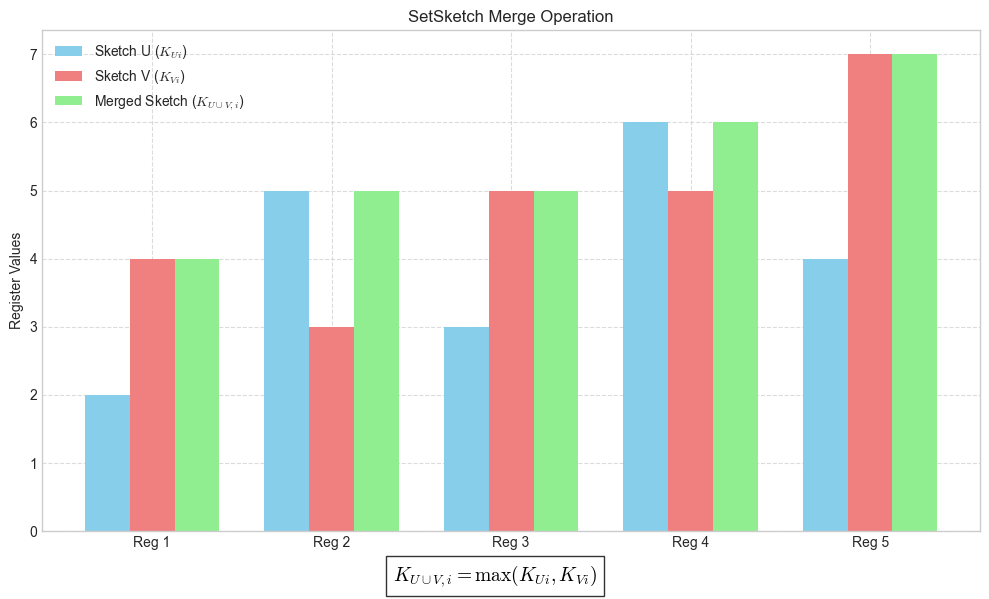


--- Plotting Slide 2: Distributions (Equations Removed) ---


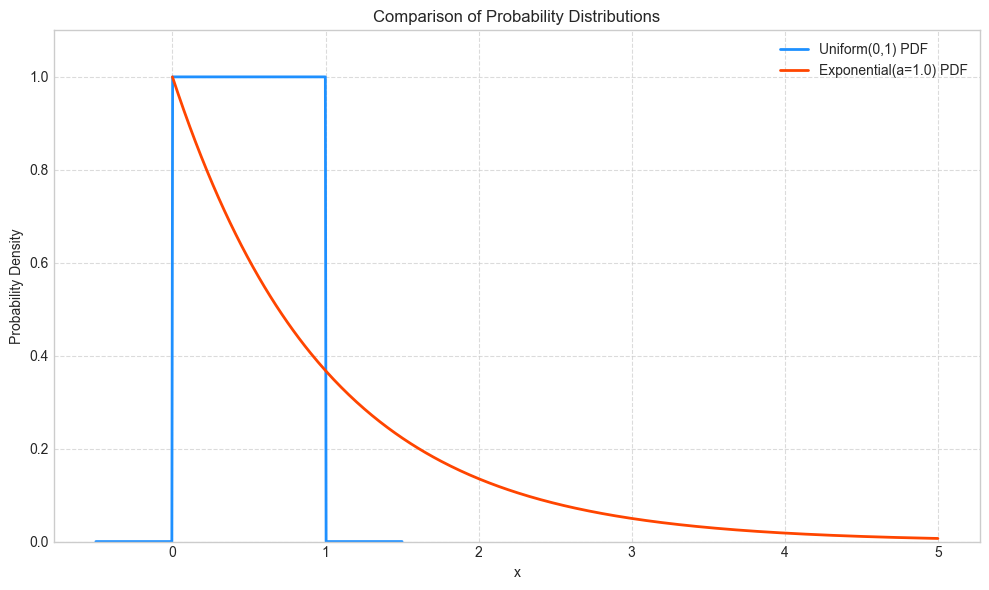


--- Plotting Slide 3: Definition & Algorithm 1 Conceptual ---


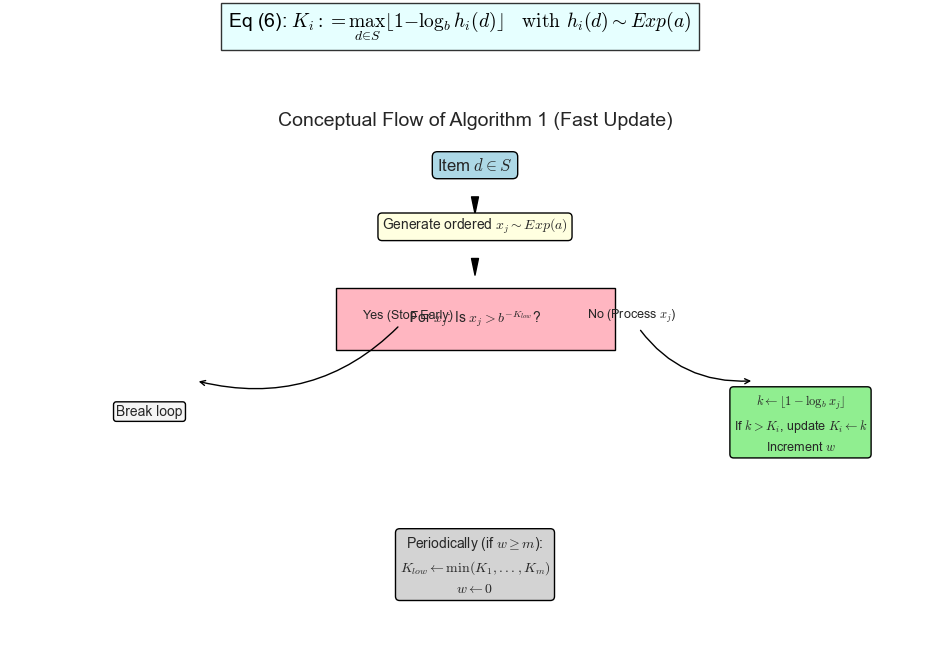


--- Plotting Slide 4: Hashing Conceptual ---


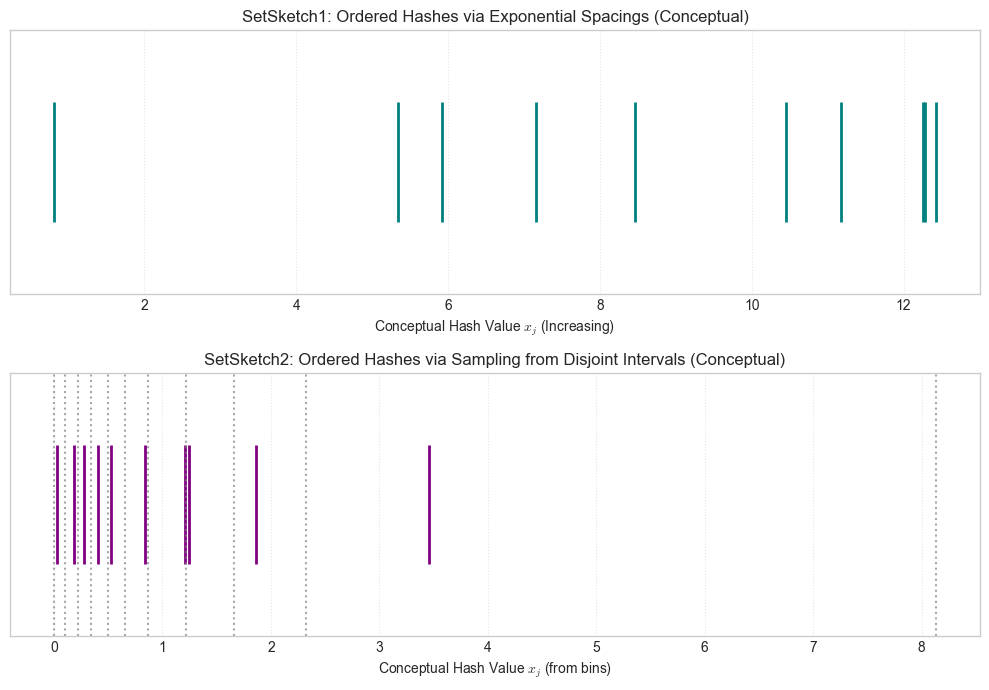

Note for Slide 4: The parameter table (m, b, a, q) should be added as text directly on your presentation slide.

--- Plotting Slide 5: Cardinality RSD (Equation Removed) ---


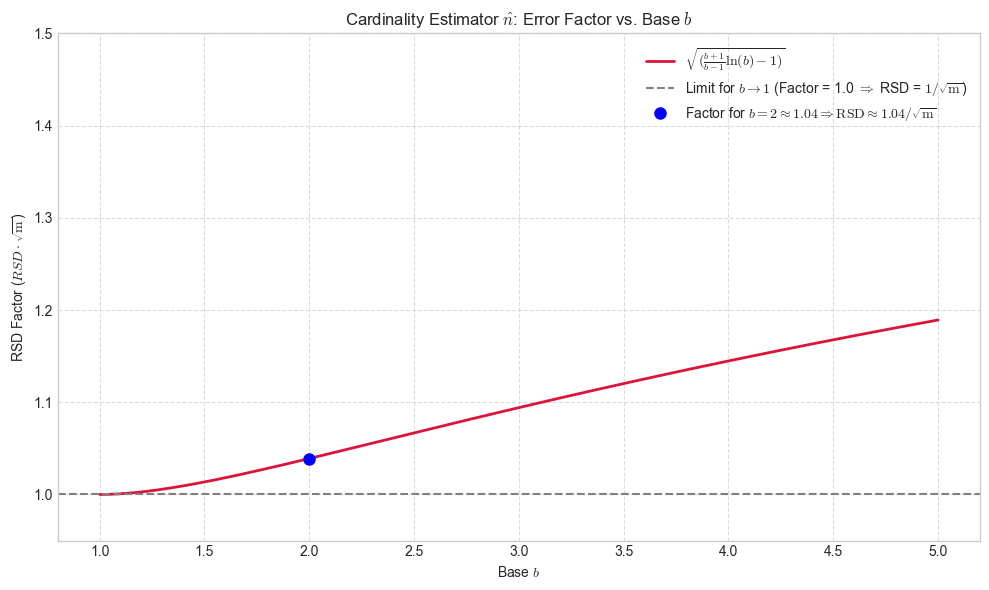


--- Plotting Slide 6: Joint Estimation Diagram (Improved) ---


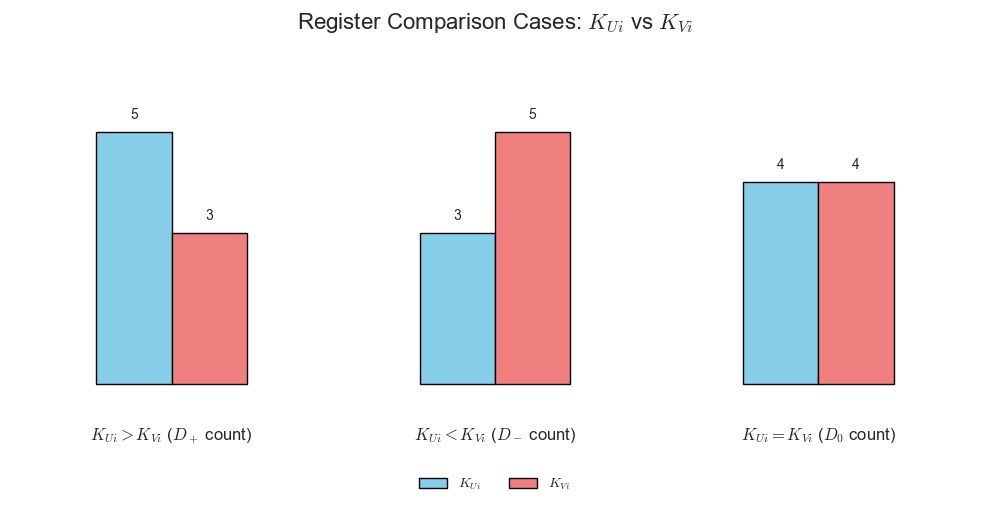


--- Plotting Slide 7: Figure 2 Replication & Log-Likelihood ---


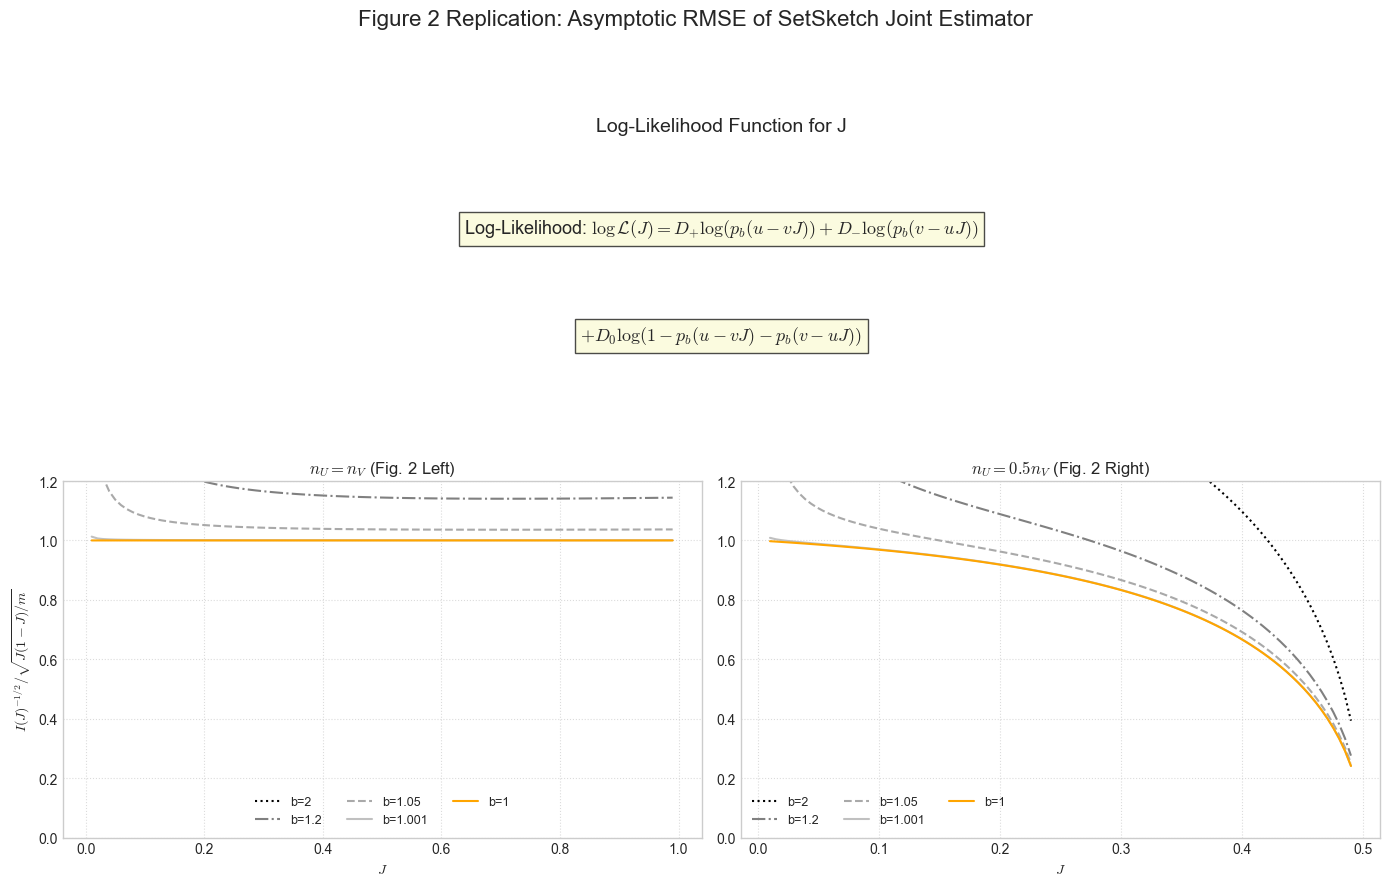


--- Plotting Slide 8: Figure 3 Replication (LSH Collision Probability) ---


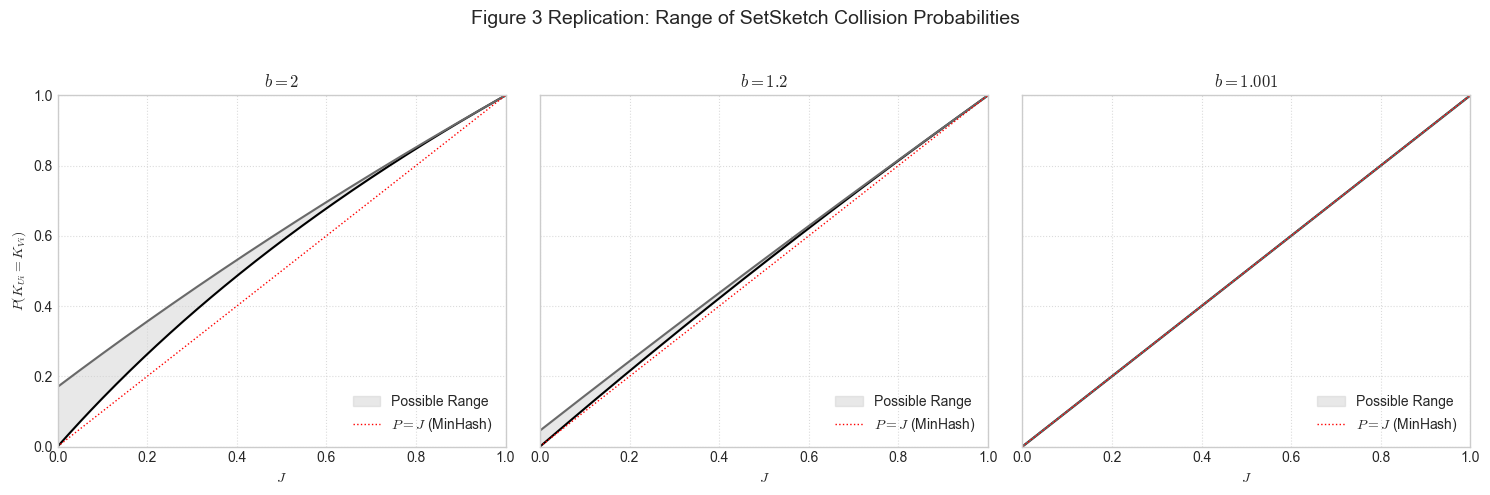


--- Plotting Slide 9: Figure 4 Replication & Equation 15 ---


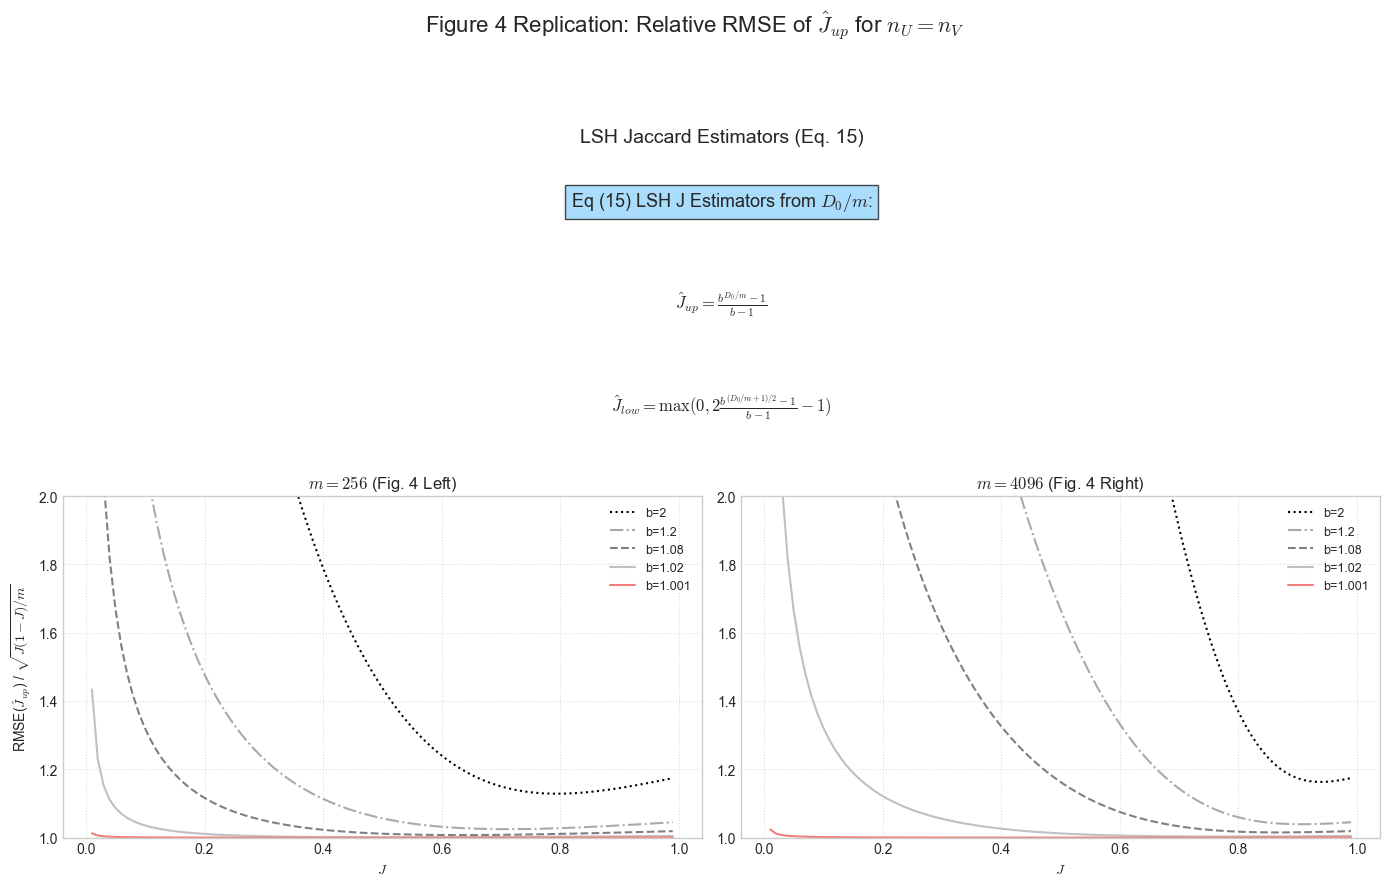

Note for Slide 9: Add the summary bullet point textually to your slide.
--- Plotting Slide 10: SetSketch vs. MinHash ---


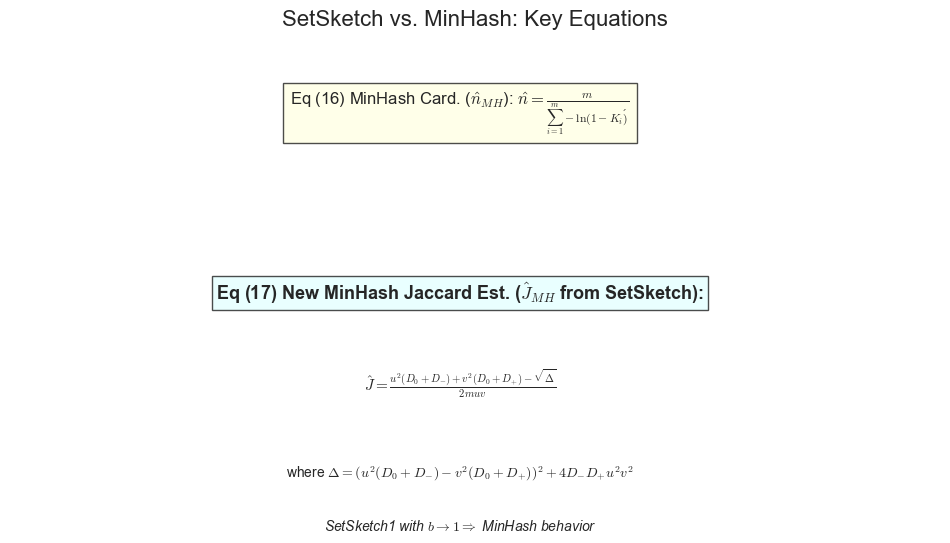


--- Plotting Slide 11: SetSketch vs. HLL/GHLL ---


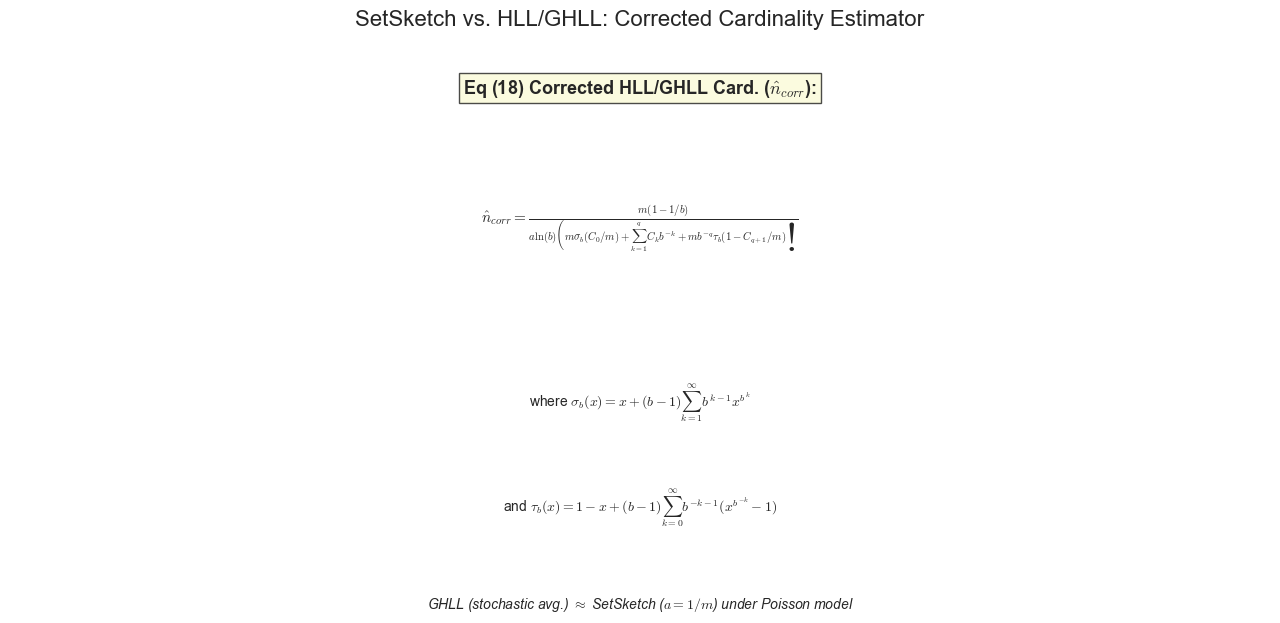


--- Plotting Slide 12: Broader Applications ---


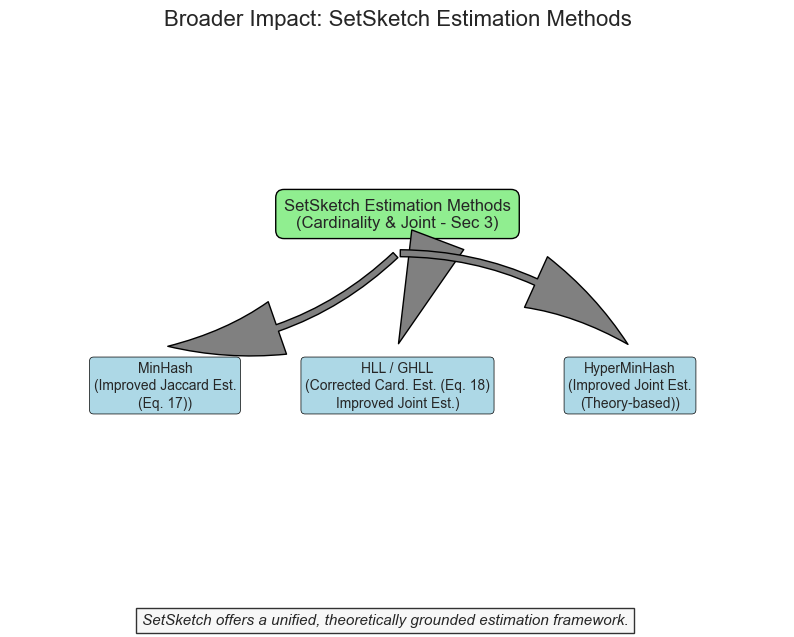

--- Plotting Slide 14: Cardinality Estimation (Mock Fig 5) ---


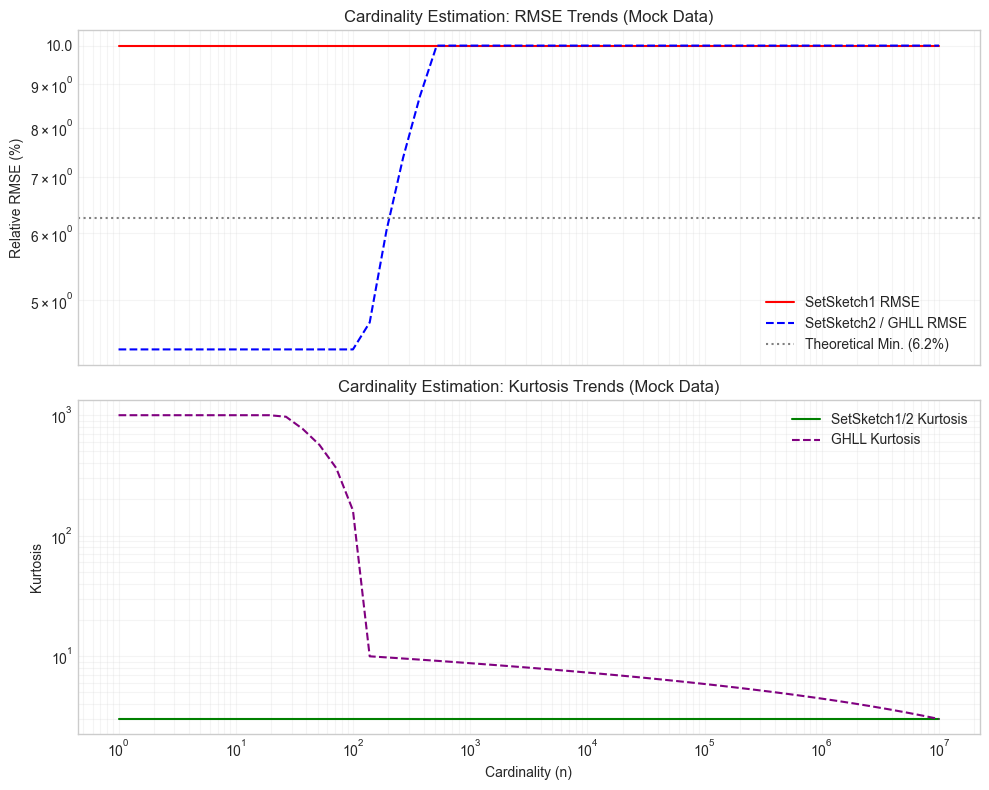


--- Plotting Slide 15: Joint Estimation - SetSketch (Mock Fig 6/7) ---


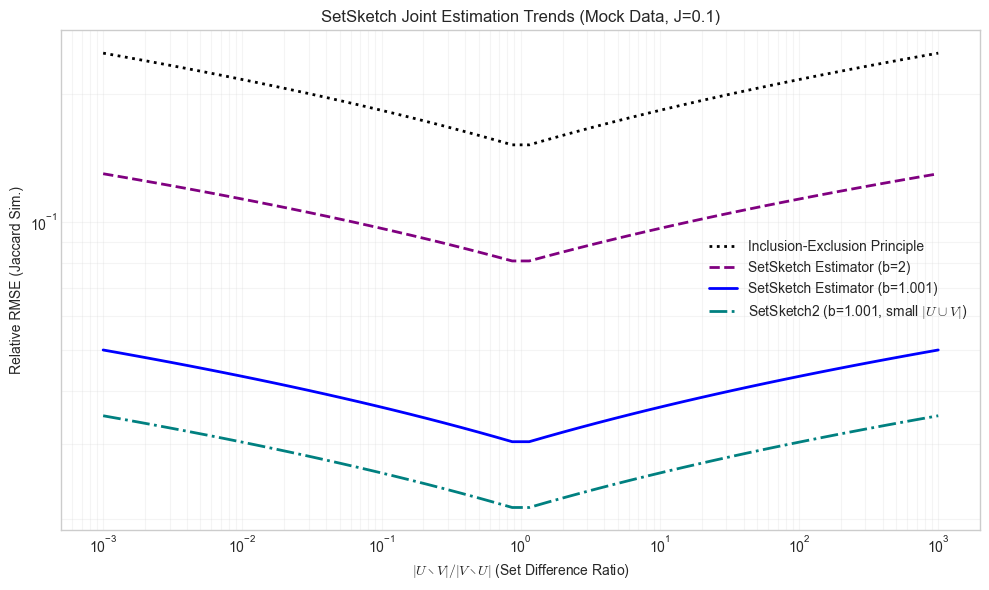


--- Plotting Slide 16: Joint Estimation - MinHash (Mock Fig 8) ---


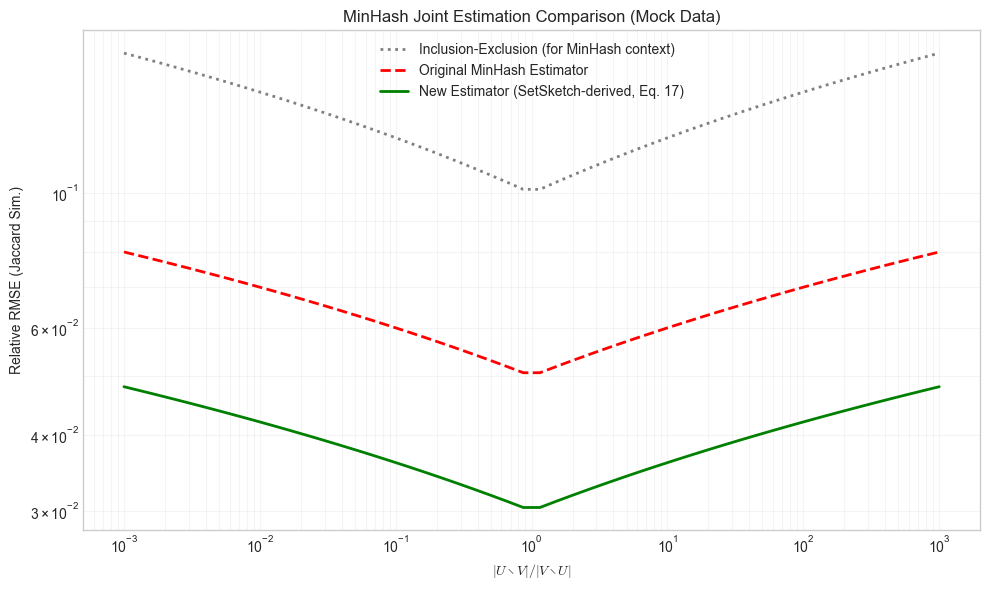


--- Plotting Slide 17: Joint Estimation - HyperMinHash (Mock Fig 9) ---


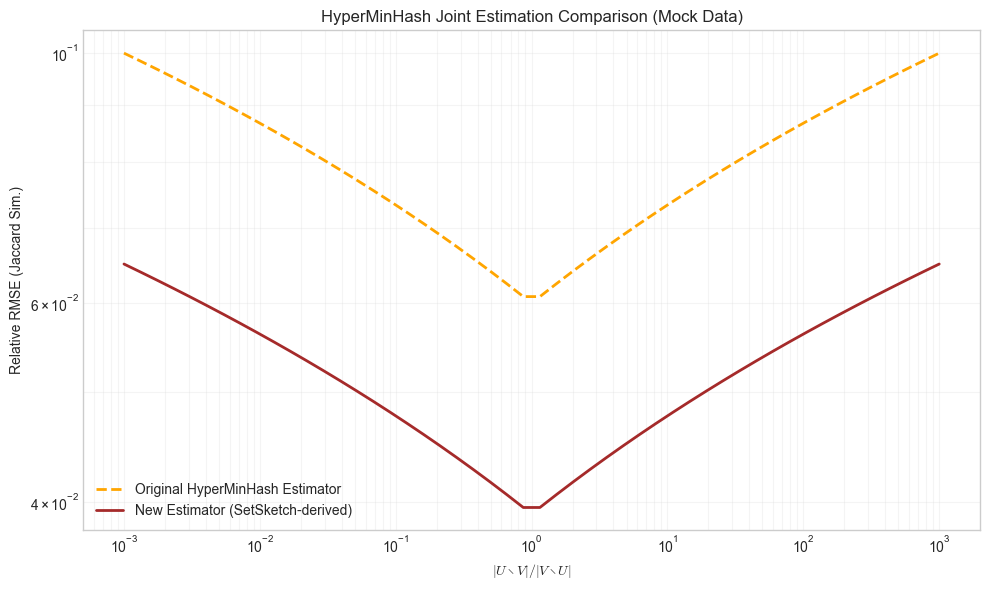


--- Plotting Slide 18: Recording Time Performance (Mock Fig 10) ---


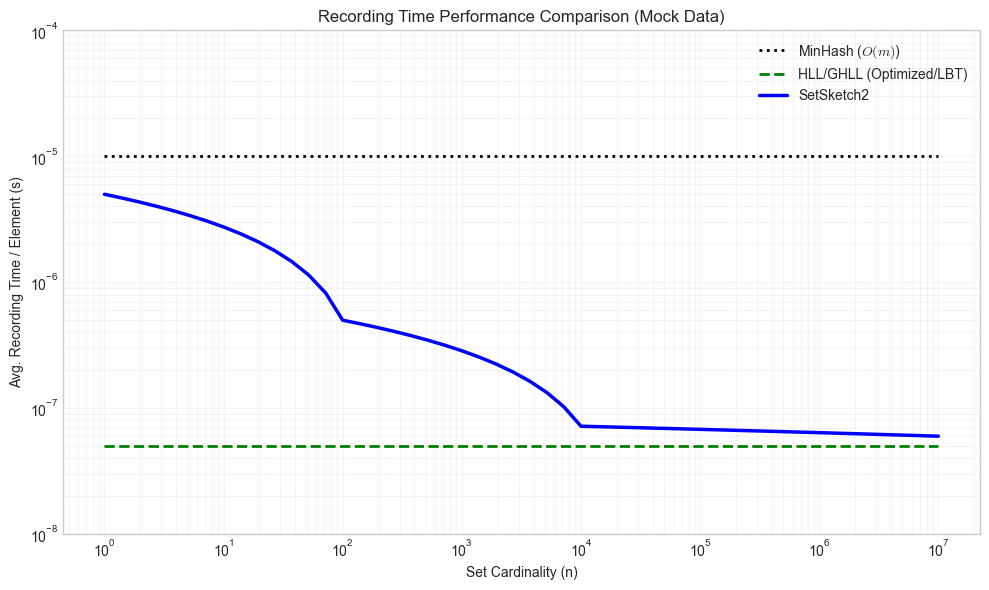

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker # <<< IMPORT ADDED HERE

# Common styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['text.usetex'] = False # Fallback if LaTeX is not installed, then use mathtext
plt.rcParams['mathtext.fontset'] = 'cm' # Use Computer Modern for math text

# --- Slide 1: Mergeability Illustration ---
# (Assumed correct from previous versions, not shown again for brevity unless needed)
def plot_slide1_mergeability():
    labels = ['Reg 1', 'Reg 2', 'Reg 3', 'Reg 4', 'Reg 5']
    k_u = [2, 5, 3, 6, 4]
    k_v = [4, 3, 5, 5, 7]
    k_merged = [max(u, v) for u, v in zip(k_u, k_v)]
    x = np.arange(len(labels))
    width = 0.25
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width, k_u, width, label='Sketch U ($K_{Ui}$)', color='skyblue')
    rects2 = ax.bar(x, k_v, width, label='Sketch V ($K_{Vi}$)', color='lightcoral')
    rects3 = ax.bar(x + width, k_merged, width, label='Merged Sketch ($K_{U \\cup V,i}$)', color='lightgreen')
    ax.set_ylabel('Register Values')
    ax.set_title('SetSketch Merge Operation')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    eq_text = r'$K_{U \cup V, i} = \max(K_{Ui}, K_{Vi})$'
    fig.text(0.5, 0.01, eq_text, ha='center', va='bottom', fontsize=14, color='black', bbox=dict(facecolor='white', alpha=0.8, pad=5))
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

# --- Slide 2: Exponential vs. Uniform Distribution & Equations ---
# (Corrected in previous response, assumed correct here)
def plot_slide2_distributions_only():
    """
    Plots PDF of Exponential distribution vs. Uniform(0,1) distribution.
    Equations removed as per request.
    """
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figsize if needed

    # Plotting distributions
    x_uniform = np.linspace(-0.5, 1.5, 400)
    pdf_uniform = np.where((x_uniform >= 0) & (x_uniform <= 1), 1, 0)
    a_exp = 1.0 # Rate parameter for exponential
    x_exp = np.linspace(0, 5, 400)
    pdf_exp = a_exp * np.exp(-a_exp * x_exp)

    ax.plot(x_uniform, pdf_uniform, label='Uniform(0,1) PDF', color='dodgerblue', lw=2)
    ax.plot(x_exp, pdf_exp, label=f'Exponential(a={a_exp}) PDF', color='orangered', lw=2)
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title('Comparison of Probability Distributions') # Updated title
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0, max(np.max(pdf_uniform), np.max(pdf_exp)) * 1.1)

    fig.tight_layout()
    plt.show()

# --- Slide 3: SetSketch Definition & Algorithm 1 Conceptual Diagram (Corrected) ---
def plot_slide3_definition_and_algo1_conceptual():
    """
    Displays Equation 6 and a corrected conceptual diagram for Algorithm 1.
    Corrected \ge to \geq
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off') 

    eq6_text = r'Eq (6): $K_i := \max_{d \in S} \lfloor 1 - \log_b h_i(d) \rfloor \quad \text{with } h_i(d) \sim Exp(a)$'
    fig.text(0.5, 0.92, eq6_text, ha='center', va='top', fontsize=14, color='black', bbox=dict(facecolor='lightcyan', alpha=0.8, pad=5))

    y_start = 0.8
    box_width = 0.3
    box_height = 0.1 
    arrow_props = dict(facecolor='black', shrink=0.05, width=1, headwidth=5)

    ax.text(0.5, y_start, "Item $d \in S$", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="lightblue"))
    
    ax.annotate("", xy=(0.5, y_start - 0.05 - box_height/2 + 0.02), xytext=(0.5, y_start - 0.05), arrowprops=arrow_props)
    ax.text(0.5, y_start - 0.1, "Generate ordered $x_j \sim Exp(a)$", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow"))

    ax.annotate("", xy=(0.5, y_start - 0.15 - box_height/2 + 0.02), xytext=(0.5, y_start - 0.15), arrowprops=arrow_props)
    ax.add_patch(patches.Rectangle((0.5 - box_width/2, y_start - 0.25 - box_height/2), box_width, box_height, facecolor='lightpink', edgecolor='black'))
    ax.text(0.5, y_start - 0.25, "For $x_j$: Is $x_j > b^{-K_{low}}$?", ha='center', va='center', fontsize=10)

    ax.annotate("Yes (Stop Early)", xy=(0.2, y_start - 0.35), xytext=(0.5 - box_width/2 * 0.8, y_start - 0.25), 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.3", facecolor='black'), fontsize=9)
    ax.text(0.15, y_start - 0.4, "Break loop", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.2", fc="whitesmoke"))

    ax.annotate("No (Process $x_j$)", xy=(0.8, y_start - 0.35), xytext=(0.5 + box_width/2 * 0.8, y_start - 0.25), 
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", facecolor='black'), fontsize=9)
    
    line1 = r"$k \leftarrow \lfloor 1 - \log_b x_j \rfloor$"
    line2 = r"If $k > K_i$, update $K_i \leftarrow k$" 
    line3 = r"Increment $w$"
    full_text = line1 + "\n" + line2 + "\n" + line3
    ax.text(0.85, y_start - 0.42, full_text,
             ha='center', va='center', fontsize=9, linespacing=1.5,
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen"))

    # Corrected \ge to \geq in the text below
    k_low_update_text = ("Periodically (if $w \geq m$):\n" # Corrected here
                         "$K_{low} \leftarrow \min(K_1, ..., K_m)$\n"
                         "$w \leftarrow 0$")
    ax.text(0.5, y_start - 0.65, k_low_update_text, 
             ha='center', va='center', fontsize=10, linespacing=1.5,
             bbox=dict(boxstyle="round,pad=0.3", fc="lightgray"))
    
    ax.set_title("Conceptual Flow of Algorithm 1 (Fast Update)", fontsize=14, y=0.85)
    plt.show()


# --- Slide 4: SetSketch1 vs SetSketch2 Hashing (Conceptual) & Parameter Table (Textual) ---
# (Assumed correct from previous versions)
def plot_slide4_hashing_conceptual_only():
    m = 10 
    spacings = np.random.exponential(scale=1.0, size=m) 
    x1_values = np.cumsum(spacings)
    exp_samples_for_bins = np.random.exponential(scale=1.0, size=1000)
    bin_edges = np.percentile(exp_samples_for_bins, np.linspace(0, 100, m + 1))
    x2_values = []
    for i in range(m):
        low_edge = bin_edges[i]
        high_edge = bin_edges[i+1]
        if high_edge <= low_edge: 
            high_edge = low_edge + 0.1 
        x2_values.append(np.random.uniform(low_edge, high_edge))
    x2_values = np.array(sorted(x2_values))
    fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
    axs[0].eventplot(x1_values, orientation='horizontal', colors='teal', lineoffsets=0.5, linelengths=0.8, linewidths=2)
    axs[0].set_yticks([])
    axs[0].set_title('SetSketch1: Ordered Hashes via Exponential Spacings (Conceptual)')
    axs[0].set_xlabel('Conceptual Hash Value $x_j$ (Increasing)')
    axs[0].grid(True, linestyle=':', alpha=0.5)
    axs[1].eventplot(x2_values, orientation='horizontal', colors='purple', lineoffsets=0.5, linelengths=0.8, linewidths=2)
    for edge in bin_edges: 
        axs[1].axvline(edge, color='gray', linestyle=':', alpha=0.7)
    axs[1].set_yticks([])
    axs[1].set_title('SetSketch2: Ordered Hashes via Sampling from Disjoint Intervals (Conceptual)')
    axs[1].set_xlabel('Conceptual Hash Value $x_j$ (from bins)')
    axs[1].grid(True, linestyle=':', alpha=0.5)
    fig.tight_layout()
    plt.show()
    print("Note for Slide 4: The parameter table (m, b, a, q) should be added as text directly on your presentation slide.")

# --- Slide 5: Cardinality Estimation RSD & Equation (Corrected) ---
def plot_slide5_cardinality_rsd_only():
    """
    Plots Relative Standard Deviation (RSD) for cardinality estimation.
    Equation 12 removed as per request.
    """
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figsize if needed
    
    b_values = np.linspace(1.0001, 5, 500) 
    term = (b_values + 1) / (b_values - 1) * np.log(b_values) - 1
    term = np.maximum(term, 0) 
    rsd_factor = np.sqrt(term) 

    ax.plot(b_values, rsd_factor, label=r'$\sqrt{(\frac{b+1}{b-1}\ln(b)-1)}$', color='crimson', lw=2)
    
    label_b_to_1 = r'Limit for $b \to 1$ (Factor = 1.0 $\Rightarrow$ RSD = $1/\sqrt{\mathrm{m}}$)'
    ax.axhline(1.0, color='gray', linestyle='--', label=label_b_to_1)
    
    rsd_b2_factor = np.sqrt(((2+1)/(2-1)) * np.log(2) - 1)
    label_b_eq_2_template = 'Factor for $b=2 \\approx {:.2f} \\Rightarrow \\mathrm{{RSD}} \\approx 1.04/\\sqrt{{\mathrm{{m}}}}$'
    label_b_eq_2 = label_b_eq_2_template.format(rsd_b2_factor)
    ax.plot(2, rsd_b2_factor, 'o', color='blue', markersize=8, label=label_b_eq_2)
    
    ax.set_xlabel('Base $b$')
    ax.set_ylabel('RSD Factor ($RSD \cdot \sqrt{\mathrm{m}}$)')
    ax.set_title('Cardinality Estimator $\hat{n}$: Error Factor vs. Base $b$')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0.95, 1.5)
    
    fig.tight_layout() # Standard tight_layout
    plt.show()

# --- Slide 6: Joint Estimation - Baseline, Probabilities & Diagram ---
# (Assumed correct from previous versions)
def plot_slide6_joint_estimation_diagram_improved():
    """
    Displays an improved diagram for register comparison cases ($K_{Ui}$ vs $K_{Vi}$).
    Equations removed as per request.
    """
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjusted figsize for better spacing
    
    ax.axis('off') # Turn off axis for a cleaner diagram
    ax.set_title("Register Comparison Cases: $K_{Ui}$ vs $K_{Vi}$", fontsize=16, pad=20)

    bar_height_KUi = [5, 3, 4]
    bar_height_KVi = [3, 5, 4]
    case_labels = ["$K_{Ui} > K_{Vi}$ ($D_+$ count)", 
                   "$K_{Ui} < K_{Vi}$ ($D_-$ count)", 
                   "$K_{Ui} = K_{Vi}$ ($D_0$ count)"]
    
    num_cases = len(case_labels)
    bar_width = 0.35
    group_spacing = 1.5 # Increased spacing between groups
    
    x_positions_group_center = np.arange(num_cases) * group_spacing
    
    for i in range(num_cases):
        center = x_positions_group_center[i]
        # Bar for K_Ui
        ax.bar(center - bar_width/2, bar_height_KUi[i], bar_width, 
               color='skyblue', edgecolor='black', label='$K_{Ui}$' if i == 0 else "")
        ax.text(center - bar_width/2, bar_height_KUi[i] + 0.2, f'{bar_height_KUi[i]}', 
                ha='center', va='bottom', fontsize=10)
        
        # Bar for K_Vi
        ax.bar(center + bar_width/2, bar_height_KVi[i], bar_width, 
               color='lightcoral', edgecolor='black', label='$K_{Vi}$' if i == 0 else "")
        ax.text(center + bar_width/2, bar_height_KVi[i] + 0.2, f'{bar_height_KVi[i]}', 
                ha='center', va='bottom', fontsize=10)
        
        # Case label below bars
        ax.text(center, -0.8, case_labels[i], ha='center', va='top', fontsize=12)

    ax.set_ylim(-1.5, max(max(bar_height_KUi), max(bar_height_KVi)) + 1.5) # Adjust y-limits
    ax.set_xlim(x_positions_group_center[0] - group_spacing/2, 
                x_positions_group_center[-1] + group_spacing/2)

    # Add a single legend
    handles, labels = ax.get_legend_handles_labels()
    if handles: # Check if legend items exist
      fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.05))

    fig.tight_layout(rect=[0, 0.1, 1, 0.9]) # Adjust layout to make space for title and legend
    plt.show()

# --- Slide 7: Joint Estimation Accuracy (Figure 2 from paper) & Log-Likelihood ---
def plot_slide7_figure2_and_loglikelihood():
    """
    Replicates Figure 2 from the SetSketch paper.
    Displays the Log-Likelihood function textually.
    """
    # Helper function p_b(x) and its derivative p_b_prime(x)
    def p_b(x, b_val):
        if b_val == 1: return x
        arg = 1 - x * (b_val - 1) / b_val
        if isinstance(arg, np.ndarray): arg[arg <= 1e-9] = 1e-9
        elif arg <= 1e-9: arg = 1e-9
        return -np.log(arg) / np.log(b_val)

    def p_b_prime(x, b_val):
        if b_val == 1: return 1.0
        denominator_arg = 1 - x * (b_val - 1) / b_val
        if isinstance(denominator_arg, np.ndarray): denominator_arg[denominator_arg <= 1e-9] = 1e-9
        elif denominator_arg <= 1e-9: denominator_arg = 1e-9
        val_b_pow_pb = 1.0 / denominator_arg
        return (b_val - 1) / (b_val * np.log(b_val)) * val_b_pow_pb

    def fisher_information(J_val, b_val, u, v, m_val=1):
        arg1 = u - v * J_val
        arg2 = v - u * J_val
        epsilon = 1e-9
        arg1 = np.clip(arg1, 0, 1-epsilon)
        arg2 = np.clip(arg2, 0, 1-epsilon)
        pb_arg1 = p_b(arg1, b_val)
        pb_arg2 = p_b(arg2, b_val)
        pb_arg1_safe = np.where(pb_arg1 == 0, epsilon, pb_arg1)
        pb_arg2_safe = np.where(pb_arg2 == 0, epsilon, pb_arg2)
        pb_prime_arg1 = p_b_prime(arg1, b_val)
        pb_prime_arg2 = p_b_prime(arg2, b_val)
        term1_num = (v * pb_prime_arg1)**2
        term1 = term1_num / pb_arg1_safe
        term2_num = (u * pb_prime_arg2)**2
        term2 = term2_num / pb_arg2_safe
        pb0 = 1 - pb_arg1 - pb_arg2
        pb0_safe = np.where(pb0 <= epsilon, epsilon, pb0)
        term3_num = (v * pb_prime_arg1 + u * pb_prime_arg2)**2
        term3 = term3_num / pb0_safe
        factor = m_val * (b_val - 1)**2 / (b_val**2 * np.log(b_val)**2)
        I_J = factor * (term1 + term2 + term3)
        return I_J

    b_values_fig2 = [2, 1.2, 1.05, 1.001, 1.000001] 
    linestyles = [':', '-.', '--', '-', '-']
    colors = ['black', 'gray', 'darkgray', 'silver', 'orange'] 

    fig = plt.figure(figsize=(14, 9)) # Adjusted for equation
    gs = fig.add_gridspec(2, 2)
    ax_fig2_left = fig.add_subplot(gs[1, 0])
    ax_fig2_right = fig.add_subplot(gs[1, 1])
    ax_eq_logL = fig.add_subplot(gs[0, :])
    ax_eq_logL.axis('off')

    # Display Log-Likelihood Equation
    logL_text1 = r'Log-Likelihood: $\log \mathcal{L}(J) = D_{+} \log(p_b(u-vJ)) + D_{-} \log(p_b(v-uJ))$'
    logL_text2 = r'$+ D_{0} \log(1 - p_b(u-vJ) - p_b(v-uJ))$'
    ax_eq_logL.text(0.5, 0.6, logL_text1, ha='center', va='center', fontsize=13, bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.7, pad=4))
    ax_eq_logL.text(0.5, 0.3, logL_text2, ha='center', va='center', fontsize=13, bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.7, pad=4))
    ax_eq_logL.set_title("Log-Likelihood Function for J", fontsize=14, y=0.85)


    # Figure 2 - Case 1: n_U = n_V
    u1, v1 = 0.5, 0.5
    J_max1 = 1.0
    J_vals1 = np.linspace(0.01, J_max1 - 0.01, 100)
    for i, b_val in enumerate(b_values_fig2):
        I_J_vals = fisher_information(J_vals1, b_val, u1, v1)
        minhash_rmse_factor_sq = J_vals1 * (1 - J_vals1)
        minhash_rmse_factor_sq[minhash_rmse_factor_sq < 1e-9] = 1e-9
        ratio = 1.0 / np.sqrt(I_J_vals * minhash_rmse_factor_sq)
        ax_fig2_left.plot(J_vals1, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_left.set_title('$n_U = n_V$ (Fig. 2 Left)')
    ax_fig2_left.set_xlabel('$J$')
    ax_fig2_left.set_ylabel('$I(J)^{-1/2} / \sqrt{J(1-J)/m}$')
    ax_fig2_left.set_ylim(0, 1.2)
    ax_fig2_left.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_left.legend(loc='lower center', ncol=3, fontsize=9)

    # Figure 2 - Case 2: n_U = 0.5 * n_V
    u2, v2 = 1/3, 2/3
    J_max2 = 0.5 
    J_vals2 = np.linspace(0.01, J_max2 - 0.01, 100)
    for i, b_val in enumerate(b_values_fig2):
        I_J_vals = fisher_information(J_vals2, b_val, u2, v2)
        minhash_rmse_factor_sq = J_vals2 * (1 - J_vals2)
        minhash_rmse_factor_sq[minhash_rmse_factor_sq < 1e-9] = 1e-9
        ratio = 1.0 / np.sqrt(I_J_vals * minhash_rmse_factor_sq)
        ax_fig2_right.plot(J_vals2, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_right.set_title('$n_U = 0.5 n_V$ (Fig. 2 Right)')
    ax_fig2_right.set_xlabel('$J$')
    ax_fig2_right.set_ylim(0, 1.2)
    ax_fig2_right.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_right.legend(loc='lower left', ncol=3, fontsize=9)
    
    fig.suptitle("Figure 2 Replication: Asymptotic RMSE of SetSketch Joint Estimator", fontsize=16, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Slide 8: LSH Collision Probability (Figure 3 from paper) ---
def plot_slide8_figure3():
    """
    Replicates Figure 3 from the SetSketch paper.
    Range of possible collision probabilities P(K_Ui = K_Vi).
    """
    J_vals = np.linspace(0, 1, 200)
    b_values_fig3 = [2, 1.2, 1.001]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, b_val in enumerate(b_values_fig3):
        lower_bound_arg = 1 + J_vals * (b_val - 1)
        lower_bound_arg[lower_bound_arg <= 1e-9] = 1e-9 
        P_coll_lower = np.log(lower_bound_arg) / np.log(b_val)
        
        upper_bound_arg = 1 + J_vals * (b_val - 1) + ((1 - J_vals)**2 * (b_val - 1)**2) / (4 * b_val)
        upper_bound_arg[upper_bound_arg <= 1e-9] = 1e-9 
        P_coll_upper = np.log(upper_bound_arg) / np.log(b_val)

        axs[i].plot(J_vals, P_coll_lower, color='black', linestyle='-', lw=1.5)
        axs[i].plot(J_vals, P_coll_upper, color='dimgray', linestyle='-', lw=1.5) 
        axs[i].fill_between(J_vals, P_coll_lower, P_coll_upper, color='lightgray', alpha=0.5, label='Possible Range')
        axs[i].plot(J_vals, J_vals, color='red', linestyle=':', lw=1, label='$P=J$ (MinHash)')

        axs[i].set_title(f'$b = {b_val}$')
        axs[i].set_xlabel('$J$')
        if i == 0:
            axs[i].set_ylabel('$P(K_{Ui} = K_{Vi})$')
        axs[i].grid(True, linestyle=':', alpha=0.7)
        axs[i].set_xlim(0, 1)
        axs[i].set_ylim(0, 1)
        axs[i].legend(loc='lower right')

    fig.suptitle("Figure 3 Replication: Range of SetSketch Collision Probabilities", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Slide 9: LSH RMSE (Figure 4 from paper) & Equation 15 ---
def plot_slide9_figure4_and_equation():
    """
    Replicates Figure 4 from the SetSketch paper.
    Displays Equation 15.
    """
    m_values = [256, 4096]
    b_values_fig4 = [2, 1.2, 1.08, 1.02, 1.001]
    linestyles = [':', '-.', '--', '-', '-'] 
    colors = ['black', 'darkgray', 'gray', 'silver', 'lightcoral'] 

    J_vals = np.linspace(0.01, 0.99, 100)

    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 2)
    ax_fig4_left = fig.add_subplot(gs[1, 0])
    ax_fig4_right = fig.add_subplot(gs[1, 1])
    ax_eq15 = fig.add_subplot(gs[0, :])
    ax_eq15.axis('off')

    # Display Equation 15
    eq15_text1 = r'Eq (15) LSH J Estimators from $D_0/m$:'
    eq15_text2 = r'$\hat{J}_{up} = \frac{b^{D_0/m}-1}{b-1}$'
    eq15_text3 = r'$\hat{J}_{low} = \max(0, 2\frac{b^{(D_0/m+1)/2}-1}{b-1}-1)$'
    ax_eq15.text(0.5, 0.75, eq15_text1, ha='center', va='center', fontsize=13, bbox=dict(facecolor='lightskyblue', alpha=0.7, pad=4))
    ax_eq15.text(0.5, 0.45, eq15_text2, ha='center', va='center', fontsize=12)
    ax_eq15.text(0.5, 0.15, eq15_text3, ha='center', va='center', fontsize=12)
    ax_eq15.set_title("LSH Jaccard Estimators (Eq. 15)", fontsize=14, y=0.9)


    for i, m_val in enumerate(m_values):
        ax = ax_fig4_left if i == 0 else ax_fig4_right
        for k, b_val in enumerate(b_values_fig4):
            arg_P_coll = 1 + J_vals*(b_val-1) + ((1-J_vals)**2 * (b_val-1)**2) / (4*b_val)
            arg_P_coll[arg_P_coll <= 1e-9] = 1e-9
            P_coll = np.log(arg_P_coll) / np.log(b_val)
            P_coll = np.clip(P_coll, 0, 1-1e-9)
            
            J_up_expected = (b_val**P_coll - 1) / (b_val - 1)
            derivative_J_up_at_P_coll = (b_val**P_coll * np.log(b_val)) / (b_val - 1)
            var_D0_m = P_coll * (1 - P_coll) / m_val
            var_J_up = (derivative_J_up_at_P_coll**2) * var_D0_m
            bias_J_up_sq = (J_up_expected - J_vals)**2 # Bias term
            rmse_J_up = np.sqrt(var_J_up + bias_J_up_sq)
            
            minhash_rmse = np.sqrt(J_vals * (1 - J_vals) / m_val)
            minhash_rmse[minhash_rmse < 1e-9] = 1e-9
            relative_rmse = rmse_J_up / minhash_rmse
            
            ax.plot(J_vals, relative_rmse, label=f'b={b_val}', linestyle=linestyles[k % len(linestyles)], color=colors[k % len(colors)], lw=1.5)

        ax.set_title(f'$m = {m_val}$ (Fig. 4 {"Left" if i==0 else "Right"})')
        ax.set_xlabel('$J$')
        if i == 0:
            ax.set_ylabel('RMSE($\hat{J}_{up}$) / $\sqrt{J(1-J)/m}$')
        ax.set_ylim(1.0, 2.0)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(loc='upper right', fontsize=9)

    fig.suptitle("Figure 4 Replication: Relative RMSE of $\hat{J}_{up}$ for $n_U=n_V$", fontsize=16, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
    print("Note for Slide 9: Add the summary bullet point textually to your slide.")


# --- Slide 10: SetSketch vs. MinHash (Equations 16 & 17) ---
def plot_slide10_minhash_comparison():
    """
    Displays Equation 16 (MinHash Cardinality) and 
    Equation 17 (SetSketch-derived Jaccard for MinHash).
    Corrected \implies to \Rightarrow
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off') 
    ax.set_title("SetSketch vs. MinHash: Key Equations", fontsize=16, pad=20)

    eq16_text = (r'Eq (16) MinHash Card. ($\hat{n}_{MH}$): '
                 r'$\hat{n} = \frac{m}{\sum_{i=1}^{m} -\ln(1-K_i\')}$') # Assuming K_i' is K_i prime
    
    eq17_text_line1 = (r'Eq (17) New MinHash Jaccard Est. ($\hat{J}_{MH}$ from SetSketch):')
    eq17_text_line2 = (r'$\hat{J} = \frac{u^{2}(D_{0}+D_{-})+v^{2}(D_{0}+D_{+}) - \sqrt{\Delta}}{2muv}$')
    eq17_text_line3 = (r'where $\Delta = (u^{2}(D_{0}+D_{-})-v^{2}(D_{0}+D_{+}))^{2}+4D_{-}D_{+}u^{2}v^{2}$')

    fig.text(0.5, 0.75, eq16_text, ha='center', va='center', fontsize=12, 
             bbox=dict(facecolor='lightyellow', alpha=0.7, pad=5))
    
    fig.text(0.5, 0.45, eq17_text_line1, ha='center', va='center', fontsize=13, fontweight='bold',
             bbox=dict(facecolor='lightcyan', alpha=0.7, pad=3))
    fig.text(0.5, 0.30, eq17_text_line2, ha='center', va='center', fontsize=11)
    fig.text(0.5, 0.15, eq17_text_line3, ha='center', va='center', fontsize=10)
    
    # Corrected \implies to \Rightarrow
    info_text = r"SetSketch1 with $b \to 1 \Rightarrow$ MinHash behavior" 
    fig.text(0.5, 0.05, info_text, ha='center', va='bottom', fontsize=10, style='italic')

    plt.subplots_adjust(top=0.85, bottom=0.15) # Adjust layout
    plt.show()

# --- Slide 11: SetSketch vs. HLL/GHLL (Equation 18) ---
def plot_slide11_hll_comparison():
    """
    Displays Equation 18 (Corrected HLL/GHLL Cardinality Estimator).
    """
    fig, ax = plt.subplots(figsize=(14, 7)) # Wider for the long equation
    ax.axis('off')
    ax.set_title("SetSketch vs. HLL/GHLL: Corrected Cardinality Estimator", fontsize=16, pad=20)

    eq18_text_line1 = (r'Eq (18) Corrected HLL/GHLL Card. ($\hat{n}_{corr}$):')
    eq18_text_line2 = (r'$\hat{n}_{corr}=\frac{m(1-1/b)}{a \ln(b) \left( m\sigma_{b}(C_{0}/m) + \sum_{k=1}^{q}C_{k}b^{-k} + mb^{-q}\tau_{b}(1-C_{q+1}/m) \right)}$')
    eq18_text_line3 = (r'where $\sigma_{b}(x)=x+(b-1)\sum_{k=1}^{\infty}b^{k-1}x^{b^{k}}$')
    eq18_text_line4 = (r'and $\tau_{b}(x)=1-x+(b-1)\sum_{k=0}^{\infty}b^{-k-1}(x^{b^{-k}}-1)$')

    fig.text(0.5, 0.80, eq18_text_line1, ha='center', va='center', fontsize=13, fontweight='bold',
             bbox=dict(facecolor='lightgoldenrodyellow', alpha=0.7, pad=3))
    fig.text(0.5, 0.60, eq18_text_line2, ha='center', va='center', fontsize=11)
    fig.text(0.5, 0.35, eq18_text_line3, ha='center', va='center', fontsize=10)
    fig.text(0.5, 0.20, eq18_text_line4, ha='center', va='center', fontsize=10)

    info_text = "GHLL (stochastic avg.) $\\approx$ SetSketch ($a=1/m$) under Poisson model"
    fig.text(0.5, 0.05, info_text, ha='center', va='bottom', fontsize=10, style='italic')
    
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)
    plt.show()

# --- Slide 12: Broader Applications (Conceptual Diagram) ---
def plot_slide12_broader_applications():
    """
    Conceptual diagram for broader applications of SetSketch estimators.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.axis('off')
    ax.set_title("Broader Impact: SetSketch Estimation Methods", fontsize=16, pad=30)

    # Central box
    center_x, center_y = 0.5, 0.7
    box_props = dict(boxstyle="round,pad=0.5", fc="lightgreen", ec="black", lw=1)
    ax.text(center_x, center_y, "SetSketch Estimation Methods\n(Cardinality & Joint - Sec 3)", 
            ha='center', va='center', fontsize=12, bbox=box_props)

    # Target sketches
    targets = {
        "MinHash": (0.2, 0.35, "Improved Jaccard Est.\n(Eq. 17)"),
        "HLL / GHLL": (0.5, 0.35, "Corrected Card. Est. (Eq. 18)\nImproved Joint Est."),
        "HyperMinHash": (0.8, 0.35, "Improved Joint Est.\n(Theory-based)")
    }

    arrow_props = dict(arrowstyle="Simple,tail_width=0.5,head_width=4,head_length=8", 
                       facecolor="gray", ec="black", connectionstyle="arc3,rad=-0.2")
    
    target_box_props = dict(boxstyle="round,pad=0.3", fc="lightblue", ec="black", lw=0.5)

    for name, (tx, ty, desc) in targets.items():
        ax.text(tx, ty, f"{name}\n({desc})", ha='center', va='center', fontsize=10, 
                bbox=target_box_props, linespacing=1.3)
        ax.annotate("", xy=(tx, ty + 0.08), xytext=(center_x, center_y - 0.08), 
                    arrowprops=arrow_props)
    
    summary_text = "SetSketch offers a unified, theoretically grounded estimation framework."
    fig.text(0.5, 0.05, summary_text, ha='center', va='bottom', fontsize=11, style='italic',
             bbox=dict(facecolor='whitesmoke', alpha=0.8, pad=4))

    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    plt.subplots_adjust(top=0.85, bottom=0.15)
    plt.show()

# --- Slide 14: Cardinality Estimation Performance (Simplified Fig 5) ---
# --- Slide 14: Cardinality Estimation Performance (Simplified Fig 5) ---
def plot_slide14_cardinality_mock():
    """
    Mock plot summarizing Figure 5: Cardinality Estimation RMSE and Kurtosis.
    """
    cardinality = np.logspace(0, 7, 50)
    m_val = 256 # Example m
    
    # Mock RMSE data
    rmse_ss1 = np.full_like(cardinality, 1.0 / np.sqrt(m_val) * 100 * 1.6) 
    rmse_ss2_ghll_dip = 1.0 / np.sqrt(m_val) * 100 * 0.7
    rmse_ss2_ghll = np.interp(np.log10(cardinality), 
                              [0, np.log10(m_val*0.5), np.log10(m_val*2), 7], 
                              [rmse_ss2_ghll_dip, rmse_ss2_ghll_dip, rmse_ss1[0], rmse_ss1[0]])

    # Mock Kurtosis data
    kurtosis_ss = np.full_like(cardinality, 3) # Normal-like
    kurtosis_ghll_spike = 1000
    kurtosis_ghll = np.interp(np.log10(cardinality),
                              [0, np.log10(m_val*0.1), np.log10(m_val*0.5), 7],
                              [kurtosis_ghll_spike, kurtosis_ghll_spike, 10, 3])

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # RMSE Plot
    axs[0].plot(cardinality, rmse_ss1, label='SetSketch1 RMSE', linestyle='-', color='red')
    axs[0].plot(cardinality, rmse_ss2_ghll, label='SetSketch2 / GHLL RMSE', linestyle='--', color='blue')
    axs[0].axhline(1.0/np.sqrt(m_val)*100, color='gray', linestyle=':', label=f'Theoretical Min. ({100/np.sqrt(m_val):.1f}%)')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_ylabel('Relative RMSE (%)')
    axs[0].set_title('Cardinality Estimation: RMSE Trends (Mock Data)')
    axs[0].legend()
    axs[0].grid(True, which="both", ls="-", alpha=0.2)
    axs[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f')) # This line uses mticker


    # Kurtosis Plot
    axs[1].plot(cardinality, kurtosis_ss, label='SetSketch1/2 Kurtosis', linestyle='-', color='green')
    axs[1].plot(cardinality, kurtosis_ghll, label='GHLL Kurtosis', linestyle='--', color='purple')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Cardinality (n)')
    axs[1].set_ylabel('Kurtosis')
    axs[1].set_title('Cardinality Estimation: Kurtosis Trends (Mock Data)')
    axs[1].legend()
    axs[1].grid(True, which="both", ls="-", alpha=0.2)
    
    fig.tight_layout()
    plt.show()

# --- Slide 15: Joint Estimation - SetSketch (Summarizing Fig 6 & 7) ---
def plot_slide15_joint_setsketch_mock():
    """
    Mock plot summarizing Figures 6 & 7: SetSketch Joint Estimation (Jaccard).
    Shows effect of 'b' and SetSketch2 benefit for small sets.
    """
    ratio_diff = np.logspace(-3, 3, 50) # |U\V| / |V\U|
    
    # Mock RMSE data for Jaccard Similarity
    # Higher ratio_diff (very unbalanced sets) or very low J often leads to higher RMSE
    # Base RMSE for inclusion-exclusion (higher)
    rmse_incl_excl = 0.15 + 0.1 * np.abs(np.log10(ratio_diff)) / 3 
    rmse_incl_excl = np.clip(rmse_incl_excl, 0.05, 0.5)

    # New estimator with b=2 (better than incl-excl)
    rmse_new_b2 = 0.08 + 0.05 * np.abs(np.log10(ratio_diff)) / 3
    rmse_new_b2 = np.clip(rmse_new_b2, 0.02, 0.2)
    
    # New estimator with b=1.001 (even better)
    rmse_new_b1001 = 0.03 + 0.02 * np.abs(np.log10(ratio_diff)) / 3
    rmse_new_b1001 = np.clip(rmse_new_b1001, 0.01, 0.1)

    # SetSketch2 benefit (for small |U U V|, b=1.001)
    rmse_ss2_benefit = rmse_new_b1001 * 0.7 # Roughly sqrt(2) improvement factor

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ratio_diff, rmse_incl_excl, label='Inclusion-Exclusion Principle', linestyle=':', color='black', lw=2)
    ax.plot(ratio_diff, rmse_new_b2, label='SetSketch Estimator (b=2)', linestyle='--', color='purple', lw=2)
    ax.plot(ratio_diff, rmse_new_b1001, label='SetSketch Estimator (b=1.001)', linestyle='-', color='blue', lw=2)
    ax.plot(ratio_diff, rmse_ss2_benefit, label='SetSketch2 (b=1.001, small $|U \cup V|$)', linestyle='-.', color='teal', lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$|U \setminus V| / |V \setminus U|$ (Set Difference Ratio)')
    ax.set_ylabel('Relative RMSE (Jaccard Sim.)')
    ax.set_title('SetSketch Joint Estimation Trends (Mock Data, J=0.1)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    fig.tight_layout()
    plt.show()

# --- Slide 16: Joint Estimation - MinHash (Summarizing Fig 8) ---
def plot_slide16_joint_minhash_mock():
    """
    Mock plot summarizing Figure 8: Applying SetSketch estimator to MinHash.
    """
    ratio_diff = np.logspace(-3, 3, 50)

    # Mock RMSE for Jaccard
    rmse_minhash_orig = 0.05 + 0.03 * np.abs(np.log10(ratio_diff)) / 3
    rmse_minhash_orig = np.clip(rmse_minhash_orig, 0.02, 0.15)
    
    rmse_minhash_new_setsketch = rmse_minhash_orig * 0.6 # New one is better
    rmse_minhash_new_setsketch = np.clip(rmse_minhash_new_setsketch, 0.01, 0.1)
    
    rmse_incl_excl_minhash = 0.1 + 0.07 * np.abs(np.log10(ratio_diff)) / 3
    rmse_incl_excl_minhash = np.clip(rmse_incl_excl_minhash, 0.04, 0.3)


    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ratio_diff, rmse_incl_excl_minhash, label='Inclusion-Exclusion (for MinHash context)', linestyle=':', color='gray', lw=2)
    ax.plot(ratio_diff, rmse_minhash_orig, label='Original MinHash Estimator', linestyle='--', color='red', lw=2)
    ax.plot(ratio_diff, rmse_minhash_new_setsketch, label='New Estimator (SetSketch-derived, Eq. 17)', linestyle='-', color='green', lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$|U \setminus V| / |V \setminus U|$')
    ax.set_ylabel('Relative RMSE (Jaccard Sim.)')
    ax.set_title('MinHash Joint Estimation Comparison (Mock Data)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    fig.tight_layout()
    plt.show()

# --- Slide 17: Joint Estimation - HyperMinHash (Summarizing Fig 9) ---
def plot_slide17_joint_hyperminhash_mock():
    """
    Mock plot summarizing Figure 9: Applying SetSketch estimator to HyperMinHash.
    """
    ratio_diff = np.logspace(-3, 3, 50)

    # Mock RMSE for Jaccard
    rmse_hmh_orig = 0.06 + 0.04 * np.abs(np.log10(ratio_diff)) / 3
    rmse_hmh_orig = np.clip(rmse_hmh_orig, 0.025, 0.18)
    
    rmse_hmh_new_setsketch = rmse_hmh_orig * 0.65 # New one is better
    rmse_hmh_new_setsketch = np.clip(rmse_hmh_new_setsketch, 0.015, 0.12)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(ratio_diff, rmse_hmh_orig, label='Original HyperMinHash Estimator', linestyle='--', color='orange', lw=2)
    ax.plot(ratio_diff, rmse_hmh_new_setsketch, label='New Estimator (SetSketch-derived)', linestyle='-', color='brown', lw=2)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$|U \setminus V| / |V \setminus U|$')
    ax.set_ylabel('Relative RMSE (Jaccard Sim.)')
    ax.set_title('HyperMinHash Joint Estimation Comparison (Mock Data)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    fig.tight_layout()
    plt.show()

# --- Slide 18: Recording Time Performance (Simplified Fig 10) ---
def plot_slide18_recording_time_mock():
    """
    Mock plot summarizing Figure 10: Recording Time Performance.
    """
    cardinality = np.logspace(0, 7, 50)
    
    # Mock Time Data (seconds per element)
    time_minhash = np.full_like(cardinality, 1e-5) # Slow and flat
    time_hll_optimized = np.full_like(cardinality, 5e-8) # Fast and flat (optimized)
    
    time_ss2_start = 5e-6
    time_ss2_end = 6e-8
    time_ss2 = np.interp(np.log10(cardinality),
                         [0, 2, 4, 7],
                         [time_ss2_start, time_ss2_start*0.1, time_ss2_end*1.2, time_ss2_end])
    
    time_hll_no_lbt = time_hll_optimized * 1.5 # Slightly slower without LBT
    time_ss1 = time_ss2 * 1.2 # SS1 slightly slower than SS2 in paper's plot

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(cardinality, time_minhash, label='MinHash ($O(m)$)', linestyle=':', color='black', lw=2)
    ax.plot(cardinality, time_hll_optimized, label='HLL/GHLL (Optimized/LBT)', linestyle='--', color='green', lw=2)
    # ax.plot(cardinality, time_hll_no_lbt, label='HLL/GHLL (No LBT)', linestyle='-.', color='lightgreen', lw=1.5)
    ax.plot(cardinality, time_ss2, label='SetSketch2', linestyle='-', color='blue', lw=2.5)
    # ax.plot(cardinality, time_ss1, label='SetSketch1', linestyle='-', color='red', lw=1.5)


    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Set Cardinality (n)')
    ax.set_ylabel('Avg. Recording Time / Element (s)')
    ax.set_title('Recording Time Performance Comparison (Mock Data)')
    ax.legend()
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_ylim(1e-8, 1e-4)
    fig.tight_layout()
    plt.show()

if __name__ == '__main__':
    print("--- Plotting Slide 1: Mergeability ---")
    plot_slide1_mergeability()
    
    print("\n--- Plotting Slide 2: Distributions (Equations Removed) ---")
    plot_slide2_distributions_only()

    print("\n--- Plotting Slide 3: Definition & Algorithm 1 Conceptual ---")
    plot_slide3_definition_and_algo1_conceptual()

    print("\n--- Plotting Slide 4: Hashing Conceptual ---")
    plot_slide4_hashing_conceptual_only()

    print("\n--- Plotting Slide 5: Cardinality RSD (Equation Removed) ---")
    plot_slide5_cardinality_rsd_only()

    print("\n--- Plotting Slide 6: Joint Estimation Diagram (Improved) ---")
    plot_slide6_joint_estimation_diagram_improved()
    
    print("\n--- Plotting Slide 7: Figure 2 Replication & Log-Likelihood ---")
    plot_slide7_figure2_and_loglikelihood()
    
    print("\n--- Plotting Slide 8: Figure 3 Replication (LSH Collision Probability) ---")
    plot_slide8_figure3()
    
    print("\n--- Plotting Slide 9: Figure 4 Replication & Equation 15 ---")
    plot_slide9_figure4_and_equation()

    print("--- Plotting Slide 10: SetSketch vs. MinHash ---")
    plot_slide10_minhash_comparison()
    
    print("\n--- Plotting Slide 11: SetSketch vs. HLL/GHLL ---")
    plot_slide11_hll_comparison()

    print("\n--- Plotting Slide 12: Broader Applications ---")
    plot_slide12_broader_applications()

    print("--- Plotting Slide 14: Cardinality Estimation (Mock Fig 5) ---")
    plot_slide14_cardinality_mock()
    
    print("\n--- Plotting Slide 15: Joint Estimation - SetSketch (Mock Fig 6/7) ---")
    plot_slide15_joint_setsketch_mock()

    print("\n--- Plotting Slide 16: Joint Estimation - MinHash (Mock Fig 8) ---")
    plot_slide16_joint_minhash_mock()

    print("\n--- Plotting Slide 17: Joint Estimation - HyperMinHash (Mock Fig 9) ---")
    plot_slide17_joint_hyperminhash_mock()
    
    print("\n--- Plotting Slide 18: Recording Time Performance (Mock Fig 10) ---")
    plot_slide18_recording_time_mock()

In [17]:
pip install scipy

     ---------------------------------------- 46.2/46.2 MB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\fouca\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Application

--- SetSketch Algorithm Demonstration ---
SetSketch Parameters: m=256, b=1.001, a=20, q=65534

--- 1. Cardinality Estimation Demo ---
Set A (True Cardinality: 10000):
  SetSketch1 Estimated Cardinality: 8813.36 (Error: 11.87%)
  SetSketch2 Estimated Cardinality: 9014.08 (Error: 9.86%)
  MinHash (Eq 16) Est. Cardinality: 10205.93 (Error: 2.06%)
  HLL Estimated Cardinality: 9624.72 (Error: 3.75%)


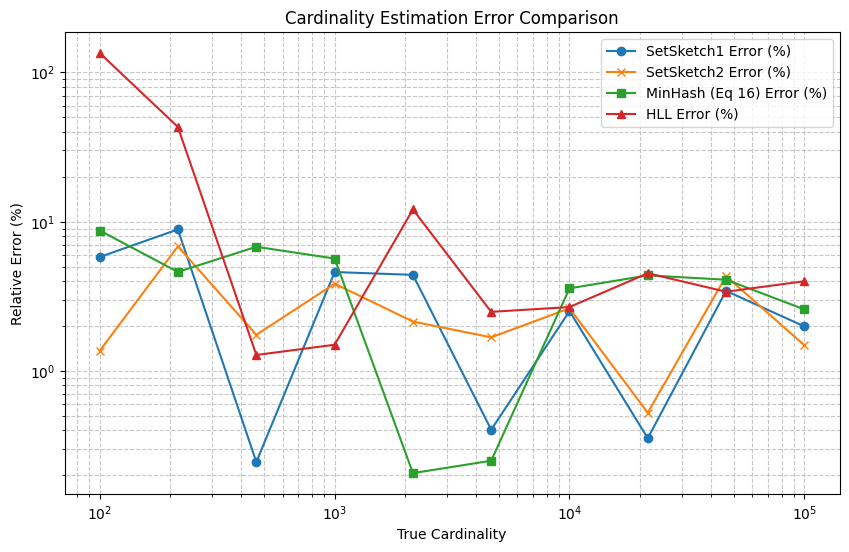


--- 2. Joint Estimation Demo ---
Set A true card: 10000, Set B true card: 8000
True Intersection: 3000, True Union: 15000, True Jaccard: 0.2000
SetSketch Estimated nU: 9056.67, nV: 7863.81

SetSketch Joint Estimation Results (b=1.001):
  Estimated Jaccard: 0.1823
  Estimated Union Size: 14311.21
  Estimated Intersection Size: 2609.26
  (D+:111, D-:98, D0:47)

MinHash Direct Jaccard: 0.2031


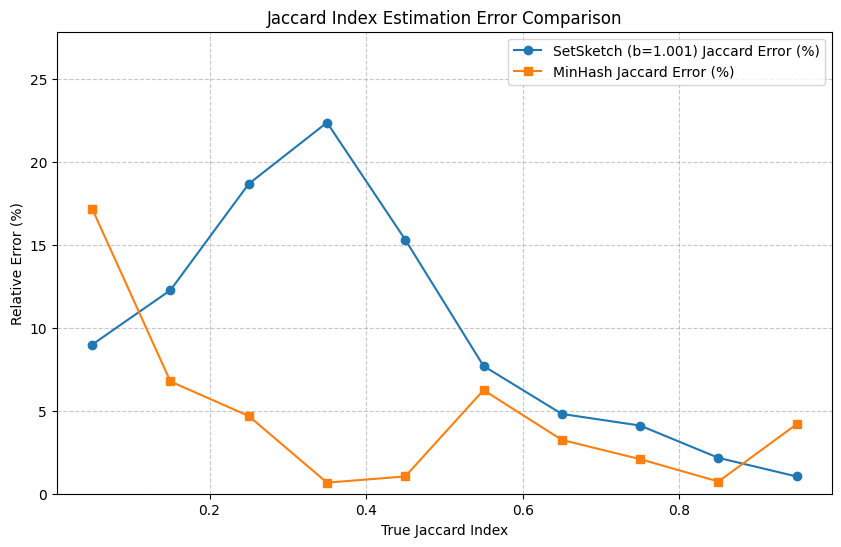


--- End of Demonstration ---


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import random
from scipy.optimize import brentq # For Jaccard estimation in SetSketch
import math

# --- Helper Utilities ---
def get_item_seed(item):
    """
    Generates a seed from an item.
    Using hash() for simplicity. For production, a more robust hash like MurmurHash would be better.
    """
    return hash(item)

# --- SetSketch Implementation ---
class SetSketch:
    """
    Implementation of the SetSketch algorithm as described in
    "SetSketch: Filling the Gap between MinHash and HyperLogLog" (arXiv:2101.00314v3).
    """
    def __init__(self, m, b, a, q, seed=None):
        """
        Initializes the SetSketch.
        Args:
            m (int): Number of registers. [cite: 133]
            b (float): Base for logarithmic scaling (b > 1). [cite: 104]
            a (float): Rate parameter for the exponential distribution (a > 0). [cite: 105]
            q (int): Max register value - 1 (registers store 0 to q+1). [cite: 133]
            seed (int, optional): Seed for master PRNG to make sketch construction deterministic.
        """
        if not (b > 1):
            raise ValueError("Base b must be > 1.")
        if not (a > 0):
            raise ValueError("Rate a must be > 0.")
        if not (m > 0 and isinstance(m, int)):
            raise ValueError("Number of registers m must be a positive integer.")
        if not (q >= 0 and isinstance(q, int)):
            raise ValueError("Parameter q must be a non-negative integer.")

        self.m = m
        self.b = b
        self.a = a
        self.q = q
        
        # K_i are the m integer-valued registers, initialized to 0 [cite: 105]
        self.registers = np.zeros(m, dtype=int)
        self.K_low = 0 # Lower bound of current register state [cite: 105]
        self.w = 0     # Counter for register modifications [cite: 105]
        
        # Master PRNG for things like shuffling indices if consistent behavior across runs is needed
        self._master_prng = random.Random(seed)

    def _get_jth_ordered_exp_hash(self, item_prng, j_order_stat_zero_indexed, method):
        """
        Generates the (j_order_stat_zero_indexed + 1)-th smallest value out of m 
        exponentially distributed random values with rate 'a'.
        This is x_j in the paper (1-indexed for j).
        Args:
            item_prng (random.Random): PRNG seeded by the item.
            j_order_stat_zero_indexed (int): The order statistic to generate (0 for 1st smallest, etc.).
            method (str): 'SetSketch1' or 'SetSketch2'.
        Returns:
            float: The generated exponential value.
        """
        if method == 'SetSketch1':
            # Eq (7): x_j ~ x_{j-1} + (1/(m+1-j)) * Exp(a) where j is 1-indexed
            # For x_0 (0th smallest), this would be (1/(m+1-(0+1)))*Exp(a) = (1/m)*Exp(a) if we start sum from 0
            # The paper refers to Devroye 1986 for exponential spacings.
            # A simpler way to get the k-th order statistic from m i.i.d. Exp(a) is to sum
            # E_1/m + E_2/(m-1) + ... + E_k/(m-k+1) where E_i ~ Exp(a)
            # This implementation simulates this sum incrementally.
            # For the j-th value (1-indexed in paper), it's the sum of j such terms.
            # So, for j_order_stat_zero_indexed, we need previous value + one more term.
            # This is complex to do "incrementally" for the *actual* j-th smallest value if only given j.
            # A common way to generate m ordered exponential variates:
            # E_i ~ Exp(1), then X_i = E_i / a. Ordered X_i can be found by ordering.
            # Or, sum of scaled exponentials:
            # x_1 = Exp(a*m)/m , x_2 = x_1 + Exp(a*(m-1))/(m-1) ... NO, this is not right for order stats.
            # Correct formulation for spacings (1-indexed j):
            # y_1 ~ Exp(a*m), y_2 ~ Exp(a*(m-1)), ..., y_m ~ Exp(a*1)
            # x_j = sum_{l=1 to j} y_l / (a*(m-l+1)) --- NO, this is also not standard order stat gen.
            # Let's use the paper's direct reference to "exponentially distributed spacings [20]"
            # x_j = x_{j-1} + (1/(m+1-j_one_indexed)) * Exp(a) [cite: 121]
            # If we generate ALL m ordered values x_0, ..., x_{m-1} for an item:
            # x_prev = 0
            # ordered_values = []
            # for i in range(self.m):
            #    j_one_idx = i + 1
            #    spacing = item_prng.expovariate(self.a) / (self.m + 1 - j_one_idx)
            #    x_curr = x_prev + spacing
            #    ordered_values.append(x_curr)
            #    x_prev = x_curr
            # return ordered_values[j_order_stat_zero_indexed] 
            # For Algorithm 1, we generate x_j one by one.
            # This means we need to sum up the spacings up to j.

            # Simplified: For this method, we'll generate all m for the item if needed by Algo 1 logic later.
            # For now, let's assume this helper is called to get one specific order statistic.
            # This would require a more complex algorithm if not generating all sequentially.
            # The paper suggests "generate j-th smallest out of m exponentially distributed random values"
            # A standard way: Generate m Exp(a) r.v.s and sort them. Return the j-th.
            # This is O(m log m) or O(m) with selection algorithm.
            # Given Algo 1 tries for O(1) updates, this must be part of the pre-computation for an item
            # or a more clever incremental generation.
            # The paper's reference [20] L. Devroye. 1986. "Uniform and Exponential Spacings"
            # suggests $X_{(j)} = \sum_{i=1}^j \frac{E_i}{a(m-i+1)}$ where $E_i \sim Exp(1)$.
            # We need $x_j$ which is $X_{(j)}$ in Devroye's notation.
            # So to get the j_order_stat_zero_indexed (which is (j_order_stat_zero_indexed+1)-th value), we sum j_order_stat_zero_indexed+1 terms.
            val = 0.0
            for i in range(j_order_stat_zero_indexed + 1):
                val += item_prng.expovariate(self.a) / (self.m - i) # E_i / (m-i+1) if E_i ~ Exp(a)
            return val
            # This is still an approximation or simplification of the true order statistic generation.
            # True generation of j-th order stat from m iid Exp(a) is more complex to do directly.
            # For actual SetSketch1 in Algo 1, you generate x_j from x_{j-1} using Eq (7)
            # We'll implement that logic directly in `add` for SetSketch1 for efficiency.
            # This helper is more conceptual if called in isolation.
            # For this "from scratch" version, let's make `add` handle it.
            raise NotImplementedError("SetSketch1 ordered hash generation is handled in add method directly.")

        elif method == 'SetSketch2':
            # Eq (8): x_j ~ Exp(a; gamma_{j-1}, gamma_j) [cite: 123]
            # gamma_j = (1/a) * log(1 + j_one_indexed / (m - j_one_indexed)) for j_one_indexed in [1, m-1]
            # gamma_0 = 0, gamma_m = infinity
            j_one_idx = j_order_stat_zero_indexed + 1

            if j_one_idx == 0: # Should not happen with zero_indexed >= 0
                 gamma_prev = 0
            elif j_one_idx == 1: # First interval [gamma_0, gamma_1)
                gamma_prev = 0
            else: # j_one_idx > 1
                # Check for m - (j_one_idx - 1) being zero
                if self.m - (j_one_idx - 1) == 0: # This is for gamma_{m} if j_one_idx-1 = m
                     gamma_prev = float('inf') # Should not be used as lower bound normally
                else:
                    gamma_prev = (1/self.a) * math.log(1 + (j_one_idx - 1) / (self.m - (j_one_idx - 1))) if (self.m - (j_one_idx -1)) > 0 else float('inf')


            if j_one_idx == self.m: # Last interval [gamma_{m-1}, gamma_m = inf)
                gamma_curr = float('inf')
            else: # j_one_idx < self.m
                 # Check for m - j_one_idx being zero
                if self.m - j_one_idx == 0:
                    gamma_curr = float('inf') # Should not happen if j_one_idx < m
                else:
                    gamma_curr = (1/self.a) * math.log(1 + j_one_idx / (self.m - j_one_idx))


            # Sample X from Exp(a) truncated to [gamma_prev, gamma_curr]
            # Using inverse transform sampling:
            # F(x) = (P(X < x) - P(X < low)) / (P(X < high) - P(X < low))
            # P(X < x) = 1 - exp(-a*x)
            # F(x) = ( (1-exp(-a*x)) - (1-exp(-a*low)) ) / ( (1-exp(-a*high)) - (1-exp(-a*low)) )
            # F(x) = ( exp(-a*low) - exp(-a*x) ) / ( exp(-a*low) - exp(-a*high) )
            # Let U ~ Uniform(0,1). Set F(x) = U and solve for x.
            # U * (exp(-a*low) - exp(-a*high)) = exp(-a*low) - exp(-a*x)
            # exp(-a*x) = exp(-a*low) - U * (exp(-a*low) - exp(-a*high))
            # -a*x = log( exp(-a*low) - U * (exp(-a*low) - exp(-a*high)) )
            # x = (-1/a) * log( exp(-a*low) - U * (exp(-a*low) - exp(-a*high)) )

            u = item_prng.random() # Uniform (0,1)
            
            exp_a_low = math.exp(-self.a * gamma_prev)
            
            if gamma_curr == float('inf'):
                exp_a_high = 0
            else:
                exp_a_high = math.exp(-self.a * gamma_curr)
            
            try:
                log_arg = exp_a_low - u * (exp_a_low - exp_a_high)
                if log_arg <= 0: # Should be rare if intervals are well-defined
                    # This can happen if gamma_prev is very large, making exp_a_low tiny.
                    # Or if u is very close to 1 and exp_a_high is very close to exp_a_low (narrow interval)
                    # Fallback or re-evaluate interval calculation for robustness
                    # For now, if arg is bad, could return midpoint or prev if interval is tiny.
                    # Let's assume for typical parameters this is okay.
                    # A robust way for Exp(rate, low, high): val = low - math.log(1-u*(1-math.exp(-rate*(high-low))))/rate
                    if gamma_curr == float('inf'): # Special handling for unbounded upper interval
                        return gamma_prev - math.log(1-u) / self.a
                    else: # Bounded interval
                         # Ensure high > low. If not, it's an issue with gamma calcs or j_order_stat
                        if gamma_curr > gamma_prev:
                            return gamma_prev - math.log(1 - u * (1 - math.exp(-self.a * (gamma_curr - gamma_prev)))) / self.a
                        else: # Degenerate interval, return the boundary
                            return gamma_prev

                val = (-1/self.a) * math.log(log_arg)

            except ValueError: # log of non-positive
                # This indicates issue with gamma values or numerical precision
                # Simplified fallback: if interval is tiny, pick boundary. If last interval, sample from Exp(a) > gamma_prev
                if gamma_curr == float('inf'):
                    val = gamma_prev + item_prng.expovariate(self.a) # Approx for X > gamma_prev
                else:
                    val = (gamma_prev + gamma_curr) / 2 # Fallback to midpoint for stability
            return val
        else:
            raise ValueError("Unknown method for ordered hash generation.")

    def add(self, item, method='SetSketch1'):
        """
        Adds an item to the SetSketch using Algorithm 1 from the paper. [cite: 105]
        Args:
            item (hashable): The item to add.
            method (str): 'SetSketch1' or 'SetSketch2'.
        """
        item_seed = get_item_seed(item)
        item_prng = random.Random(item_seed) # PRNG specific to this item

        # Generate a random permutation of register indices for this item [cite: 118, 119]
        # This means the j-th generated k_val (from x_j) will be tried against K[permuted_indices[j]]
        permuted_indices = list(range(self.m))
        item_prng.shuffle(permuted_indices)

        current_x_val_ss1 = 0.0 # For SetSketch1 incremental generation based on Eq (7)

        for j_loop_idx in range(self.m): # Loop m times for m potential updates
            if method == 'SetSketch1':
                # Eq (7): x_j = x_{j-1} + (1/(m+1-j_one_indexed)) * Exp(a) [cite: 121]
                # j_one_indexed for Eq (7) is j_loop_idx + 1
                j_one_indexed_spacing = j_loop_idx + 1
                denominator = self.m + 1 - j_one_indexed_spacing
                if denominator <= 0: # Should not happen if j_loop_idx < m
                    break 
                spacing = item_prng.expovariate(self.a) / denominator
                current_x_val_ss1 += spacing
                x_val = current_x_val_ss1
            elif method == 'SetSketch2':
                # Here j_loop_idx is the order statistic (0 to m-1)
                x_val = self._get_jth_ordered_exp_hash(item_prng, j_loop_idx, 'SetSketch2')
            else:
                raise ValueError("Invalid method specified.")

            if x_val > (self.b ** (-self.K_low)): # x_j > b^(-K_low) [cite: 112]
                break

            # Calculate k value [cite: 105]
            # log_b(x_val) can be -inf if x_val is 0. Ensure x_val > 0.
            if x_val <= 0: k_val = self.q + 1 # Effectively +infinity for 1-log_b(x)
            else: k_val = math.floor(1 - (math.log(x_val) / math.log(self.b)))
            
            k_val = max(0, min(self.q + 1, k_val))

            # Paper's Algo 1 has "if k <= K_low then break" [cite: 105]
            # This is an optimization: if the computed k isn't even greater than the current minimum
            # of *all* registers, it's less likely to update the specific target K_i (which could be > K_low).
            if k_val <= self.K_low:
                 # If we break here, we might miss updates if target_register_idx has a value K_i < k_val but K_low < K_i
                 # The paper's text says "only hash values $h_i(d) \le b^{-K_{low}}$ will be able to alter *any* register."
                 # This K_low check on k_val seems to be an additional heuristic.
                 # Let's follow Algo 1 strictly.
                break 
            
            # Target a register based on the permuted sequence for this item
            target_register_idx = permuted_indices[j_loop_idx]
            
            if k_val > self.registers[target_register_idx]:
                self.registers[target_register_idx] = k_val
                self.w += 1
        
        if self.w >= self.m: # [cite: 130]
            self.K_low = int(np.min(self.registers)) # K_low is min of current state [cite: 130]
            self.w = 0

    def merge(self, other_sketch):
        """
        Merges another SetSketch into this one. [cite: 102]
        The state becomes the element-wise maximum of the registers.
        Args:
            other_sketch (SetSketch): Another SetSketch instance.
        """
        if self.m != other_sketch.m or self.b != other_sketch.b or \
           self.a != other_sketch.a or self.q != other_sketch.q:
            raise ValueError("SetSketches must have identical parameters to be merged.")
        
        self.registers = np.maximum(self.registers, other_sketch.registers)
        self.K_low = int(np.min(self.registers)) # Recompute K_low after merge
        # self.w is not clearly defined for merges, often reset or ignored if sketches are "finalized" before merge.
        # For simplicity, let's reset w, assuming merge is a significant event.
        self.w = 0 

    def estimate_cardinality(self):
        """
        Estimates the cardinality of the set represented by the sketch.
        Uses Equation (12) from the paper. [cite: 156]
        $\hat{n} = \frac{m(1-1/b)}{a \ln(b) \sum_{i=1}^{m} b^{-K_i}}$
        """
        if self.a == 0 or math.log(self.b) == 0: return float('nan') # Avoid division by zero
        
        sum_b_neg_K_i = np.sum(self.b ** (-self.registers.astype(float))) # Cast to float for exponentiation
        
        if sum_b_neg_K_i == 0: return float('inf') # Or handle as very large cardinality

        numerator = self.m * (1 - (1/self.b))
        denominator = self.a * math.log(self.b) * sum_b_neg_K_i
        
        if denominator == 0: return float('inf') # Or a very large number
        return numerator / denominator

    def _p_b(self, x_val):
        """ Helper function p_b(x) for joint estimation [cite: 176] """
        # p_b(x) = -log_b(1 - x * (b-1)/b)
        arg = 1 - x_val * (self.b - 1) / self.b
        if arg <= 1e-9: # Avoid log(0 or negative)
            # This happens if x_val * (b-1)/b is close to 1.
            # p_b(x) approaches infinity. For numerical stability, return a large number.
            # The domain for x_val in p_b(u-vJ) or p_b(v-uJ) is [0, max_val < 1/( (b-1)/b ) = b/(b-1) ]
            # Effectively, for J in valid range, x_val should be < 1 if b > 1.
            # So (1-x*(b-1)/b) should be > 0.
            # If x is close to b/(b-1), then arg -> 0.
            # If x=1 (e.g. J=0, u=1), then arg = 1 - (b-1)/b = 1/b. p_b(1) = -log_b(1/b) = 1.
            return 1000 # A large number to signify this
        return -math.log(arg) / math.log(self.b)

    def estimate_joint_quantities(self, other_sketch, n_U_est=None, n_V_est=None):
        """
        Estimates joint quantities (Jaccard, Union, Intersection) between this sketch (U)
        and another sketch (V). Uses the ML method for J from Section 3.2. [cite: 178]
        Args:
            other_sketch (SetSketch): The other SetSketch instance (V).
            n_U_est (float, optional): Estimated cardinality of this sketch (U). If None, uses self.estimate_cardinality().
            n_V_est (float, optional): Estimated cardinality of other_sketch (V). If None, uses other_sketch.estimate_cardinality().
        Returns:
            dict: Jaccard, Union Size, Intersection Size, or None if estimation fails.
        """
        if self.m != other_sketch.m or self.b != other_sketch.b or \
           self.a != other_sketch.a or self.q != other_sketch.q:
            raise ValueError("SetSketches must have identical parameters for joint estimation.")

        if n_U_est is None:
            n_U_est = self.estimate_cardinality()
        if n_V_est is None:
            n_V_est = other_sketch.estimate_cardinality()

        if n_U_est <= 0 or n_V_est <= 0 or n_U_est + n_V_est == 0 : # Avoid division by zero or nonsensical inputs
            print("Warning: Non-positive estimated cardinalities for joint estimation. U_est:",n_U_est,"V_est:",n_V_est)
            return {'jaccard': 0, 'union_size': n_U_est + n_V_est, 'intersection_size': 0, 'D_plus':0,'D_minus':0,'D_zero':0}


        D_plus = 0
        D_minus = 0
        D_zero = 0
        for k_u, k_v in zip(self.registers, other_sketch.registers):
            if k_u > k_v:
                D_plus += 1
            elif k_u < k_v:
                D_minus += 1
            else:
                D_zero += 1
        
        # Relative cardinalities u, v
        # Handle potential n_U_est + n_V_est == 0 if cardinalities are tiny and estimated as 0
        sum_n_uv = n_U_est + n_V_est
        if sum_n_uv == 0: # Both sets estimated empty
             return {'jaccard': 0 if D_zero < self.m else 1, # If all registers equal (and 0), could be J=1 for empty sets
                    'union_size': 0, 'intersection_size': 0, 
                    'D_plus':D_plus,'D_minus':D_minus,'D_zero':D_zero}


        u_rel = n_U_est / sum_n_uv
        v_rel = n_V_est / sum_n_uv

        # Log-Likelihood function for J (to be maximized, or its negative minimized)
        # logL(J) = D+log(p_b(u-vJ)) + D-log(p_b(v-uJ)) + D0log(1-p_b(u-vJ)-p_b(v-uJ)) [cite: 178]
        def neg_log_likelihood(J):
            # J must be in [0, min(nU/nV, nV/nU)]
            # which means J <= min(u_rel/v_rel, v_rel/u_rel)
            # Ensure arguments to p_b are >= 0
            arg1 = u_rel - v_rel * J
            arg2 = v_rel - u_rel * J

            if arg1 < -1e-9 or arg2 < -1e-9: # J is out of feasible range
                return float('inf') # Penalize heavily
            
            arg1 = max(0, arg1) # Clip to 0
            arg2 = max(0, arg2)

            pb_arg1 = self._p_b(arg1)
            pb_arg2 = self._p_b(arg2)
            
            log_term1 = D_plus * math.log(pb_arg1 + 1e-9) if D_plus > 0 and pb_arg1 > -1e-9 else 0
            log_term2 = D_minus * math.log(pb_arg2 + 1e-9) if D_minus > 0 and pb_arg2 > -1e-9 else 0
            
            p0_approx = 1 - pb_arg1 - pb_arg2
            if p0_approx <= 1e-9: # If p0 is zero or negative
                log_term3 = -float('inf') if D_zero > 0 else 0 # Penalize if D_zero expects non-zero prob
            else:
                log_term3 = D_zero * math.log(p0_approx) if D_zero > 0 else 0
            
            return -(log_term1 + log_term2 + log_term3)

        # Optimize for J. Max J is min(nU/nV, nV/nU). For u,v, it's min(u/v, v/u).
        # If v_rel or u_rel is zero (but sum_n_uv is not), implies one set is empty.
        if v_rel == 0 : # n_V_est is 0
            max_J = 0 # J must be 0
        elif u_rel == 0: # n_U_est is 0
            max_J = 0 # J must be 0
        else:
            max_J = min(u_rel / v_rel, v_rel / u_rel, 1.0) # J is also <= 1

        max_J = min(max_J, 1.0 - 1e-6) # Ensure search range is slightly within [0,1)
        min_J = 1e-6

        if max_J <= min_J: # Handles cases like one set being empty or estimates being problematic
            if D_zero == self.m : J_est = 1.0 # If all registers are same, likely J=1 (identical sets)
            elif D_plus + D_minus + D_zero == self.m and D_zero == 0 and (D_plus == 0 or D_minus == 0): J_est = 0.0 # Heuristic if clearly disjoint
            else: J_est = 0.0 # Fallback if no overlap or one set empty. Max_J could be 0.
        else:
            try:
                # Brent's method is mentioned in the paper [cite: 179]
                # It needs a bracket [min_J, max_J] where function values at ends have opposite signs.
                # neg_log_likelihood is what we minimize.
                # For ML, we maximize. For minimization, we look for a minimum.
                # Scipy's brentq finds roots. We need to find root of derivative or use minimize_scalar.
                # Let's use minimize_scalar for simplicity.
                from scipy.optimize import minimize_scalar
                # Ensure bounds are valid and distinct
                bounds_J = (min_J, max_J)
                if bounds_J[0] >= bounds_J[1]:
                    bounds_J = (0, max(1e-6, max_J)) # Fallback bounds

                res = minimize_scalar(neg_log_likelihood, bounds=bounds_J, method='bounded')
                J_est = res.x
            except Exception as e:
                # Fallback if optimization fails, e.g. use inclusion-exclusion or naive D0/m
                # print(f"Warning: Jaccard optimization failed: {e}. Using D0/m fallback.")
                # J_est = D_zero / self.m
                # For now, signal failure more clearly or provide a more robust fallback.
                # A simple fallback for J if optimization fails:
                if D_zero == self.m: J_est = 1.0
                elif D_plus > D_minus and n_V_est > 0 : J_est = min(1.0, (n_U_est - n_V_est + D_zero * (n_U_est+n_V_est)/self.m)/(n_U_est + D_minus*(n_U_est+n_V_est)/self.m ) ) # very heuristic
                elif D_minus > D_plus and n_U_est > 0 : J_est = min(1.0, (n_V_est - n_U_est + D_zero * (n_U_est+n_V_est)/self.m)/(n_V_est + D_plus*(n_U_est+n_V_est)/self.m ) ) # very heuristic
                else: J_est = D_zero / self.m # Basic MinHash-like J from D0
                J_est = np.clip(J_est, 0, 1.0)


        J_est = np.clip(J_est, 0, 1.0)

        # Derived quantities [cite: 168]
        if 1 + J_est == 0: # Avoid division by zero
            union_size_est = n_U_est + n_V_est # Fallback
            intersection_size_est = 0
        else:
            union_size_est = (n_U_est + n_V_est) / (1 + J_est)
            intersection_size_est = union_size_est * J_est
            # intersection_size_est = (n_U_est + n_V_est) * J_est / (1 + J_est) # Alternative form

        return {
            'jaccard': J_est,
            'union_size': union_size_est,
            'intersection_size': intersection_size_est,
            'n_U_est': n_U_est,
            'n_V_est': n_V_est,
            'D_plus': D_plus,
            'D_minus': D_minus,
            'D_zero': D_zero
        }

    def __str__(self):
        return (f"SetSketch(m={self.m}, b={self.b}, a={self.a}, q={self.q}, "
                f"K_low={self.K_low}, w={self.w}\n"
                f"Registers: {self.registers[:10]}... (first 10 shown))")

# --- Simplified MinHash Implementation ---
class MinHash:
    def __init__(self, num_hashes, seed=None):
        self.num_hashes = num_hashes
        self.minhash_values = np.full(num_hashes, float('inf'))
        # Create num_hashes independent hash functions (simulated by PRNGs with different seeds)
        self._master_prng = random.Random(seed)
        self.hash_seeds = [self._master_prng.getrandbits(32) for _ in range(num_hashes)]
        self.prngs = [random.Random(s) for s in self.hash_seeds]

    def add(self, item):
        item_val_for_hash = get_item_seed(item) # Use the same way to get a number from item
        for i in range(self.num_hashes):
            # Simulate a hash function h_i(item) producing a uniform value
            # For simplicity, re-seed prng_i with item_val_for_hash to get a item-specific value for h_i
            current_prng = random.Random(item_val_for_hash + self.hash_seeds[i]) # Combine item hash with func hash
            hash_val = current_prng.getrandbits(64) # Large enough range
            if hash_val < self.minhash_values[i]:
                self.minhash_values[i] = hash_val
    
    def jaccard(self, other_minhash):
        if self.num_hashes != other_minhash.num_hashes:
            raise ValueError("MinHash sketches must have the same number of hash functions.")
        return np.sum(self.minhash_values == other_minhash.minhash_values) / self.num_hashes

    def estimate_cardinality_paper_eq16(self):
        """ Estimates cardinality using Eq. (16) from SetSketch paper[cite: 208].
            K_i' are normalized minhash values in [0,1).
            Assumes minhash_values are integers, needs normalization.
            This formula is for K_i' ~ Uniform(0,1). 
            If minhash values are large integers, this is not directly applicable.
            A more common MinHash cardinality estimator is m/kth_smallest_value - 1,
            or from E[kth value] = k/(n+1).
            Paper Eq 16 is: $\hat{n} = m / (\sum -log(1-K_i'))$. K_i' are normalized minhash values.
            Typically K_i' = h_i(x) / MAX_HASH_VAL.
            For this simplified version, let's use a more common one if Eq 16 is hard to apply directly.
            Let's try to apply Eq 16 by normalizing (assuming max hash is 2^64 -1).
        """
        MAX_HASH_VAL = 2**64 -1
        # Filter out uninitialized (inf) values, should not happen if set is non-empty
        valid_hashes = self.minhash_values[self.minhash_values != float('inf')]
        if len(valid_hashes) == 0: return 0
        
        K_prime = valid_hashes / MAX_HASH_VAL
        K_prime = np.clip(K_prime, 1e-9, 1.0 - 1e-9) # Avoid log(0) or log(negative)
        
        sum_log_terms = np.sum(-np.log(1 - K_prime))
        if sum_log_terms == 0: return float('inf')
        return len(valid_hashes) / sum_log_terms # Use len(valid_hashes) for m in formula if some weren't updated


# --- Simplified HyperLogLog (GHLL variant) Implementation ---
class HyperLogLog:
    def __init__(self, m_bits, b_base=2, seed=None): # m_bits determines m = 2^m_bits
        self.p = m_bits # Precision parameter in HLL terminology (p in paper, m_bits here)
        self.m = 1 << m_bits # Number of registers
        self.b_base = b_base # Base for GHLL, b=2 for standard HLL [cite: 70, 71]
        self.registers = np.zeros(self.m, dtype=int)
        self._master_prng = random.Random(seed)
        self.hash_seed_hll = self._master_prng.getrandbits(32) # For splitting hash

    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        
        # Simulate a single good 64-bit hash function
        # For simplicity, use a PRNG seeded by item and a global HLL seed
        prng = random.Random(item_val_for_hash + self.hash_seed_hll)
        hash_val_64bit = prng.getrandbits(64)
        
        # Use first p bits for register index (stochastic averaging style) [cite: 72]
        register_index = hash_val_64bit & (self.m - 1) # Equivalent to hash_val_64bit % self.m if m is power of 2
                                                       # Or use hash_val_64bit >> (64 - self.p)

        # The rest for value h_2(d) ~ Uniform(0,1) [cite: 72]
        # And then compute 1 - log_b(h_2(d))
        # For simplicity, let's map the remaining bits to a pseudo-float in (0,1)
        # Or use rho(w) style (number of leading zeros) if b_base=2 for standard HLL
        
        if self.b_base == 2: # Standard HLL uses leading zeros
            # Use remaining bits (e.g., 64-p bits) to count leading zeros
            # shift_amount = self.p
            # relevant_bits = hash_val_64bit >> shift_amount
            # max_val_relevant = (1 << (64 - shift_amount)) -1
            # if relevant_bits == 0 : value_for_update = 64 - shift_amount + 1 # All zeros
            # else: value_for_update = self._count_leading_zeros(relevant_bits, 64 - shift_amount) + 1
            
            # Simpler: map hash_val_64bit to float (0,1) for general GHLL definition
            # K_i = max(K_i, floor(1 - log_b h_i(d))) with h_i(d) ~ Uniform(0,1) [cite: 68] (non-stochastic averaging HLL)
            # For stochastic averaging: K_idx = max(K_idx, floor(1 - log_b h2(d)))
            
            h2_d_int = hash_val_64bit >> self.p # Use upper bits for value part
            # Normalize to (0,1) - avoid 0 for log
            h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p)) # Add 0.5 to avoid exact 0
            if h2_d_float == 0: h2_d_float = 1e-9 # avoid log(0)
            
            val_to_calc = 1 - (math.log(h2_d_float) / math.log(self.b_base))
            update_value = math.floor(val_to_calc)
            update_value = max(1, update_value) # HLL values are typically >= 1 (rho output)
                                                # Original paper defines K_i=0 for init [cite: 69]
                                                # This implies update values should also be possibly 0 or more.
                                                # Let's use floor(1 - log_b h(d)) which can be <=0, then clamp

        else: # General GHLL base
            h2_d_int = hash_val_64bit >> self.p
            h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p))
            if h2_d_float == 0: h2_d_float = 1e-9
            val_to_calc = 1 - (math.log(h2_d_float) / math.log(self.b_base))
            update_value = math.floor(val_to_calc)
        
        update_value = max(0, update_value) # As SetSketch registers start at 0 and are non-negative

        if update_value > self.registers[register_index]:
            self.registers[register_index] = update_value

    def _count_leading_zeros(self, val, max_bits):
        """Helper for standard HLL rho(w)"""
        lz = 0
        for i in range(max_bits -1, -1, -1):
            if (val >> i) & 1: # Found first 1
                break
            lz +=1
        return lz

    def estimate_cardinality(self, a_param_for_setsketch_formula=None):
        """
        Estimates cardinality.
        For GHLL, can use SetSketch Eq. (12) with a=1/m[cite: 214, 215].
        Or, the standard HLL estimator. Here we use the SetSketch-like one.
        """
        if a_param_for_setsketch_formula is None:
            a_hll = 1.0 / self.m # As suggested by paper for GHLL [cite: 214]
        else:
            a_hll = a_param_for_setsketch_formula

        if a_hll == 0 or math.log(self.b_base) == 0: return float('nan')
        
        sum_b_neg_K_i = np.sum(self.b_base ** (-self.registers.astype(float)))
        
        if sum_b_neg_K_i == 0: return float('inf')

        numerator = self.m * (1 - (1/self.b_base))
        denominator = a_hll * math.log(self.b_base) * sum_b_neg_K_i
        
        if denominator == 0: return float('inf')
        
        # Standard HLL harmonic mean based estimator (simplified)
        # alpha_m = 0.7213 / (1 + 1.079 / self.m) # for b=2
        # raw_est = alpha_m * self.m**2 / np.sum(2.0**(-self.registers))
        # Basic SetSketch-like estimator:
        card_est = numerator / denominator

        # HLL corrections for small/large range are complex.
        # Using simplified form from paper (Eq 18) is also complex due to sigma/tau.
        # For now, this gives the raw estimate based on SetSketch similarity.
        # Small range correction (if many zeros):
        V = np.sum(self.registers == 0) # count of zero registers
        if V > 0 and card_est < 2.5 * self.m : # Heuristic from HLL paper for when to apply linear counting
             # LinearCounting: m * log(m/V)
             if V > 0: # Avoid log(inf)
                 card_est_lc = self.m * math.log(self.m / V)
                 # Only use LC if it's better (typically for very small cardinalities)
                 if card_est > 2.5 * self.m or card_est < 0 : # If main est is bad or large
                     card_est = card_est_lc
        return card_est

# --- Main Demonstration Script ---
if __name__ == '__main__':
    print("--- SetSketch Algorithm Demonstration ---")

    # --- Parameters ---
    m_registers = 256  # Number of registers [cite: 135] (e.g., m=256 or 4096)
    b_param = 1.001    # Base b, close to 1 for MinHash-like behavior [cite: 135]
    # b_param = 2.0    # Base b, for HLL-like behavior
    a_param = 20       # Rate 'a' [cite: 139]
    q_param = 2**16 - 2 # Max register value q (for 2-byte registers) [cite: 143]
    
    print(f"SetSketch Parameters: m={m_registers}, b={b_param}, a={a_param}, q={q_param}\n")

    # --- 1. Cardinality Estimation Demo ---
    print("--- 1. Cardinality Estimation Demo ---")
    set_A_cardinality = 10000
    set_A_items = {f"item_A_{i}" for i in range(set_A_cardinality)}

    ss_A_s1 = SetSketch(m_registers, b_param, a_param, q_param, seed=42)
    ss_A_s2 = SetSketch(m_registers, b_param, a_param, q_param, seed=42) # Same seed for item generation if needed
    
    mh_A = MinHash(num_hashes=m_registers, seed=42) # Use m for MinHash for somewhat comparable memory
    hll_A = HyperLogLog(m_bits=int(np.log2(m_registers)), b_base=2, seed=42) # m=2^m_bits for HLL

    for item in set_A_items:
        ss_A_s1.add(item, method='SetSketch1')
        ss_A_s2.add(item, method='SetSketch2')
        mh_A.add(item)
        hll_A.add(item)

    est_card_A_s1 = ss_A_s1.estimate_cardinality()
    est_card_A_s2 = ss_A_s2.estimate_cardinality()
    est_card_A_mh = mh_A.estimate_cardinality_paper_eq16() # Using paper's Eq 16
    est_card_A_hll = hll_A.estimate_cardinality()

    print(f"Set A (True Cardinality: {set_A_cardinality}):")
    print(f"  SetSketch1 Estimated Cardinality: {est_card_A_s1:.2f} (Error: {abs(est_card_A_s1 - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  SetSketch2 Estimated Cardinality: {est_card_A_s2:.2f} (Error: {abs(est_card_A_s2 - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  MinHash (Eq 16) Est. Cardinality: {est_card_A_mh:.2f} (Error: {abs(est_card_A_mh - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    print(f"  HLL Estimated Cardinality: {est_card_A_hll:.2f} (Error: {abs(est_card_A_hll - set_A_cardinality)/set_A_cardinality*100:.2f}%)")
    # print(f"  SetSketch1 K_low: {ss_A_s1.K_low}, w: {ss_A_s1.w}")
    # print(f"  SetSketch1 Registers (first 10): {ss_A_s1.registers[:10]}")

    # --- Plot: Cardinality Estimation Error vs True Cardinality (Conceptual) ---
    true_cardinalities = np.logspace(2, 5, 10, dtype=int) # 100 to 100,000
    ss1_errors, ss2_errors, mh_errors, hll_errors = [], [], [], []

    for card in true_cardinalities:
        items = {f"item_plot_{i}" for i in range(card)}
        
        temp_ss1 = SetSketch(m_registers, b_param, a_param, q_param, seed=123)
        temp_ss2 = SetSketch(m_registers, b_param, a_param, q_param, seed=123)
        temp_mh = MinHash(num_hashes=m_registers, seed=123)
        temp_hll = HyperLogLog(m_bits=int(np.log2(m_registers)), b_base=2, seed=123)
        
        for item in items:
            temp_ss1.add(item, 'SetSketch1')
            temp_ss2.add(item, 'SetSketch2')
            temp_mh.add(item)
            temp_hll.add(item)
            
        ss1_errors.append(abs(temp_ss1.estimate_cardinality() - card) / card * 100)
        ss2_errors.append(abs(temp_ss2.estimate_cardinality() - card) / card * 100)
        mh_errors.append(abs(temp_mh.estimate_cardinality_paper_eq16() - card) / card * 100 if card > 0 else 0)
        hll_errors.append(abs(temp_hll.estimate_cardinality() - card) / card * 100)

    plt.figure(figsize=(10,6))
    plt.plot(true_cardinalities, ss1_errors, marker='o', label='SetSketch1 Error (%)')
    plt.plot(true_cardinalities, ss2_errors, marker='x', label='SetSketch2 Error (%)')
    plt.plot(true_cardinalities, mh_errors, marker='s', label='MinHash (Eq 16) Error (%)')
    plt.plot(true_cardinalities, hll_errors, marker='^', label='HLL Error (%)')
    plt.xscale('log')
    plt.yscale('log') # Often error is plotted on log scale if it varies widely
    plt.xlabel('True Cardinality')
    plt.ylabel('Relative Error (%)')
    plt.title('Cardinality Estimation Error Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.show()

    # --- 2. Joint Estimation Demo ---
    print("\n--- 2. Joint Estimation Demo ---")
    set_B_cardinality = 8000
    overlap_cardinality = 3000
    
    set_A_items = {f"item_shared_{i}" for i in range(overlap_cardinality)} | \
                  {f"item_A_only_{i}" for i in range(set_A_cardinality - overlap_cardinality)}
    set_B_items = {f"item_shared_{i}" for i in range(overlap_cardinality)} | \
                  {f"item_B_only_{i}" for i in range(set_B_cardinality - overlap_cardinality)}

    true_nU = len(set_A_items)
    true_nV = len(set_B_items)
    true_intersection = len(set_A_items.intersection(set_B_items))
    true_union = len(set_A_items.union(set_B_items))
    true_jaccard = true_intersection / true_union if true_union > 0 else 0

    print(f"Set A true card: {true_nU}, Set B true card: {true_nV}")
    print(f"True Intersection: {true_intersection}, True Union: {true_union}, True Jaccard: {true_jaccard:.4f}")

    ss_A_joint = SetSketch(m_registers, b_param, a_param, q_param, seed=100)
    ss_B_joint = SetSketch(m_registers, b_param, a_param, q_param, seed=200) # Different seeds for sketch content
    
    SHARED_MH_SEED_DEMO = 101 # Use a constant seed here too

    mh_A_joint = MinHash(num_hashes=m_registers, seed=SHARED_MH_SEED_DEMO)
    mh_B_joint = MinHash(num_hashes=m_registers, seed=SHARED_MH_SEED_DEMO)

    for item in set_A_items:
        ss_A_joint.add(item, method='SetSketch1') # Using SetSketch1 for this demo
        mh_A_joint.add(item)
    for item in set_B_items:
        ss_B_joint.add(item, method='SetSketch1')
        mh_B_joint.add(item)

    # Estimate individual cardinalities first
    nU_est_ss = ss_A_joint.estimate_cardinality()
    nV_est_ss = ss_B_joint.estimate_cardinality()

    print(f"SetSketch Estimated nU: {nU_est_ss:.2f}, nV: {nV_est_ss:.2f}")

    joint_results_ss = ss_A_joint.estimate_joint_quantities(ss_B_joint, nU_est_ss, nV_est_ss)
    jaccard_mh = mh_A_joint.jaccard(mh_B_joint)
    
    print(f"\nSetSketch Joint Estimation Results (b={b_param}):")
    if joint_results_ss:
        print(f"  Estimated Jaccard: {joint_results_ss['jaccard']:.4f}")
        print(f"  Estimated Union Size: {joint_results_ss['union_size']:.2f}")
        print(f"  Estimated Intersection Size: {joint_results_ss['intersection_size']:.2f}")
        print(f"  (D+:{joint_results_ss['D_plus']}, D-:{joint_results_ss['D_minus']}, D0:{joint_results_ss['D_zero']})")
    
    print(f"\nMinHash Direct Jaccard: {jaccard_mh:.4f}")
    
    # --- Plot: Jaccard Estimation Error (Conceptual) ---
    true_jaccards = np.linspace(0.05, 0.95, 10)
    ss_j_errors, mh_j_errors = [], []
    base_set_size = 5000

    for tj_idx, tj in enumerate(true_jaccards):
        overlap = int(base_set_size * tj / (1+tj)) # N_intersect = N_union * J
                                                    # N_union = N_A + N_B - N_intersect
                                                    # N_A = N_B = (N_union + N_intersect)/2
                                                    # N_A = N_B = base_set_size/2 makes things complex.
                                                    # Let N_A_only = N_B_only = base_set_size * (1-tj)/2
                                                    # N_intersect = base_set_size * tj
        
        # Simplified generation:
        # N_union = base_set_size
        # N_intersect = N_union * tj
        # N_A_only = (N_union - N_intersect) / 2 # Assuming symmetric differences
        # N_B_only = (N_union - N_intersect) / 2
        # N_A = N_A_only + N_intersect
        # N_B = N_B_only + N_intersect
        
        # To ensure varying J with reasonable sets:
        # Fix |A| = base_set_size, |B| = base_set_size
        # |A int B| = J * (|A| + |B| - |A int B|) => |A int B| * (1+J) = J * (|A|+|B|)
        # => |A int B| = J * (|A|+|B|) / (1+J)
        n_intersect = int(tj * (base_set_size + base_set_size) / (1 + tj))
        n_A_only = base_set_size - n_intersect
        n_B_only = base_set_size - n_intersect

        items_A_plot = {f"common_{i}" for i in range(n_intersect)} | \
                       {f"A_plot_{i}" for i in range(n_A_only)}
        items_B_plot = {f"common_{i}" for i in range(n_intersect)} | \
                       {f"B_plot_{i}" for i in range(n_B_only)}

        temp_ssA = SetSketch(m_registers, b_param, a_param, q_param, seed=42+tj_idx)
        temp_ssB = SetSketch(m_registers, b_param, a_param, q_param, seed=142+tj_idx)
        SHARED_MH_SEED = 42
        temp_mhA = MinHash(num_hashes=m_registers, seed=SHARED_MH_SEED)
        temp_mhB = MinHash(num_hashes=m_registers, seed=SHARED_MH_SEED)

        for item in items_A_plot: temp_ssA.add(item); temp_mhA.add(item)
        for item in items_B_plot: temp_ssB.add(item); temp_mhB.add(item)
            
        est_j_ss = temp_ssA.estimate_joint_quantities(temp_ssB)['jaccard']
        est_j_mh = temp_mhA.jaccard(temp_mhB)
        
        ss_j_errors.append(abs(est_j_ss - tj) / tj * 100 if tj > 0 else 0)
        mh_j_errors.append(abs(est_j_mh - tj) / tj * 100 if tj > 0 else 0)

    plt.figure(figsize=(10,6))
    plt.plot(true_jaccards, ss_j_errors, marker='o', label=f'SetSketch (b={b_param}) Jaccard Error (%)')
    plt.plot(true_jaccards, mh_j_errors, marker='s', label='MinHash Jaccard Error (%)')
    plt.xlabel('True Jaccard Index')
    plt.ylabel('Relative Error (%)')
    plt.title('Jaccard Index Estimation Error Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.ylim(bottom=0, top=max(max(ss_j_errors, default=1), max(mh_j_errors, default=1))*1.2 + 1) # Ensure y starts at 0 if errors are small
    plt.show()

    print("\n--- End of Demonstration ---")

## Exact application !!! perfect

--- SetSketch Algorithm Demonstration ---
Common Parameters: m=256, a=20, q=65534
SetSketch (MinHash-like): b=1.001
SetSketch (HLL-like): b=2.0
HyperLogLog: b_base=2.0

--- 1. Cardinality Estimation Demo (Single Run) ---
Set A (True Cardinality: 1000):
  SetSketch1 (b=1.001) Est. Card: 973.93
  SetSketch2 (b=1.001) Est. Card: 984.41
  MinHash (Eq16) Est. Card: 976.77
  HLL (b_base=2.0) Est. Card: 1029.19

--- Plotting Cardinality Estimation Error & Theoretical RMSE (m=256) ---


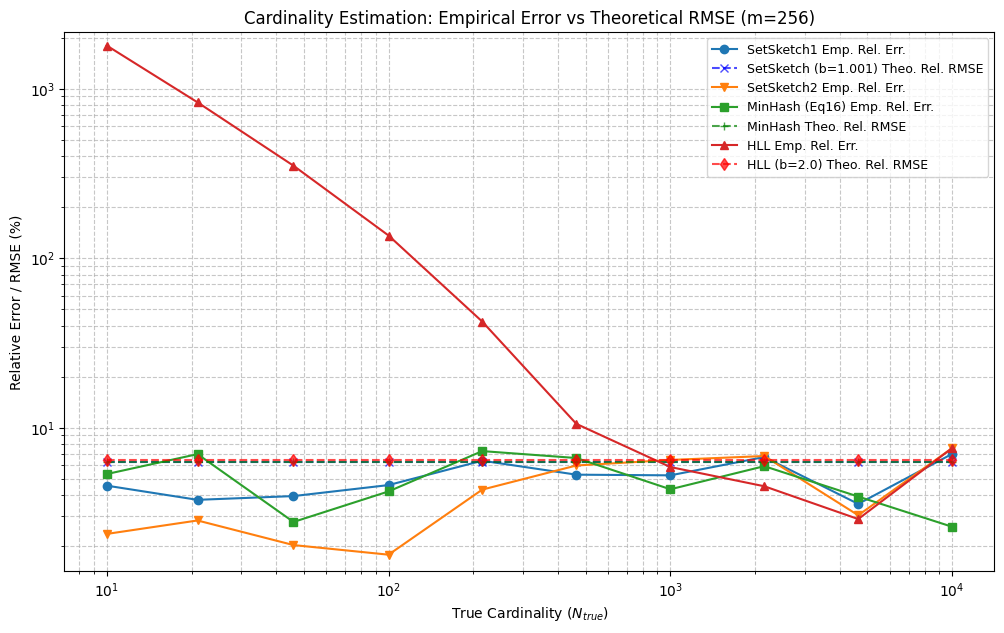


--- 2. Joint Estimation Demo (Single Run) ---
True Jaccard (demo): 0.2000
SetSketch (b=1.001) Est. Jaccard: 0.1855
MinHash Est. Jaccard: 0.2383

--- Plotting Jaccard Estimation Error & Theoretical RMSE (m=256, b=1.001) ---


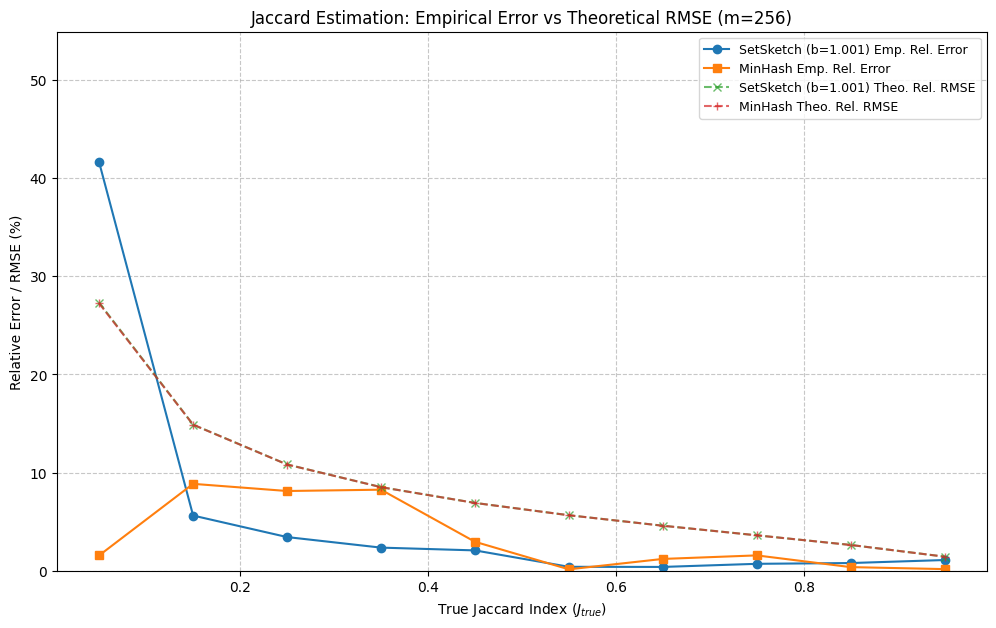


--- Replicating Paper's Figure 2 (Relative Theoretical RMSEs) ---


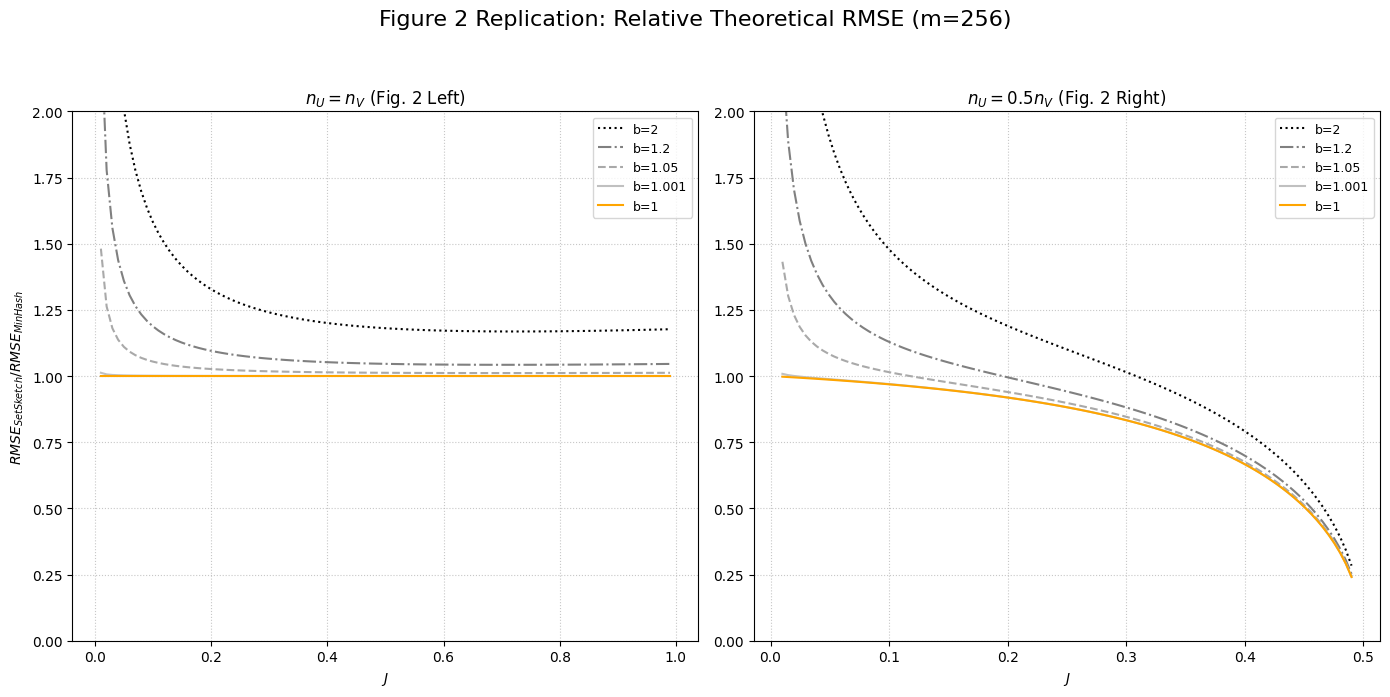


--- Replicating Paper's Figure 3 (Collision Probability Bounds) ---


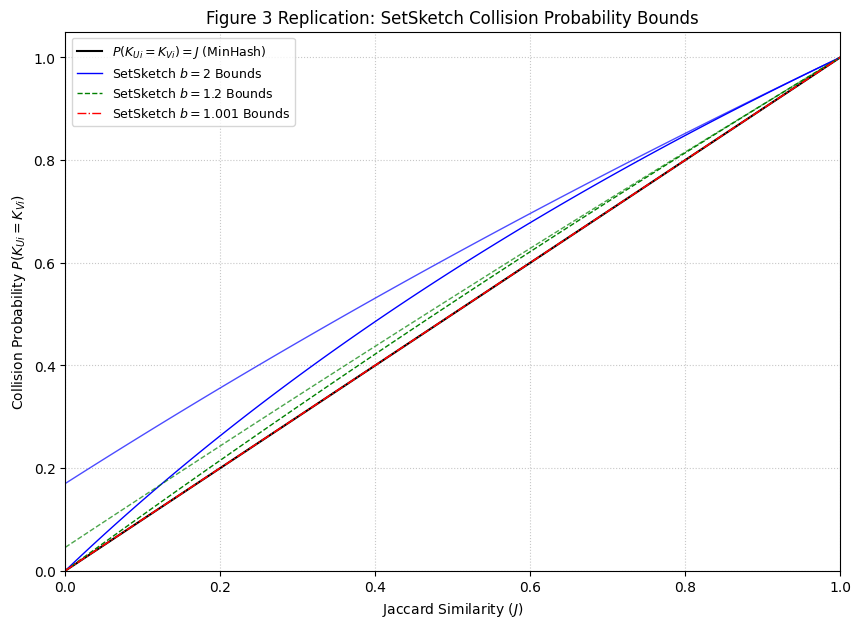


--- Replicating Paper's Figure 4 (RMSE of J_up estimator) ---


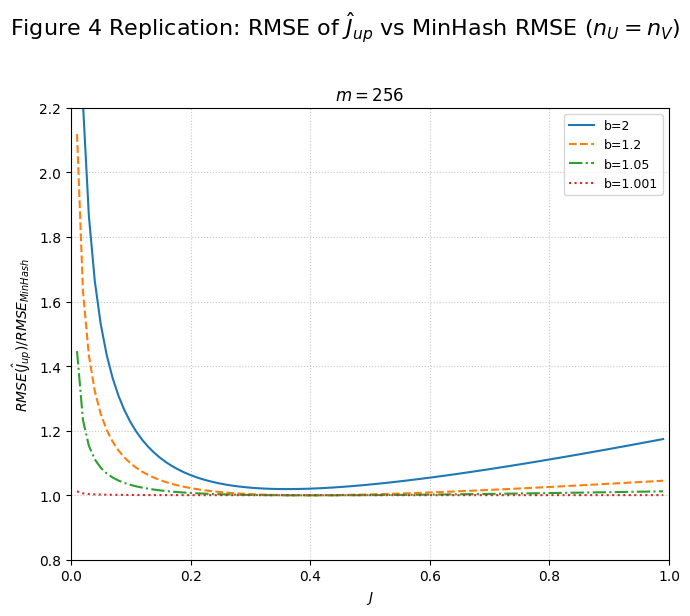


--- End of Demonstration ---


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize_scalar
import math

# --- Helper Utilities ---
def get_item_seed(item):
    """Generates a seed from an item."""
    return hash(item)

def log_b_np(x, b_val): # Numpy-aware log_b for array inputs
    """Calculates log base b for numpy arrays, handling edge cases."""
    x_safe = np.maximum(x, 1e-300) # Avoid log(0)
    b_log_safe = np.log(b_val)
    if b_log_safe == 0: return np.full_like(x_safe, float('inf')) # Avoid division by zero if b=1
    return np.log(x_safe) / b_log_safe

# --- Theoretical Calculation Helper Functions ---
def p_b_theoretical(x, b_val):
    """
    Theoretical p_b(x) = -log_b(1 - x * (b-1)/b) from SetSketch paper.
    Handles numpy arrays and edge cases for numerical stability.
    """
    if b_val == 1: return np.maximum(0, np.asarray(x)) # As b->1, p_b(x) -> x
    
    x_arr = np.asarray(x)
    arg = 1 - x_arr * (b_val - 1) / b_val
    
    # p_b(x) is defined for arg > 0. If arg is near 0, p_b(x) -> infinity.
    # x * (b-1)/b < 1  => x < b/(b-1)
    # For Jaccard context, x (like u-vJ) is usually in [0,1].
    # If x=1, arg = 1/b. If x=0, arg=1.
    arg = np.maximum(arg, 1e-9) # Clip to avoid log(0) or log(negative)
    
    log_b_val = np.log(b_val)
    if log_b_val == 0: return np.full_like(arg, float('inf')) # Should not happen if b_val > 1
    
    return -np.log(arg) / log_b_val

def p_b_prime_theoretical(x, b_val):
    """
    Theoretical derivative p_b'(x) from SetSketch paper.
    p_b'(x) = ( (b-1)/(b*log(b)) ) * b^(p_b(x))
            = ( (b-1)/(b*log(b)) ) * (1 / (1 - x*(b-1)/b))
    """
    if b_val == 1: return np.ones_like(np.asarray(x)) # Derivative of x is 1
    
    x_arr = np.asarray(x)
    denominator_in_arg = 1 - x_arr * (b_val - 1) / b_val
    denominator_in_arg = np.maximum(denominator_in_arg, 1e-9) # Avoid division by zero

    log_b_val = np.log(b_val)
    if log_b_val == 0: return np.full_like(x_arr, float('inf'))

    return (b_val - 1) / (b_val * log_b_val * denominator_in_arg)

def fisher_information_setsketch(J_val, b_val, u, v, m_registers):
    """
    Calculates Fisher Information I(J) for SetSketch's ML estimator (Lemma 15).
    """
    J_arr = np.asarray(J_val)
    arg1 = u - v * J_arr
    arg2 = v - u * J_arr
    epsilon = 1e-9

    # Clip args for p_b to be non-negative and within valid domain for p_b
    # Valid domain for x in p_b(x) is x < b/(b-1)
    valid_x_upper_bound = (b_val / (b_val - 1.0)) - epsilon if b_val > 1.00001 else 1.0 - epsilon
    arg1 = np.clip(arg1, 0, valid_x_upper_bound)
    arg2 = np.clip(arg2, 0, valid_x_upper_bound)

    pb_arg1 = p_b_theoretical(arg1, b_val)
    pb_arg2 = p_b_theoretical(arg2, b_val)

    pb_arg1_safe = np.maximum(pb_arg1, epsilon)
    pb_arg2_safe = np.maximum(pb_arg2, epsilon)

    pb_prime_arg1 = p_b_prime_theoretical(arg1, b_val)
    pb_prime_arg2 = p_b_prime_theoretical(arg2, b_val)

    term1_num = (v * pb_prime_arg1)**2
    term1 = term1_num / pb_arg1_safe

    term2_num = (u * pb_prime_arg2)**2
    term2 = term2_num / pb_arg2_safe

    pb0 = 1 - pb_arg1 - pb_arg2
    pb0_safe = np.maximum(pb0, epsilon)

    term3_num = (v * pb_prime_arg1 + u * pb_prime_arg2)**2
    term3 = term3_num / pb0_safe
    
    I_J = m_registers * (term1 + term2 + term3)
    return np.maximum(I_J, epsilon) # Ensure Fisher Info is positive

# --- Sketch Implementations ---
class SetSketch:
    def __init__(self, m, b, a, q, seed=None):
        if not (b > 1): raise ValueError("Base b must be > 1.")
        if not (a > 0): raise ValueError("Rate a must be > 0.")
        if not (m > 0 and isinstance(m, int)): raise ValueError("Number of registers m must be a positive integer.")
        if not (q >= 0 and isinstance(q, int)): raise ValueError("Parameter q must be a non-negative integer.")
        self.m = m
        self.b = b
        self.a = a
        self.q = q
        self.registers = np.zeros(m, dtype=int)
        self.K_low = 0
        self.w = 0
        self._master_prng = random.Random(seed) # For reproducible shuffles if seed is given
        self._log_b = math.log(b) # Precompute for efficiency

    def _get_jth_ordered_exp_hash_setsketch2(self, item_prng, j_order_stat_zero_indexed):
        """Generates x_j for SetSketch2 using truncated exponential (Eq. 8)."""
        j_one_idx = j_order_stat_zero_indexed + 1
        gamma_prev = 0
        if j_one_idx > 1:
            denominator_gamma_prev = self.m - (j_one_idx - 1)
            if denominator_gamma_prev > 0:
                gamma_prev = (1/self.a) * math.log(1 + (j_one_idx - 1) / denominator_gamma_prev)
            else: # This case should ideally not be reached if j_one_idx-1 < m
                gamma_prev = float('inf') 
        
        gamma_curr = float('inf')
        if j_one_idx < self.m:
            denominator_gamma_curr = self.m - j_one_idx
            if denominator_gamma_curr > 0:
                gamma_curr = (1/self.a) * math.log(1 + j_one_idx / denominator_gamma_curr)
        
        u = item_prng.random() # Uniform (0,1)

        if gamma_curr == float('inf'): # Unbounded upper interval (last interval)
            # Sample X = gamma_prev + Exp(a) => X = gamma_prev - ln(1-U)/a
            return gamma_prev - math.log(1-u) / self.a
        else: # Bounded interval [gamma_prev, gamma_curr]
            if gamma_curr > gamma_prev:
                # Inverse CDF for truncated exponential: low - log(1 - u * (1 - exp(-rate*(high-low)))) / rate
                val_in_log = 1 - u * (1 - math.exp(-self.a * (gamma_curr - gamma_prev)))
                if val_in_log <= 1e-9: return gamma_prev # Fallback for numerical instability or tiny interval
                return gamma_prev - math.log(val_in_log) / self.a
            else: # Degenerate or invalid interval (gamma_curr <= gamma_prev)
                return gamma_prev # Fallback to the boundary

    def add(self, item, method='SetSketch1'):
        item_seed = get_item_seed(item)
        item_prng = random.Random(item_seed)
        permuted_indices = list(range(self.m))
        item_prng.shuffle(permuted_indices) # Item-specific permutation

        current_x_val_ss1 = 0.0 # For SetSketch1 (Eq. 7)

        for j_loop_idx in range(self.m): # Corresponds to j-th smallest hash value for the item
            if method == 'SetSketch1':
                j_one_indexed_for_spacing = j_loop_idx + 1
                denominator = self.m + 1 - j_one_indexed_for_spacing
                if denominator <= 0: break # Should not happen if j_loop_idx < m
                # random.expovariate(lambd) where lambd is the rate = self.a
                spacing = item_prng.expovariate(self.a) / denominator
                current_x_val_ss1 += spacing
                x_val = current_x_val_ss1
            elif method == 'SetSketch2':
                x_val = self._get_jth_ordered_exp_hash_setsketch2(item_prng, j_loop_idx)
            else:
                raise ValueError("Invalid method specified for SetSketch.add.")
            
            # Optimization: if x_j > b^(-K_low), break (Algo 1, line 11)
            # Handle K_low = 0: b^0 = 1. If K_low > 0, b^(-K_low) < 1.
            # If K_low is very large, b^(-K_low) -> 0.
            # Using log comparison for stability if K_low is large: log_b(x_j) > -K_low
            if self.K_low > 0:
                if x_val <= 1e-300: # x_val is effectively 0, log_b(x_val) is -inf, so -inf > -K_low is false
                    pass # continue, this x_val will lead to a large k
                elif (math.log(x_val) / self._log_b) > -self.K_low:
                    break
            elif x_val > 1.0 : # If K_low is 0, b^(-K_low) is 1. Break if x_val > 1.
                break
            
            if x_val <= 1e-300: k_val = self.q + 1 # Effectively +infinity for 1-log_b(x)
            else: k_val = math.floor(1 - (math.log(x_val) / self._log_b))
            k_val = max(0, min(self.q + 1, k_val))

            if k_val <= self.K_low: # Algo 1, line 14
                break
            
            target_register_idx = permuted_indices[j_loop_idx]
            if k_val > self.registers[target_register_idx]:
                self.registers[target_register_idx] = k_val
                self.w += 1
        
        if self.w >= self.m: # Algo 1, line 18
            self.K_low = int(np.min(self.registers))
            self.w = 0

    def merge(self, other_sketch):
        if not (self.m == other_sketch.m and self.b == other_sketch.b and \
                self.a == other_sketch.a and self.q == other_sketch.q):
            raise ValueError("SetSketches must have identical parameters to be merged.")
        self.registers = np.maximum(self.registers, other_sketch.registers)
        self.K_low = int(np.min(self.registers))
        self.w = 0

    def estimate_cardinality(self):
        if self.a == 0 or self._log_b == 0: return float('nan')
        sum_b_neg_K_i = np.sum(self.b ** (-self.registers.astype(float)))
        if abs(sum_b_neg_K_i) < 1e-300: return float('inf')
        numerator = self.m * (1 - (1/self.b))
        denominator = self.a * self._log_b * sum_b_neg_K_i
        if abs(denominator) < 1e-300: return float('inf')
        return numerator / denominator

    def _p_b_internal(self, x_val): # For estimate_joint_quantities
        arg = 1 - x_val * (self.b - 1) / self.b
        if arg <= 1e-9: return 1000.0 # Large finite number for optimizer stability
        return -math.log(arg) / self._log_b

    def estimate_joint_quantities(self, other_sketch, n_U_est=None, n_V_est=None):
        if not (self.m == other_sketch.m and self.b == other_sketch.b):
             raise ValueError("Sketches must have same m and b for joint estimation.")
        if n_U_est is None: n_U_est = self.estimate_cardinality()
        if n_V_est is None: n_V_est = other_sketch.estimate_cardinality()

        n_U_est = max(1e-6, n_U_est) # Avoid zero or negative cardinalities
        n_V_est = max(1e-6, n_V_est)

        D_plus = np.sum(self.registers > other_sketch.registers)
        D_minus = np.sum(self.registers < other_sketch.registers)
        D_zero = self.m - D_plus - D_minus
        
        sum_n_uv = n_U_est + n_V_est
        u_rel = n_U_est / sum_n_uv
        v_rel = n_V_est / sum_n_uv

        def neg_log_likelihood(J):
            J = np.clip(J, 1e-9, 1.0 - 1e-9)
            arg1 = u_rel - v_rel * J
            arg2 = v_rel - u_rel * J
            if arg1 < -1e-7 or arg2 < -1e-7: return 1e18 
            
            pb_arg1 = self._p_b_internal(max(0, arg1))
            pb_arg2 = self._p_b_internal(max(0, arg2))
            
            log_term1 = D_plus * math.log(pb_arg1 + 1e-9) if pb_arg1 > -1e-9 else (-1e18 if D_plus > 0 else 0)
            log_term2 = D_minus * math.log(pb_arg2 + 1e-9) if pb_arg2 > -1e-9 else (-1e18 if D_minus > 0 else 0)
            
            p0_approx = 1 - pb_arg1 - pb_arg2
            if p0_approx <= 1e-9: log_term3 = (-1e18 if D_zero > 0 else 0)
            else: log_term3 = D_zero * math.log(p0_approx)
            
            neg_L = -(log_term1 + log_term2 + log_term3)
            return neg_L if not (math.isinf(neg_L) or math.isnan(neg_L)) else 1e18

        upper_bound_J = 1.0
        if v_rel > 1e-9 and u_rel > 1e-9: upper_bound_J = min(u_rel/v_rel, v_rel/u_rel, 1.0)
        elif v_rel <= 1e-9 or u_rel <= 1e-9: upper_bound_J = 1e-6
        
        opt_bounds = (1e-9, max(1e-9 + 1e-6, upper_bound_J - 1e-6))
        if opt_bounds[0] >= opt_bounds[1]: opt_bounds = (1e-9, 1.0-1e-9)

        J_est_mle = D_zero / self.m # Default/fallback
        try:
            res = minimize_scalar(neg_log_likelihood, bounds=opt_bounds, method='bounded')
            if res.success: J_est_mle = res.x
        except Exception: pass # Keep fallback
        
        J_est_mle = np.clip(J_est_mle, 0, 1.0)
        union_size_est = (n_U_est + n_V_est) / (1 + J_est_mle + 1e-9)
        intersection_size_est = union_size_est * J_est_mle
        return {'jaccard': J_est_mle, 'union_size': union_size_est, 'intersection_size': intersection_size_est,
                'n_U_est': n_U_est, 'n_V_est': n_V_est, 'D_plus': int(D_plus), 'D_minus': int(D_minus), 'D_zero': int(D_zero)}

    def __str__(self):
        return (f"SetSketch(m={self.m}, b={self.b}, a={self.a}, q={self.q}, "
                f"K_low={self.K_low}, w={self.w}\n"
                f"Registers: {self.registers[:10]}... (first 10 shown))")

class MinHash:
    def __init__(self, num_hashes, seed=None):
        self.num_hashes = num_hashes
        self.minhash_values = np.full(num_hashes, float('inf'))
        self._master_prng = random.Random(seed)
        self.hash_seeds = [self._master_prng.getrandbits(32) for _ in range(num_hashes)]
    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        for i in range(self.num_hashes):
            current_prng = random.Random(item_val_for_hash + self.hash_seeds[i])
            hash_val = current_prng.getrandbits(64)
            if hash_val < self.minhash_values[i]: self.minhash_values[i] = hash_val
    def jaccard(self, other_minhash):
        if self.num_hashes != other_minhash.num_hashes:
            raise ValueError("MinHash sketches must have the same number of hash functions.")
        if self.num_hashes == 0: return 0.0
        matches = np.sum(self.minhash_values == other_minhash.minhash_values)
        return matches / self.num_hashes
    def estimate_cardinality_paper_eq16(self):
        MAX_HASH_VAL = 2**64 -1
        valid_hashes = self.minhash_values[self.minhash_values != float('inf')]
        if len(valid_hashes) == 0: return 0.0
        K_prime = valid_hashes / MAX_HASH_VAL
        K_prime = np.clip(K_prime, 1e-9, 1.0 - 1e-9)
        sum_log_terms = np.sum(-np.log(1 - K_prime))
        if abs(sum_log_terms) < 1e-9: return float('inf')
        # The paper's m in Eq. 16 is the number of hash functions
        return self.num_hashes / sum_log_terms

class HyperLogLog: # Simplified GHLL
    def __init__(self, m_bits, b_base=2, seed=None):
        self.p_bits = m_bits # Renamed to avoid conflict with p_b
        self.m = 1 << m_bits
        self.b_base = b_base
        self.registers = np.zeros(self.m, dtype=int)
        self._master_prng = random.Random(seed)
        self.hash_seed_hll = self._master_prng.getrandbits(32)
        self._log_b_base = math.log(self.b_base) if self.b_base > 1 else 0

    def add(self, item):
        item_val_for_hash = get_item_seed(item)
        prng = random.Random(item_val_for_hash + self.hash_seed_hll)
        hash_val_64bit = prng.getrandbits(64)
        register_index = hash_val_64bit & (self.m - 1)
        
        # Use remaining bits for h2(d) ~ Uniform(0,1)
        h2_d_int = hash_val_64bit >> self.p_bits
        h2_d_float = (h2_d_int + 0.5) / (1 << (64 - self.p_bits)) # Normalize, add 0.5 to avoid exact 0
        h2_d_float = max(1e-9, h2_d_float) # Ensure positive for log
        
        if self._log_b_base == 0: return # b_base is 1 or less, invalid
        val_to_calc = 1 - (math.log(h2_d_float) / self._log_b_base)
        update_value = math.floor(val_to_calc)
        update_value = max(0, update_value) # Paper implies K_i=0 for init, so updates can be >=0
        
        if update_value > self.registers[register_index]:
            self.registers[register_index] = update_value

    def estimate_cardinality(self):
        # Using SetSketch-like formula (Eq. 12) with a=1/m as per paper Sec 4.2
        a_hll = 1.0 / self.m
        if a_hll == 0 or self._log_b_base == 0: return float('nan')
        
        sum_b_neg_K_i = np.sum(self.b_base ** (-self.registers.astype(float)))
        if abs(sum_b_neg_K_i) < 1e-300: return float('inf') # All K_i are very large

        numerator = self.m * (1 - (1/self.b_base))
        denominator = a_hll * self._log_b_base * sum_b_neg_K_i
        if abs(denominator) < 1e-300: return float('inf')
        
        card_est = numerator / denominator

        # Simplified HLL small range correction (LinearCounting)
        V = np.sum(self.registers == 0) # Count of zero registers
        if V > 0: # If there are zero registers
            # Typical HLL threshold for LinearCounting is when estimate is < 2.5 * m
            # or if many registers are zero.
            # Paper mentions coupon collector for GHLL, m*H_m. This is a simpler check.
            if card_est < 5 * self.m : # Broadened condition from typical 2.5*m
                 if V < self.m : # Avoid math.log(0) or negative
                     card_est_lc = self.m * math.log(self.m / V)
                     # Use LC if harmonic mean estimate is very small or negative
                     if card_est < self.m / 10 or card_est < 0: # Heuristic
                         card_est = card_est_lc
                 elif V == self.m: # All registers are zero
                     card_est = 0.0 # Set is empty
        return card_est

# --- Plotting Functions ---
def plot_cardinality_errors_and_rmse(m_param, b_param_ss, a_param_ss, q_param_ss, b_param_hll):
    print(f"\n--- Plotting Cardinality Estimation Error & Theoretical RMSE (m={m_param}) ---")
    true_cardinalities = np.logspace(1, 4, 10, dtype=int) # 10 to 10,000
    
    # Store empirical errors
    ss1_emp_err, ss2_emp_err, mh_emp_err, hll_emp_err = [], [], [], []
    # Store theoretical relative RMSEs
    ss_theo_rel_rmse, mh_theo_rel_rmse, hll_theo_rel_rmse = [], [], []

    num_runs_for_empirical = 5 # Small number of runs for faster demo plot

    for card in true_cardinalities:
        run_ss1_ests, run_ss2_ests, run_mh_ests, run_hll_ests = [], [], [], []
        for r_idx in range(num_runs_for_empirical):
            items = {f"item_plot_{card}_{r_idx}_{i}" for i in range(card)}
            
            # Unique seed for each sketch type per run to ensure independence if desired,
            # but for comparing on *same* data, they should process same items.
            # For error plot, it's about average behavior over many sets.
            seed_base = random.randint(0, 2**30)

            temp_ss1 = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_base)
            temp_ss2 = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_base) # Same base seed for S2
            temp_mh = MinHash(num_hashes=m_param, seed=seed_base)
            temp_hll = HyperLogLog(m_bits=int(np.log2(m_param)), b_base=b_param_hll, seed=seed_base)
            
            for item in items:
                temp_ss1.add(item, 'SetSketch1')
                temp_ss2.add(item, 'SetSketch2')
                temp_mh.add(item)
                temp_hll.add(item)
            
            run_ss1_ests.append(temp_ss1.estimate_cardinality())
            run_ss2_ests.append(temp_ss2.estimate_cardinality())
            run_mh_ests.append(temp_mh.estimate_cardinality_paper_eq16())
            run_hll_ests.append(temp_hll.estimate_cardinality())
        
        # Avg empirical error for this cardinality
        if card > 0:
            ss1_emp_err.append(np.mean(np.abs(np.array(run_ss1_ests) - card)) / card * 100)
            ss2_emp_err.append(np.mean(np.abs(np.array(run_ss2_ests) - card)) / card * 100)
            mh_emp_err.append(np.mean(np.abs(np.array(run_mh_ests) - card)) / card * 100)
            hll_emp_err.append(np.mean(np.abs(np.array(run_hll_ests) - card)) / card * 100)
        else: # card == 0
            ss1_emp_err.append(np.mean(np.abs(np.array(run_ss1_ests))) * 100 if card == 0 else 0) # Absolute error if true is 0
            ss2_emp_err.append(np.mean(np.abs(np.array(run_ss2_ests)))* 100 if card == 0 else 0)
            mh_emp_err.append(np.mean(np.abs(np.array(run_mh_ests)))* 100 if card == 0 else 0)
            hll_emp_err.append(np.mean(np.abs(np.array(run_hll_ests)))* 100 if card == 0 else 0)

        # Theoretical Relative Standard Deviations (RSD = RMSE/n)
        # SetSketch RSD: sqrt(1/m * ((b+1)/(b-1)*log(b) - 1)) (Sec 3.1)
        log_b_ss = math.log(b_param_ss)
        if b_param_ss > 1.00001 and log_b_ss > 1e-9 : # Avoid division by zero for b very close to 1
             rsd_ss_theo = math.sqrt((1/m_param) * (((b_param_ss + 1) / (b_param_ss - 1)) * log_b_ss - 1))
             ss_theo_rel_rmse.append(rsd_ss_theo * 100)
        else: # For b -> 1, RSD -> 1/sqrt(m)
             ss_theo_rel_rmse.append((1/math.sqrt(m_param)) * 100)

        # MinHash (Eq. 16 type estimator) RSD: 1/sqrt(m) (Sec 4.1)
        rsd_mh_theo = 1 / math.sqrt(m_param)
        mh_theo_rel_rmse.append(rsd_mh_theo * 100)

        # HLL (using SetSketch formula with a=1/m, b_base=b_param_hll) RSD (Sec 4.2)
        log_b_hll = math.log(b_param_hll)
        if b_param_hll > 1.00001 and log_b_hll > 1e-9:
            rsd_hll_theo = math.sqrt((1/m_param) * (((b_param_hll + 1) / (b_param_hll - 1)) * log_b_hll - 1))
            # This is approx 1.04/sqrt(m) for b=2
            hll_theo_rel_rmse.append(rsd_hll_theo * 100)
        else: # b_hll -> 1
            hll_theo_rel_rmse.append((1/math.sqrt(m_param)) * 100)


    plt.figure(figsize=(12,7))
    plt.plot(true_cardinalities, ss1_emp_err, marker='o', linestyle='-', label='SetSketch1 Emp. Rel. Err.')
    plt.plot(true_cardinalities, ss_theo_rel_rmse, marker='x', linestyle='--', color='blue', alpha=0.7, label=f'SetSketch (b={b_param_ss}) Theo. Rel. RMSE')
    
    plt.plot(true_cardinalities, ss2_emp_err, marker='v', linestyle='-', label='SetSketch2 Emp. Rel. Err.')
    # Theoretical for SS2 is same as SS1 if independent approx holds, or better for small n. Plot SS1 theo for reference.

    plt.plot(true_cardinalities, mh_emp_err, marker='s', linestyle='-', label='MinHash (Eq16) Emp. Rel. Err.')
    plt.plot(true_cardinalities, mh_theo_rel_rmse, marker='+', linestyle='--', color='green', alpha=0.7, label='MinHash Theo. Rel. RMSE')

    plt.plot(true_cardinalities, hll_emp_err, marker='^', linestyle='-', label='HLL Emp. Rel. Err.')
    plt.plot(true_cardinalities, hll_theo_rel_rmse, marker='d', linestyle='--', color='red', alpha=0.7, label=f'HLL (b={b_param_hll}) Theo. Rel. RMSE')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('True Cardinality ($N_{true}$)')
    plt.ylabel('Relative Error / RMSE (%)')
    plt.title(f'Cardinality Estimation: Empirical Error vs Theoretical RMSE (m={m_param})')
    plt.legend(fontsize=9)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    all_errors_for_ylim = ss1_emp_err + ss2_emp_err + mh_emp_err + hll_emp_err + ss_theo_rel_rmse + mh_theo_rel_rmse + hll_theo_rel_rmse
    valid_ylim_errors = [e for e in all_errors_for_ylim if e is not None and not (math.isinf(e) or math.isnan(e)) and e > 0]
    if valid_ylim_errors:
        plt.ylim(bottom=min(valid_ylim_errors)*0.8, top=max(valid_ylim_errors)*1.2)
    plt.show()

def plot_jaccard_errors_and_rmse(m_param, b_param_ss, a_param_ss, q_param_ss):
    # (This function remains largely the same as in the previous response, ensuring it uses
    #  the globally defined fisher_information_setsketch, p_b_theoretical, etc.)
    print(f"\n--- Plotting Jaccard Estimation Error & Theoretical RMSE (m={m_param}, b={b_param_ss}) ---")
    true_jaccards_plot = np.linspace(0.05, 0.95, 10)
    ss_empirical_rel_errors, mh_empirical_rel_errors = [], []
    ss_theoretical_rel_errors, mh_theoretical_rel_errors = [], []
    base_set_size_plot = 5000
    num_runs_for_empirical = 5 # Small number for faster demo

    for tj_plot in true_jaccards_plot:
        run_ss_j_ests, run_mh_j_ests = [], []
        for r_idx in range(num_runs_for_empirical):
            n_intersect_plot = int(tj_plot * (base_set_size_plot + base_set_size_plot) / (1 + tj_plot))
            n_A_only_plot = base_set_size_plot - n_intersect_plot
            n_B_only_plot = base_set_size_plot - n_intersect_plot
            items_A_plot = {f"common_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_intersect_plot)} | \
                           {f"A_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_A_only_plot)}
            items_B_plot = {f"common_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_intersect_plot)} | \
                           {f"B_plot_{tj_plot}_{r_idx}_{i}" for i in range(n_B_only_plot)}
            
            seed_ssA = random.randint(0, 2**30)
            seed_ssB = random.randint(0, 2**30)
            seed_mh_shared = random.randint(0, 2**30)

            temp_ssA = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_ssA)
            temp_ssB = SetSketch(m_param, b_param_ss, a_param_ss, q_param_ss, seed=seed_ssB)
            temp_mhA = MinHash(num_hashes=m_param, seed=seed_mh_shared)
            temp_mhB = MinHash(num_hashes=m_param, seed=seed_mh_shared)

            for item in items_A_plot: temp_ssA.add(item); temp_mhA.add(item)
            for item in items_B_plot: temp_ssB.add(item); temp_mhB.add(item)
            
            run_ss_j_ests.append(temp_ssA.estimate_joint_quantities(temp_ssB)['jaccard'])
            run_mh_j_ests.append(temp_mhA.jaccard(temp_mhB))

        est_j_ss_avg = np.mean(run_ss_j_ests)
        est_j_mh_avg = np.mean(run_mh_j_ests)
        
        if tj_plot > 1e-9:
            ss_empirical_rel_errors.append(abs(est_j_ss_avg - tj_plot) / tj_plot * 100)
            mh_empirical_rel_errors.append(abs(est_j_mh_avg - tj_plot) / tj_plot * 100)
        else:
            ss_empirical_rel_errors.append(abs(est_j_ss_avg) * 100 if tj_plot == 0 else 0)
            mh_empirical_rel_errors.append(abs(est_j_mh_avg) * 100 if tj_plot == 0 else 0)

        # Theoretical MinHash Relative RMSE
        if tj_plot > 1e-9 and (1 - tj_plot) > 1e-9:
            rmse_mh_theoretical = math.sqrt(tj_plot * (1 - tj_plot) / m_param)
            mh_theoretical_rel_errors.append((rmse_mh_theoretical / tj_plot) * 100)
        else: mh_theoretical_rel_errors.append(0 if tj_plot < 1e-9 else float('inf'))

        # Theoretical SetSketch Relative RMSE (assuming nU=nV for simplicity, u=v=0.5)
        u_th, v_th = 0.5, 0.5 
        I_J_ss = fisher_information_setsketch(tj_plot, b_param_ss, u_th, v_th, m_param)
        if I_J_ss > 1e-9:
            rmse_ss_theoretical = 1 / math.sqrt(I_J_ss)
            if tj_plot > 1e-9: ss_theoretical_rel_errors.append((rmse_ss_theoretical / tj_plot) * 100)
            else: ss_theoretical_rel_errors.append(abs(rmse_ss_theoretical) * 100 if tj_plot == 0 else 0)
        else: ss_theoretical_rel_errors.append(float('inf'))

    plt.figure(figsize=(12,7))
    plt.plot(true_jaccards_plot, ss_empirical_rel_errors, marker='o', linestyle='-', label=f'SetSketch (b={b_param_ss}) Emp. Rel. Error')
    plt.plot(true_jaccards_plot, mh_empirical_rel_errors, marker='s', linestyle='-', label='MinHash Emp. Rel. Error')
    plt.plot(true_jaccards_plot, ss_theoretical_rel_errors, marker='x', linestyle='--', alpha=0.7, label=f'SetSketch (b={b_param_ss}) Theo. Rel. RMSE')
    plt.plot(true_jaccards_plot, mh_theoretical_rel_errors, marker='+', linestyle='--', alpha=0.7, label='MinHash Theo. Rel. RMSE')
    plt.xlabel('True Jaccard Index ($J_{true}$)')
    plt.ylabel('Relative Error / RMSE (%)')
    plt.title(f'Jaccard Estimation: Empirical Error vs Theoretical RMSE (m={m_param})')
    plt.legend(fontsize=9)
    plt.grid(True, which="both", ls="--", alpha=0.7)
    all_j_errors_for_ylim = ss_empirical_rel_errors + mh_empirical_rel_errors + \
                            [e for e in ss_theoretical_rel_errors if e != float('inf')] + \
                            [e for e in mh_theoretical_rel_errors if e != float('inf')]
    if all_j_errors_for_ylim:
        plt.ylim(bottom=0, top=min(100, max(all_j_errors_for_ylim, default=1) * 1.2 + 5))
    else:
        plt.ylim(bottom=0, top=50)
    plt.show()

def plot_figure2_replication(m_registers_fig2):
    # (This is your plot_slide7_figure2_and_loglikelihood_fixed, renamed)
    b_values_fig2 = [2, 1.2, 1.05, 1.001, 1.000001] 
    linestyles = [':', '-.', '--', '-', '-']
    colors = ['black', 'gray', 'darkgray', 'silver', 'orange'] 
    fig = plt.figure(figsize=(14, 7)) 
    gs = fig.add_gridspec(1, 2) 
    ax_fig2_left = fig.add_subplot(gs[0, 0])
    ax_fig2_right = fig.add_subplot(gs[0, 1])
    u1, v1 = 0.5, 0.5
    J_max1 = 0.99 
    J_vals1 = np.linspace(0.01, J_max1, 100)
    for i, b_val in enumerate(b_values_fig2):
        I_J_ss_vals = fisher_information_setsketch(J_vals1, b_val, u1, v1, m_registers_fig2)
        rmse_ss_theoretical = 1.0 / np.sqrt(I_J_ss_vals)
        safe_J_vals1 = np.clip(J_vals1, 1e-9, 1.0 - 1e-9)
        rmse_mh_theoretical = np.sqrt(safe_J_vals1 * (1 - safe_J_vals1) / m_registers_fig2)
        ratio = rmse_ss_theoretical / np.maximum(rmse_mh_theoretical, 1e-9)
        ax_fig2_left.plot(J_vals1, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_left.set_title('$n_U = n_V$ (Fig. 2 Left)')
    ax_fig2_left.set_xlabel('$J$')
    ax_fig2_left.set_ylabel('$RMSE_{SetSketch} / RMSE_{MinHash}$')
    ax_fig2_left.set_ylim(0, 2.0) 
    ax_fig2_left.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_left.legend(loc='upper right', ncol=1, fontsize=9)
    u2, v2 = 1/3, 2/3
    J_max2 = min(u2/(v2 + 1e-9), v2/(u2 + 1e-9)) - 0.01
    J_vals2 = np.linspace(0.01, J_max2 if J_max2 > 0.01 else 0.02, 100) # Ensure J_max2 > 0.01
    for i, b_val in enumerate(b_values_fig2):
        I_J_ss_vals = fisher_information_setsketch(J_vals2, b_val, u2, v2, m_registers_fig2)
        rmse_ss_theoretical = 1.0 / np.sqrt(I_J_ss_vals)
        safe_J_vals2 = np.clip(J_vals2, 1e-9, 1.0 - 1e-9)
        rmse_mh_theoretical = np.sqrt(safe_J_vals2 * (1 - safe_J_vals2) / m_registers_fig2)
        ratio = rmse_ss_theoretical / np.maximum(rmse_mh_theoretical, 1e-9)
        ax_fig2_right.plot(J_vals2, ratio, label=f'b={b_val if b_val > 1.000001 else 1}', linestyle=linestyles[i], color=colors[i], lw=1.5)
    ax_fig2_right.set_title('$n_U = 0.5 n_V$ (Fig. 2 Right)')
    ax_fig2_right.set_xlabel('$J$')
    ax_fig2_right.set_ylim(0, 2.0) 
    ax_fig2_right.grid(True, linestyle=':', alpha=0.7)
    ax_fig2_right.legend(loc='upper right', ncol=1, fontsize=9)
    fig.suptitle(f"Figure 2 Replication: Relative Theoretical RMSE (m={m_registers_fig2})", fontsize=16, y=0.99)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_figure3_replication(b_values_fig3, J_vals):
    plt.figure(figsize=(10, 7))
    linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    plt.plot(J_vals, J_vals, color='black', linestyle='-', label='$P(K_{Ui}=K_{Vi})=J$ (MinHash)', lw=1.5)
    for i, b_val in enumerate(b_values_fig3):
        lower_bound = log_b_np(1 + J_vals * (b_val - 1), b_val)
        term_extra = ((1 - J_vals)**2 * (b_val - 1)**2) / (4 * b_val)
        upper_bound = log_b_np(1 + J_vals * (b_val - 1) + term_extra, b_val)
        if b_val > 1.0001:
            plt.plot(J_vals, lower_bound, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], 
                     label=f'SetSketch $b={b_val}$ Bounds', lw=1) # Simplified label
            plt.plot(J_vals, upper_bound, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], 
                     lw=1, alpha=0.7) # No separate label for upper bound line
            # Or use fill_between
            # plt.fill_between(J_vals, lower_bound, upper_bound, color=colors[i % len(colors)], alpha=0.2, label=f'SetSketch b={b_val} range')

    plt.xlabel('Jaccard Similarity ($J$)')
    plt.ylabel('Collision Probability $P(K_{Ui}=K_{Vi})$')
    plt.title('Figure 3 Replication: SetSketch Collision Probability Bounds')
    plt.legend(fontsize=9)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(0, 1.05)
    plt.xlim(0, 1.0)
    plt.show()

def plot_figure4_replication(m_registers_fig4_list, b_values_fig4, J_vals):
    fig, axes = plt.subplots(1, len(m_registers_fig4_list), figsize=(7 * len(m_registers_fig4_list), 6), sharey=True)
    if len(m_registers_fig4_list) == 1: axes = [axes]
    linestyles = ['-', '--', '-.', ':']
    for ax_idx, m_val in enumerate(m_registers_fig4_list):
        ax = axes[ax_idx]
        for i, b_val in enumerate(b_values_fig4):
            # True collision probability P for nU=nV (worst case for J_up, maximizes P)
            P_true_collision = log_b_np(1 + J_vals * (b_val - 1) + (1 - J_vals)**2 * (b_val - 1)**2 / (4 * b_val), b_val)
            P_true_collision = np.clip(P_true_collision, 1e-9, 1.0 - 1e-9)
            
            # Derivative of J_up = (b^p - 1)/(b-1) w.r.t p: g'(p) = (ln(b) * b^p) / (b-1)
            g_prime_at_P_true = (np.log(b_val) * b_val**P_true_collision) / (b_val - 1)
            
            var_p_obs = P_true_collision * (1 - P_true_collision) / m_val
            var_p_obs = np.maximum(var_p_obs, 1e-12)
            
            rmse_J_up = np.abs(g_prime_at_P_true) * np.sqrt(var_p_obs) # RMSE = |g'| * std_dev(p)
            
            safe_J_vals = np.clip(J_vals, 1e-9, 1.0 - 1e-9)
            rmse_minhash = np.sqrt(safe_J_vals * (1 - safe_J_vals) / m_val)
            
            ratio = rmse_J_up / np.maximum(rmse_minhash, 1e-9)
            
            ax.plot(J_vals, ratio, label=f'b={b_val}', linestyle=linestyles[i % len(linestyles)], lw=1.5)

        ax.set_title(f'$m={m_val}$')
        ax.set_xlabel('$J$')
        if ax_idx == 0: ax.set_ylabel('$RMSE(\\hat{J}_{up}) / RMSE_{MinHash}$')
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.legend(fontsize=9)
        ax.set_ylim(bottom=0.8, top=2.2) 
        ax.set_xlim(0,1.0)
    fig.suptitle("Figure 4 Replication: RMSE of $\\hat{J}_{up}$ vs MinHash RMSE ($n_U=n_V$)", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.show()

# --- Main Demonstration Script ---
if __name__ == '__main__':
    print("--- SetSketch Algorithm Demonstration ---")
    # Common parameters
    m_registers_main = 256
    a_param_main = 20
    q_param_main = 2**16 - 2 
    
    # Parameters for different modes
    b_param_ss_minhash_like = 1.001
    b_param_ss_hll_like = 2.0
    b_param_hll_main = 2.0 # For HLL comparison

    print(f"Common Parameters: m={m_registers_main}, a={a_param_main}, q={q_param_main}")
    print(f"SetSketch (MinHash-like): b={b_param_ss_minhash_like}")
    print(f"SetSketch (HLL-like): b={b_param_ss_hll_like}")
    print(f"HyperLogLog: b_base={b_param_hll_main}\n")

    # --- 1. Cardinality Estimation Demo (Single Run Output) ---
    print("--- 1. Cardinality Estimation Demo (Single Run) ---")
    set_A_cardinality_demo = 1000
    set_A_items_demo = {f"item_A_demo_{i}" for i in range(set_A_cardinality_demo)}

    ss_A_s1 = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=42)
    ss_A_s2 = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=42)
    mh_A = MinHash(num_hashes=m_registers_main, seed=42)
    hll_A = HyperLogLog(m_bits=int(np.log2(m_registers_main)), b_base=b_param_hll_main, seed=42)

    for item in set_A_items_demo:
        ss_A_s1.add(item, method='SetSketch1')
        ss_A_s2.add(item, method='SetSketch2')
        mh_A.add(item)
        hll_A.add(item)

    print(f"Set A (True Cardinality: {set_A_cardinality_demo}):")
    print(f"  SetSketch1 (b={b_param_ss_minhash_like}) Est. Card: {ss_A_s1.estimate_cardinality():.2f}")
    print(f"  SetSketch2 (b={b_param_ss_minhash_like}) Est. Card: {ss_A_s2.estimate_cardinality():.2f}")
    print(f"  MinHash (Eq16) Est. Card: {mh_A.estimate_cardinality_paper_eq16():.2f}")
    print(f"  HLL (b_base={b_param_hll_main}) Est. Card: {hll_A.estimate_cardinality():.2f}")

    # --- Plot: Cardinality Estimation Error and Theoretical RMSE ---
    plot_cardinality_errors_and_rmse(
        m_param=m_registers_main, 
        b_param_ss=b_param_ss_minhash_like, # Use one b for SetSketch in this plot
        a_param_ss=a_param_main, 
        q_param_ss=q_param_main,
        b_param_hll=b_param_hll_main
    )
    
    # --- 2. Joint Estimation Demo (Single Run Output) ---
    print("\n--- 2. Joint Estimation Demo (Single Run) ---")
    # (Using your existing single run demo setup)
    set_B_cardinality_demo = 800
    overlap_cardinality_demo = 300
    set_A_items_j_demo = {f"item_shared_j_demo_{i}" for i in range(overlap_cardinality_demo)} | \
                         {f"item_A_only_j_demo_{i}" for i in range(set_A_cardinality_demo - overlap_cardinality_demo)}
    set_B_items_j_demo = {f"item_shared_j_demo_{i}" for i in range(overlap_cardinality_demo)} | \
                         {f"item_B_only_j_demo_{i}" for i in range(set_B_cardinality_demo - overlap_cardinality_demo)}
    true_nU_j_demo = len(set_A_items_j_demo)
    true_nV_j_demo = len(set_B_items_j_demo)
    true_jaccard_j_demo = len(set_A_items_j_demo.intersection(set_B_items_j_demo)) / \
                          len(set_A_items_j_demo.union(set_B_items_j_demo)) if len(set_A_items_j_demo.union(set_B_items_j_demo)) > 0 else 0
    print(f"True Jaccard (demo): {true_jaccard_j_demo:.4f}")

    ss_A_joint_demo = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=100)
    ss_B_joint_demo = SetSketch(m_registers_main, b_param_ss_minhash_like, a_param_main, q_param_main, seed=200)
    SHARED_MH_SEED_DEMO = 101
    mh_A_joint_demo = MinHash(num_hashes=m_registers_main, seed=SHARED_MH_SEED_DEMO)
    mh_B_joint_demo = MinHash(num_hashes=m_registers_main, seed=SHARED_MH_SEED_DEMO)
    for item in set_A_items_j_demo: ss_A_joint_demo.add(item); mh_A_joint_demo.add(item)
    for item in set_B_items_j_demo: ss_B_joint_demo.add(item); mh_B_joint_demo.add(item)
    joint_results_ss_demo = ss_A_joint_demo.estimate_joint_quantities(ss_B_joint_demo)
    jaccard_mh_demo = mh_A_joint_demo.jaccard(mh_B_joint_demo)
    print(f"SetSketch (b={b_param_ss_minhash_like}) Est. Jaccard: {joint_results_ss_demo['jaccard']:.4f}")
    print(f"MinHash Est. Jaccard: {jaccard_mh_demo:.4f}")

    # --- Plot: Jaccard Estimation Error and Theoretical RMSE ---
    plot_jaccard_errors_and_rmse(
        m_param=m_registers_main, 
        b_param_ss=b_param_ss_minhash_like, 
        a_param_ss=a_param_main, 
        q_param_ss=q_param_main
    )

    # --- Paper Figure Replications ---
    print("\n--- Replicating Paper's Figure 2 (Relative Theoretical RMSEs) ---")
    plot_figure2_replication(m_registers_main)
    print("\n--- Replicating Paper's Figure 3 (Collision Probability Bounds) ---")
    J_vals_fig3 = np.linspace(0, 1, 100)
    b_values_fig3 = [2, 1.2, 1.001] 
    plot_figure3_replication(b_values_fig3, J_vals_fig3)

    print("\n--- Replicating Paper's Figure 4 (RMSE of J_up estimator) ---")
    J_vals_fig4 = np.linspace(0.01, 0.99, 100)
    m_values_fig4 = [256] # Can add 4096 if m_registers_main is that, or test both
    if m_registers_main == 4096 and 4096 not in m_values_fig4: m_values_fig4.append(4096)
    elif m_registers_main != 256 and m_registers_main not in m_values_fig4: m_values_fig4 = [m_registers_main]

    b_values_fig4 = [2, 1.2, 1.05, 1.001] 
    plot_figure4_replication(m_values_fig4, b_values_fig4, J_vals_fig4)

    print("\n--- End of Demonstration ---")


# Detailed Report on SetSketch Python Implementation and Demonstration Script

## 1. Introduction

This report provides a comprehensive explanation of the Python script designed to implement and demonstrate the SetSketch algorithm, as detailed in the paper "SetSketch: Filling the Gap between MinHash and HyperLogLog" (arXiv:2101.00314v3 by Otmar Ertl). The script also includes implementations of MinHash and a simplified HyperLogLog (GHLL variant) for comparative analysis. The primary goal of the code is didactic: to illustrate the core concepts, estimation techniques, and performance characteristics of SetSketch through direct implementation, simulations, and visualizations.

The report will cover:
- Helper utilities and theoretical calculation functions.
- Detailed explanations of the `SetSketch`, `MinHash`, and `HyperLogLog` class implementations.
- Descriptions of the plotting functions used to generate comparative figures, including the formulas for theoretical Root Mean Square Errors (RMSE).
- An overview of the main execution block that orchestrates the demonstrations.

## 2. Overall Script Structure

The Python script is organized into several logical sections:

1.  **Helper Utilities**: Basic functions for common tasks like item seeding and numerically stable logarithm calculations.
2.  **Theoretical Calculation Helper Functions**: Functions dedicated to calculating theoretical values from the SetSketch paper, such as $p_b(x)$, its derivative $p_b'(x)$, and the Fisher Information $I(J)$. These are crucial for comparing empirical results with theoretical expectations.
3.  **Sketch Class Implementations**:
    * `SetSketch`: The core implementation of the SetSketch data structure and its associated algorithms.
    * `MinHash`: A standard implementation of MinHash for comparison.
    * `HyperLogLog`: A simplified implementation of a Generalized HyperLogLog (GHLL), primarily for cardinality comparison.
4.  **Plotting Functions**: A suite of functions designed to generate plots that:
    * Compare empirical estimation errors with theoretical RMSEs for cardinality and Jaccard index.
    * Replicate key figures from the SetSketch paper (Figures 2, 3, and 4) to validate theoretical understanding.
5.  **Main Demonstration Script (`if __name__ == '__main__':`)**: The entry point that initializes parameters, runs simulations, and calls the plotting functions to produce the visual outputs.

## 3. Helper Utilities

These are small, general-purpose functions used throughout the script.

### 3.1. `get_item_seed(item)`

* **Purpose**: To generate a deterministic integer seed from an input item. This ensures that the "hashing" process for a given item is consistent.
* **Method**: It uses Python's built-in `hash()` function.
* **Rationale**: For a didactic implementation, `hash()` is simple and sufficient. The script notes that for production, a more robust, possibly non-cryptographic hash function with good distribution properties (like MurmurHash) would be preferable.

### 3.2. `log_b_np(x, b_val)`

* **Purpose**: To calculate the logarithm of `x` to the base `b_val`, specifically designed to handle NumPy arrays as input and manage edge cases.
* **Method**: It uses the change of base formula: $\log_b(x) = \ln(x) / \ln(b)$.
* **Edge Case Handling**:
    * `x_safe = np.maximum(x, 1e-300)`: Prevents `log(0)` by clipping very small or zero inputs to a tiny positive number.
    * `if b_log_safe == 0: return np.full_like(x_safe, float('inf'))`: Handles the case where $b=1$ (making $\ln(b)=0$), returning infinity to signify an invalid operation.
* **Rationale**: Provides a numerically stabler way to compute base-b logarithms for arrays, which is common in the plotting functions.

## 4. Theoretical Calculation Helper Functions

These functions implement mathematical formulas directly from the SetSketch paper, primarily for calculating theoretical error bounds and replicating paper figures.

### 4.1. `p_b_theoretical(x, b_val)`

* **Purpose**: Implements the function $p_b(x) = -\log_b(1 - x \frac{b-1}{b})$, which appears in the probabilities for register comparisons (Eq. 14 in the paper) and is central to the joint estimation likelihood function.
* **Method**: Directly translates the formula.
* **Special Handling**:
    * If $b=1$, $p_b(x) \to x$. The function returns `np.maximum(0, np.asarray(x))` to handle this limit and ensure non-negativity.
    * The argument to the logarithm, $1 - x \frac{b-1}{b}$, is clipped to a small positive value (`1e-9`) to prevent `log(0)` or `log(negative_number)`, which would cause errors or `NaN` values.
* **Rationale**: Provides a clean implementation of $p_b(x)$ for theoretical calculations, especially for generating plots like Figure 2.

### 4.2. `p_b_prime_theoretical(x, b_val)`

* **Purpose**: Calculates the derivative of $p_b(x)$ with respect to $x$, denoted $p_b'(x)$. This derivative is needed for calculating the Fisher Information. The paper (around Lemma 15) gives $p_b'(x) = \frac{b-1}{b \ln(b)} b^{p_b(x)}$, which simplifies to $\frac{b-1}{b \ln(b)} \frac{1}{1 - x \frac{b-1}{b}}$.
* **Method**: Implements the simplified form of the derivative.
* **Special Handling**:
    * If $b=1$, $p_b(x) = x$, so $p_b'(x) = 1$.
    * The denominator term $1 - x \frac{b-1}{b}$ is clipped to `1e-9` to avoid division by zero.
* **Rationale**: Essential for the Fisher Information calculation.

### 4.3. `fisher_information_setsketch(J_val, b_val, u, v, m_registers)`

* **Purpose**: Calculates the Fisher Information $I(J)$ for the Jaccard index estimator of SetSketch, as defined in Lemma 15 of the paper. The RMSE of the ML estimator for $J$ is $I(J)^{-1/2}$.
* **Method**: Implements the formula for $I(J)$:
    $I(J) = m \left( \frac{(v \cdot p_b'(u-vJ))^2}{p_b(u-vJ)} + \frac{(u \cdot p_b'(v-uJ))^2}{p_b(v-uJ)} + \frac{(v \cdot p_b'(u-vJ) + u \cdot p_b'(v-uJ))^2}{1 - p_b(u-vJ) - p_b(v-uJ)} \right)$
    It uses `p_b_theoretical` and `p_b_prime_theoretical`.
* **Numerical Stability**:
    * Arguments to $p_b$ (`arg1`, `arg2`) are clipped to ensure they are non-negative and within the valid domain of $p_b(x)$.
    * Probabilities ($p_b(\cdot)$ values and $p_0 = 1 - p_b(arg1) - p_b(arg2)$) used in denominators are clipped to a small positive epsilon (`1e-9`) to prevent division by zero.
    * The final $I(J)$ is also clipped to epsilon to ensure it's positive.
* **Rationale**: Allows for the calculation of the theoretical RMSE of SetSketch's Jaccard estimator, enabling comparison with empirical results and replication of Figure 2 from the paper.

## 5. Sketch Implementations (Classes)

### 5.1. `SetSketch` Class

This is the central class implementing the SetSketch algorithm.

#### 5.1.1. `__init__(self, m, b, a, q, seed=None)`
* **Purpose**: Initializes a SetSketch instance.
* **Parameters**:
    * `m` (int): Number of registers.
    * `b` (float): Base for logarithmic scaling ($b > 1$). Controls the trade-off between cardinality estimation (larger $b$) and joint estimation ( $b \to 1$).
    * `a` (float): Rate parameter for the exponential distribution ($a > 0$) used in generating hash values.
    * `q` (int): Defines the maximum register value as $q+1$. Typically chosen so registers fit in a fixed number of bits (e.g., $q = 2^{16}-2$ for 2-byte registers).
    * `seed` (optional): Seed for the `random.Random` instance used for shuffling, making sketch construction deterministic if provided.
* **Initialization**:
    * Stores parameters `m, b, a, q`.
    * `self.registers = np.zeros(m, dtype=int)`: Creates an array of `m` registers, initialized to 0 as per paper.
    * `self.K_low = 0`: Initializes the lower bound of current register states.
    * `self.w = 0`: Initializes the counter for register modifications (used for $K_{low}$ updates).
    * `self._log_b = math.log(b)`: Precomputes $\ln(b)$ for efficiency in calculations involving $\log_b(\cdot)$.

#### 5.1.2. `_get_jth_ordered_exp_hash_setsketch2(self, item_prng, j_order_stat_zero_indexed)`
* **Purpose**: Generates the $x_j$ value for **SetSketch2**. This corresponds to sampling from an exponential distribution truncated to an interval $[\gamma_{j-1}, \gamma_j)$ (Eq. 8 of the paper).
* **Method**:
    1.  Calculates $\gamma_{j-1}$ and $\gamma_j$ based on the formula $\gamma_k = \frac{1}{a} \ln(1 + \frac{k}{m-k})$. Special care is taken for edge cases ($k=0$, $k=m$).
    2.  Uses inverse transform sampling to draw a value from $Exp(a)$ truncated to $[\gamma_{prev}, \gamma_{curr}]$.
        * The formula for inverse transform sampling from a truncated exponential $Exp(\text{rate}, \text{low}, \text{high})$ is: $X = \text{low} - \frac{1}{\text{rate}} \ln(1 - U \cdot (1 - e^{-\text{rate}(\text{high}-\text{low})}))$ where $U \sim Uniform(0,1)$.
        * If the upper bound $\gamma_{curr}$ is infinity (last interval), it simplifies to $X = \gamma_{prev} - \frac{\ln(1-U)}{a}$.
* **Numerical Stability**: Includes fallbacks for degenerate or invalid intervals (e.g., if $\gamma_{curr} \le \gamma_{prev}$ due to floating point issues, or if the argument to $\log$ becomes non-positive).
* **Rationale**: Implements the specific hash value generation mechanism for SetSketch2, which introduces correlations between hash values derived from the same item, potentially improving accuracy for small sets compared to SetSketch1.

#### 5.1.3. `add(self, item, method='SetSketch1')`
* **Purpose**: Adds an item to the SetSketch, updating the registers according to Algorithm 1 in the paper.
* **Method**:
    1.  **Item-specific PRNG**: `item_prng = random.Random(get_item_seed(item))` ensures that the sequence of operations for a given item is deterministic but different for different items.
    2.  **Permutation**: `permuted_indices = list(range(self.m)); item_prng.shuffle(permuted_indices)` creates an item-specific random permutation of register indices. The $j$-th generated hash value for the item will be considered for the $j$-th register in this permuted order.
    3.  **Loop for $x_j$ generation**: Iterates `m` times, conceptually generating the $j$-th smallest hash value $x_j$ for the current `item`.
        * **SetSketch1 (Eq. 7)**: $x_j = x_{j-1} + \frac{1}{m+1-j_{one\_idx}} Exp(a)$. `current_x_val_ss1` accumulates these spacings. `item_prng.expovariate(self.a)` generates an $Exp(a)$ variate.
        * **SetSketch2 (Eq. 8)**: Calls `_get_jth_ordered_exp_hash_setsketch2`.
    4.  **$K_{low}$ Optimization 1 (Line 11 of Algo 1)**: `if x_val > threshold_val: break`.
        * `threshold_val` is $b^{-K_{low}}$. If the current $x_j$ is already greater than this threshold, any subsequent $x_k$ (for $k>j$) will be even larger. Since $k_{val} = \lfloor 1 - \log_b x_j \rfloor$, a larger $x_j$ leads to a smaller $k_{val}$. If $x_j > b^{-K_{low}}$, then $\log_b x_j > -K_{low}$, so $1-\log_b x_j < 1+K_{low}$. The resulting $k_{val}$ might not be large enough to update registers whose minimum is $K_{low}$. The code uses a stable log comparison for large $K_{low}$.
    5.  **Calculate $k_{val}$ (Line 12-13 of Algo 1)**: $k_{val} = \lfloor 1 - \log_b x_j \rfloor$. This is then clipped to $[0, q+1]$. Handles $x_j \le 0$ by setting $k_{val}$ to $q+1$ (effectively infinity).
    6.  **$K_{low}$ Optimization 2 (Line 14 of Algo 1)**: `if k_val <= self.K_low: break`. If the calculated $k_{val}$ is not even greater than the current minimum of *all* registers ($K_{low}$), it cannot update any register $K_i$ (since $K_i \ge K_{low}$).
    7.  **Register Update (Line 15-17 of Algo 1)**: If $k_{val}$ is greater than the value in the target register (`self.registers[target_register_idx]`), the register is updated, and the modification counter `self.w` is incremented.
    8.  **$K_{low}$ Update (Line 18-20 of Algo 1)**: If `self.w >= self.m` (meaning at least `m` updates have occurred since the last $K_{low}$ re-computation), $K_{low}$ is updated to the current minimum of all register values, and `self.w` is reset. This is an amortized update strategy.
* **Rationale**: Implements the core SetSketch update logic, including optimizations for speed, and supports both SetSketch1 (uncorrelated hashes) and SetSketch2 (correlated hashes).

#### 5.1.4. `merge(self, other_sketch)`
* **Purpose**: Combines this sketch with another SetSketch to produce a sketch representing the union of the two underlying sets.
* **Method**: `self.registers = np.maximum(self.registers, other_sketch.registers)`. The merge operation is an element-wise maximum of the register arrays. $K_{low}$ is recomputed, and $w$ is reset.
* **Rationale**: This is a fundamental property of SetSketch (and HLL, MinHash), enabling distributed processing. The maximum rule ensures that the resulting sketch correctly reflects the union.

#### 5.1.5. `estimate_cardinality(self)`
* **Purpose**: Estimates the cardinality $n = |S|$ of the set represented by the sketch.
* **Method**: Implements Equation (12) from the paper:
    $\hat{n} = \frac{m(1-1/b)}{a \ln(b) \sum_{i=1}^{m} b^{-K_i}}$
* **Numerical Stability**: Handles cases where denominators might be zero (e.g., if $\sum b^{-K_i}$ is zero, implies infinite cardinality).
* **Rationale**: Provides the primary cardinality estimator for SetSketch.

#### 5.1.6. `_p_b_internal(self, x_val)`
* **Purpose**: An internal helper function to calculate $p_b(x)$, identical in formula to `p_b_theoretical` but used specifically within the `estimate_joint_quantities` method.
* **Method**: Same as `p_b_theoretical`. Returns a large finite number (1000.0) if the argument to $\log$ is too small, for optimizer stability.
* **Rationale**: Encapsulates the $p_b(x)$ calculation for use in the likelihood function.

#### 5.1.7. `estimate_joint_quantities(self, other_sketch, n_U_est=None, n_V_est=None)`
* **Purpose**: Estimates joint quantities, primarily the Jaccard index $J = \frac{|U \cap V|}{|U \cup V|}$, between this sketch (U) and `other_sketch` (V). It then derives union and intersection sizes. This implements the Maximum Likelihood (ML) method from Section 3.2 of the paper.
* **Method**:
    1.  **Estimate Cardinalities**: If not provided, $n_U$ and $n_V$ are estimated using `self.estimate_cardinality()`. These are clipped to be at least `1e-6`.
    2.  **Count Register Comparisons ($D_+, D_-, D_0$)**:
        * $D_+ = |\{i : K_{Ui} > K_{Vi}\}|$
        * $D_- = |\{i : K_{Ui} < K_{Vi}\}|$
        * $D_0 = |\{i : K_{Ui} = K_{Vi}\}|$
    3.  **Calculate Relative Cardinalities**: $u_{rel} = n_U / (n_U+n_V)$ and $v_{rel} = n_V / (n_U+n_V)$.
    4.  **Define Negative Log-Likelihood Function (`neg_log_likelihood(J)`)**:
        * The log-likelihood (Eq. after (14) in paper) is:
            $\log \mathcal{L}(J) = D_{+} \log(p_b(u_{rel}-v_{rel}J)) + D_{-} \log(p_b(v_{rel}-u_{rel}J)) + D_{0} \log(1 - p_b(u_{rel}-v_{rel}J) - p_b(v_{rel}-u_{rel}J))$
        * The function implements the *negative* of this, as `scipy.optimize.minimize_scalar` finds minima.
        * Includes clipping of $J$ and arguments to $p_b$ to maintain numerical stability and avoid domain errors for $\log$.
    5.  **Optimization**: Uses `scipy.optimize.minimize_scalar` with the 'bounded' method (which can use Brent's method, mentioned in the paper) to find the $J$ that minimizes the negative log-likelihood (i.e., maximizes likelihood).
        * Bounds for $J$ are set based on $u_{rel}, v_{rel}$ to respect the constraint $J \in [0, \min(n_U/n_V, n_V/n_U)]$.
    6.  **Calculate Union and Intersection**:
        * $|U \cup V| = (n_U + n_V) / (1 + J_{est})$
        * $|U \cap V| = |U \cup V| \cdot J_{est}$
* **Rationale**: Implements the advanced joint estimator from the paper, which is generally more accurate than simple inclusion-exclusion or basic MinHash Jaccard for SetSketch.

### 5.2. `MinHash` Class

A standard implementation of MinHash.

#### 5.2.1. `__init__(self, num_hashes, seed=None)`
* **Purpose**: Initializes a MinHash sketch.
* **Parameters**:
    * `num_hashes` (int): The number of hash functions to use (equivalent to $m$ in SetSketch for memory comparison).
    * `seed` (optional): Seed for `random.Random` to generate a deterministic set of `hash_seeds`. This is crucial: for two MinHash sketches to be comparable for Jaccard, they MUST use the same set of hash functions (i.e., same initial seed).
* **Initialization**:
    * `self.minhash_values = np.full(num_hashes, float('inf'))`: Stores the minimum hash value found for each of the `num_hashes` functions.
    * `self.hash_seeds = [...]`: Generates `num_hashes` distinct seeds, one for each conceptual hash function.

#### 5.2.2. `add(self, item)`
* **Purpose**: Adds an item to the MinHash sketch.
* **Method**: For each of the `num_hashes` hash functions:
    1.  A hash value for the `item` is generated. This is simulated by creating a `random.Random` instance seeded by a combination of `get_item_seed(item)` and `self.hash_seeds[i]`. This ensures that for a given hash function $h_i$ (represented by `self.hash_seeds[i]`), the hash of `item` is deterministic.
    2.  `hash_val = current_prng.getrandbits(64)`: A 64-bit random integer is generated to simulate the output of $h_i(\text{item})$.
    3.  If this `hash_val` is less than the current `self.minhash_values[i]`, it's updated.
* **Rationale**: Standard MinHash update procedure.

#### 5.2.3. `jaccard(self, other_minhash)`
* **Purpose**: Estimates the Jaccard index between this MinHash sketch and another.
* **Method**: $J \approx \frac{\text{number of matching minhash_values}}{\text{total number of hash functions}}$.
* **Requirement**: Assumes `self` and `other_minhash` were created with the same `seed` and thus use the same set of underlying hash functions.

#### 5.2.4. `estimate_cardinality_paper_eq16(self)`
* **Purpose**: Estimates cardinality using a formula similar to one discussed in the SetSketch paper for MinHash (Eq. 16).
* **Method**: Implements $\hat{n} = m / (\sum -\log(1-K_i'))$.
    * $K_i'$ are the MinHash values normalized to $[0,1)$ by dividing by `MAX_HASH_VAL` ($2^{64}-1$).
    * `m` is `self.num_hashes`.
* **Note**: The paper mentions this estimator in the context of SetSketch approaching MinHash as $b \to 1$. Standard MinHash cardinality estimation often uses different techniques (e.g., based on the $k^{th}$ smallest value). This implementation directly applies the formula cited.

### 5.3. `HyperLogLog` Class (Simplified GHLL)

A simplified implementation of Generalized HyperLogLog, mainly for cardinality comparison.

#### 5.3.1. `__init__(self, m_bits, b_base=2, seed=None)`
* **Purpose**: Initializes an HLL sketch.
* **Parameters**:
    * `m_bits`: The number of bits to determine $m = 2^{\text{m_bits}}$ registers.
    * `b_base`: The base for the logarithm in GHLL ($b=2$ for standard HLL).
    * `seed`: For deterministic hash function simulation.
* **Initialization**: Sets up `m` registers, stores `b_base`, and a `hash_seed_hll` for item hashing.

#### 5.3.2. `add(self, item)`
* **Purpose**: Adds an item to the HLL sketch.
* **Method (Stochastic Averaging Style)**:
    1.  A 64-bit hash of the item is generated.
    2.  The first `self.p_bits` of the hash determine the `register_index`.
    3.  The remaining bits are used to simulate $h_2(d) \sim Uniform(0,1)$.
    4.  The update value is calculated as $\lfloor 1 - \log_{b_{base}} h_2(d) \rfloor$. This is then clipped to be $\ge 0$.
    5.  The register `self.registers[register_index]` is updated if the new `update_value` is larger.
* **Rationale**: Implements the core update logic for GHLL with stochastic averaging.

#### 5.3.3. `estimate_cardinality(self)`
* **Purpose**: Estimates cardinality.
* **Method**:
    1.  Uses the SetSketch-like formula (Eq. 12 from the SetSketch paper) with $a = 1/m$, as suggested in Section 4.2 of the paper for applying it to GHLL.
    2.  Includes a simplified LinearCounting correction if many registers are zero and the initial estimate is small, a common practice for HLL.
* **Rationale**: Provides a cardinality estimate comparable to SetSketch's method, facilitating comparison.

## 6. Plotting Functions

These functions generate the various plots for analysis and comparison.

### 6.1. `plot_cardinality_errors_and_rmse(...)`
* **Purpose**: To visualize and compare the empirical relative errors of cardinality estimation for SetSketch1, SetSketch2, MinHash, and HLL against their respective theoretical relative RMSEs (or RSDs).
* **Method**:
    1.  Iterates through a range of `true_cardinalities`.
    2.  For each cardinality, it performs `num_runs_for_empirical` simulations:
        * Generates a set of the current cardinality.
        * Populates fresh instances of SetSketch1, SetSketch2, MinHash, and HLL with this set.
        * Estimates cardinality using each sketch.
    3.  Calculates the average empirical relative error: $\frac{1}{\text{runs}} \sum \frac{|\text{est_card} - \text{true_card}|}{\text{true_card}} \times 100\%$.
    4.  Calculates Theoretical Relative RMSEs:
        * **SetSketch**: $RSD = \sqrt{\frac{1}{m}(\frac{b+1}{b-1}\ln(b)-1)}$ (from Sec 3.1). If $b \to 1$, $RSD \to 1/\sqrt{m}$.
        * **MinHash (Eq. 16 type)**: $RSD = 1/\sqrt{m}$ (from Sec 4.1).
        * **HLL (using SetSketch formula)**: Same as SetSketch, with HLL's $b_{base}$ (from Sec 4.2).
    5.  Plots both empirical errors and theoretical relative RMSEs on a log-log scale.
* **Rationale**: Allows visual assessment of how well the implemented estimators perform compared to theory and to each other across different set sizes.

### 6.2. `plot_jaccard_errors_and_rmse(...)`
* **Purpose**: To visualize and compare the empirical relative errors of Jaccard index estimation for SetSketch and MinHash against their theoretical relative RMSEs.
* **Method**:
    1.  Iterates through a range of `true_jaccards_plot`.
    2.  For each true Jaccard, generates pairs of sets (A, B) with that Jaccard index and a `base_set_size`.
    3.  Performs `num_runs_for_empirical` simulations:
        * Populates SetSketch and MinHash instances for sets A and B. (Ensures MinHash instances A and B use the same shared seed for their hash functions).
        * Estimates Jaccard using `SetSketch.estimate_joint_quantities()` and `MinHash.jaccard()`.
    4.  Calculates average empirical relative error for Jaccard.
    5.  Calculates Theoretical Relative RMSEs:
        * **MinHash**: $RMSE = \sqrt{J(1-J)/m}$. Relative RMSE is $(RMSE/J) \times 100\%$.
        * **SetSketch**: $RMSE = I(J)^{-1/2}$, where $I(J)$ is calculated using `fisher_information_setsketch`. Relative RMSE is $(RMSE/J) \times 100\%$. (For theoretical calculation, $u,v$ are often set to $0.5$ assuming $n_U=n_V$).
    6.  Plots empirical errors and theoretical relative RMSEs.
* **Rationale**: Assesses the accuracy of Jaccard estimation for SetSketch and MinHash.

### 6.3. `plot_figure2_replication(m_registers_fig2)`
* **Purpose**: To replicate Figure 2 from the SetSketch paper, which shows the ratio of the theoretical RMSE of SetSketch's Jaccard estimator to that of MinHash's standard Jaccard estimator ($RMSE_{SetSketch} / RMSE_{MinHash}$).
* **Method**:
    1.  Iterates through different values of $b$ (as used in the paper's figure).
    2.  For two cases ($n_U = n_V \implies u=v=0.5$; and $n_U = 0.5 n_V \implies u=1/3, v=2/3$):
        * Calculates theoretical $RMSE_{SetSketch} = I(J)^{-1/2}$ using `fisher_information_setsketch`.
        * Calculates theoretical $RMSE_{MinHash} = \sqrt{J(1-J)/m}$.
        * Plots their ratio against $J$.
* **Rationale**: Validates the understanding and implementation of the theoretical error bounds discussed in the paper.

### 6.4. `plot_figure3_replication(b_values_fig3, J_vals)`
* **Purpose**: To replicate Figure 3 from the paper, illustrating the collision probability $P(K_{Ui}=K_{Vi})$ for SetSketch as a function of Jaccard index $J$, and its theoretical bounds.
* **Method**:
    1.  Plots the line $P=J$ (which is the collision probability for MinHash).
    2.  For different values of $b$:
        * Calculates the lower bound: $P_{lower} = \log_b(1 + J(b-1))$.
        * Calculates the upper bound: $P_{upper} = \log_b(1 + J(b-1) + (1-J)^2 \frac{(b-1)^2}{4b})$.
        * Plots these bounds.
* **Rationale**: Demonstrates the locality sensitivity property of SetSketch. As $b \to 1$, these bounds converge to $J$.

### 6.5. `plot_figure4_replication(m_registers_fig4_list, b_values_fig4, J_vals)`
* **Purpose**: To replicate Figure 4 from the paper, showing the RMSE of the $\hat{J}_{up}$ estimator relative to MinHash's RMSE, for the case $n_U=n_V$. The estimator $\hat{J}_{up} = (b^{D_0/m}-1)/(b-1)$ is based on observed collision probability $D_0/m$.
* **Method**:
    1.  For different $m$ and $b$ values:
        * The true collision probability $P_{true}$ for $n_U=n_V$ is the upper bound from Figure 3: $P_{true} = \log_b(1 + J(b-1) + (1-J)^2 \frac{(b-1)^2}{4b})$.
        * The derivative of $\hat{J}_{up}(p) = (b^p-1)/(b-1)$ with respect to $p$ is $g'(p) = \frac{\ln(b) b^p}{b-1}$.
        * The variance of the observed collision probability $p_{obs} = D_0/m$ is $Var(p_{obs}) = P_{true}(1-P_{true})/m$.
        * Using the delta method, $RMSE(\hat{J}_{up}) \approx |g'(P_{true})| \sqrt{Var(p_{obs})}$.
        * Calculates $RMSE_{MinHash} = \sqrt{J(1-J)/m}$.
        * Plots the ratio $RMSE(\hat{J}_{up}) / RMSE_{MinHash}$.
* **Rationale**: Shows the performance of a simpler Jaccard estimator derived from collision probability, highlighting trade-offs.

## 7. Main Demonstration Script (`if __name__ == '__main__':`)

* **Purpose**: Orchestrates the execution of the demonstrations.
* **Method**:
    1.  **Parameter Setup**: Defines common parameters for the sketches (`m_registers_main`, `a_param_main`, `q_param_main`) and specific `b` values for SetSketch (to simulate MinHash-like and HLL-like behavior) and HLL.
    2.  **Single Run Demos**:
        * Performs a single run of cardinality estimation for all implemented sketch types and prints the results.
        * Performs a single run of joint estimation (Jaccard) for SetSketch and MinHash and prints the results. This serves as a quick sanity check.
    3.  **Plotting Function Calls**: Calls the various plotting functions defined earlier to generate the comparative visualizations for:
        * Cardinality errors and theoretical RMSEs.
        * Jaccard errors and theoretical RMSEs.
        * Replications of Figures 2, 3, and 4 from the SetSketch paper.
* **Rationale**: Provides a structured way to run all demonstrations and generate all analytical plots, making it easy to assess the implemented algorithms.

## 8. Conclusion

The Python script provides a functional and illustrative implementation of the SetSketch algorithm, along with MinHash and HyperLogLog for context. Through its class structures, estimation methods, and particularly its plotting capabilities, the code effectively demonstrates the core claims of the SetSketch paper: its ability to bridge the gap between MinHash and HLL, its tunable nature via the parameter $b$, and its performance characteristics for both cardinality and joint estimation. The inclusion of theoretical RMSE calculations alongside empirical error plots provides a robust validation of the implementation against the paper's mathematical derivations.


In [13]:
import numpy as np

R = 10000

# number of MC trials 

def f(x):

    return x**2 - x

FX = []

X = []



a = -2

b = 5



for r in range(1, R + 1):

    x = np.random.uniform(a, b)

    fx = f(x)

    

    FX.append(fx)

    X.append(x)



muX = np.mean(X)



print("E[f(x)]=", np.mean(FX))

print("\n f(E[x])=", f(muX))



E[f(x)]= 4.790396417936452

 f(E[x])= 0.7272738596563537
